In [1]:
import os 
import random
import shutil
import math

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

import numpy as np
import pickle

from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import utils
MANUAL_SEED = 1

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")


In [2]:
training_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomVerticalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.Resize((144,216)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.ImageFolder('../dataset/scan_path_dataset/local_train/', transform=transform)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True)

testset = torchvision.datasets.ImageFolder('../dataset/scan_path_dataset/test/', transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False)

valset = torchvision.datasets.ImageFolder('../dataset/scan_path_dataset/val/', transform=transform)

valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                         shuffle=False)



In [3]:
valset.class_to_idx

{'confused': 0, 'not_confused': 1}

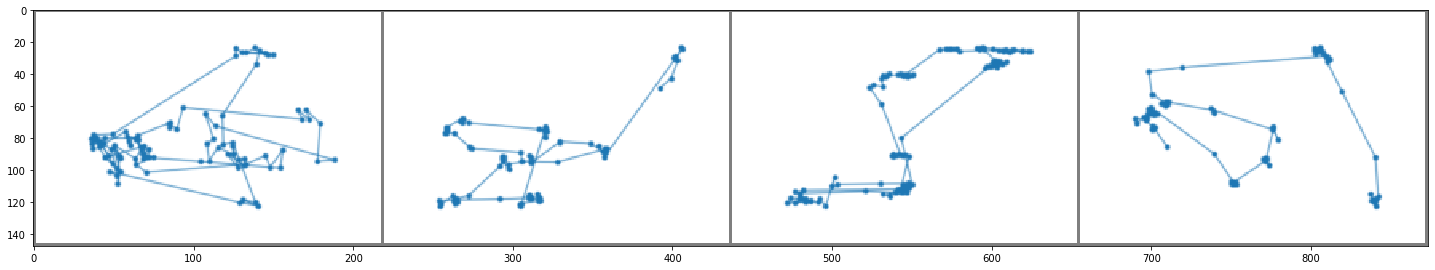

confused-confused-not_confused-confused


In [4]:
classes = ('confused', 'not_confused')
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(25, 25))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print('-'.join('%5s' % classes[labels[j]] for j in range(4)))

Relevant cues are fixations, saccades, and the temporal development thereof. Model architecture needs to capture this. Thus we need a large receptive
field, but a hierarchy of parts is likely not as important as in vision applications.
We use one image channel because colour has no meaning.
We use images instead of a matrix of x,y gaze coordinates because we want the connections that come with a
scatter plot, as this encodes saccadic magnitude information, however coarsely.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16*33*51, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*33*51)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x



In [5]:
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=26928, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=2, bias=True)
)


In [6]:
def cross_validate( folds,
                    epochs,
                    criterion_type,
                    optimizer_type,
                    confused_path,
                    not_confused_path,
                    print_every,
                    plot_every,
                    down_sample_training=True,
                    early_stopping=False,
                    early_stopping_metric='val_auc',
                    early_stopping_patience=10,
                    max_rate_decreases=100,
                    rate_decay_patience=5,
                    reload_best_on_decay=True,
                    learning_rate=0.001,
                    path_to_data_split='../grouped_10_fold_split_list_3.pickle',
                    verbose=False):
    """
        Perform Cross Validation of the model using k-folds.
        
        Args:
            model_type (string): the type of RNN to use. Must be 'lstm', 'gru', or 'rnn'
            epochs (int): the max number of epochs to train the model for each fold
            criterion_type (string): the name loss function to use for training. Currently must be 'NLLLoss'
            optimizer_type (string): the name of learning algorithm to use for training. ex 'Adam'
            confused_path (string): the path to the folder containing the confused data samples
            not_confused_path (string): the path to the folder containing the not_confused data samples
            print_every (int): the number of batches to train for before printing relevant stats
            plot_every (int): the number of batches to train for before recording relevant stats, which
                will be plotted after each fold
            hidden_size (int): the number of hidden units for each layer of the RNN
            num_layers (int): the number of hidden_unit sized layers of the RNN
            down_sample_training (boolean): if True training set will be balanced by down sampling not_confused
            early_stopping (boolean): if True, training will stop when early_stopping_patience epochs of 
                of training have passed without improvement in validation AUC ROC score
            early_stopping_patience (int): number of epochs without improvement before stopping training
            rate_dacay (boolean): if True, learning rate will decrease every rate_decay_patience epochs that
                pass without improvement to validation set AUC ROC score.
            rate_decay_patience (int): number of epochs without imporovement in AUC ROC that can pass before
                reducing the learning rate by half.
            initial_learning_rate (float): the first learning rate to be used by the optimizer
            path_to_data_split (string): relative path to the file containing the item names for each CV fold
            verbose (boolean): if True, function will print additional stats

        Returns: (list,list,list,list,list,list)
            cv_val_accs (list): list containing the validation accuracy for each fold
            cv_val_sensis (list): list containing the validation sensitivity for each fold
            cv_val_specifs (list): list containing the validation specificity for each fold
            cv_test_accs (list): list containing the test accuracy for each fold
            cv_test_sensis (list): list containing the test sensitivity for each fold
            cv_test_specifs (list): list containing the test specificity for each fold
        
    """

    
    confused_file_names = os.listdir(confused_path)
    not_confused_file_names = os.listdir(not_confused_path)
    if '.DS_Store' in confused_file_names:
        confused_file_names.remove('.DS_Store')
    if '.DS_Store' in not_confused_file_names:
        not_confused_file_names.remove('.DS_Store')
    
    #ensure same items appear in folds, for reproducibility:
    infile = open(path_to_data_split,'rb') 
    split = pickle.load(infile)
    infile.close()
    
    train_confused_splits = split[0]
    test_confused_splits = split[1]
    train_not_confused_splits = split[2]
    test_not_confused_splits = split[3]
    
    cv_val_accs = []
    cv_val_sensis = []
    cv_val_specifs = []
    cv_val_aucs = []
    
    cv_test_sens = []
    cv_test_spec = []
    cv_test_combined = []
    cv_auc = []
    
    for k in range(folds):
        print("\nFold ", k+1)
        
        # Get data item file names for this fold and downsample not_confused to balance training set

        # change extension from .pkl to .png
        train_confused_splits[k] = [item[:-4]+'.png' for item in train_confused_splits[k]]
        train_not_confused_splits[k] = [item[:-4]+'.png' for item in train_not_confused_splits[k]]

        test_confused_splits[k] = [item[:-4]+'.png' for item in test_confused_splits[k]]
        test_not_confused_splits[k] = [item[:-4]+'.png' for item in test_not_confused_splits[k]]
        
        
        train_confused, \
        train_not_confused, \
        val_confused, \
        val_not_confused = \
        utils.get_train_val_split(train_confused_splits[k], train_not_confused_splits[k], percent_val_set=0.2)

        if down_sample_training:
            train_not_confused = random.sample(train_not_confused, k=(len(train_confused)))
        
        test_confused = test_confused_splits[k]
        test_not_confused = test_not_confused_splits[k]

        
        
        if verbose:
            print("confused items in training set: ", len(train_confused))
            print("not_confused items in training set: ", len(train_not_confused))
            print("confused items in validation set: ", len(val_confused))
            print("not_confused items in validation set: ", len(val_not_confused))
        
        if verbose:
            print("\nTest confused items:\n")
            print(test_confused)

            
            
        local_train_confused_path = '../dataset/augmented/train2/confused/'
        local_val_confused_path = '../dataset/augmented/val2/confused/'
        local_test_confused_path = '../dataset/augmented/test2/confused/'
        local_train_not_confused_path = '../dataset/augmented/train2/not_confused/'
        local_val_not_confused_path = '../dataset/augmented/val2/not_confused/'
        local_test_not_confused_path = '../dataset/augmented/test2/not_confused/'

        # Remove any old directories
        if os.path.exists(local_train_confused_path):
            shutil.rmtree(local_train_confused_path)
        if os.path.exists(local_val_confused_path):
            shutil.rmtree(local_val_confused_path)
        if os.path.exists(local_test_confused_path):
            shutil.rmtree(local_test_confused_path)
            
        if os.path.exists(local_train_not_confused_path):
            shutil.rmtree(local_train_not_confused_path)
        if os.path.exists(local_val_not_confused_path):
            shutil.rmtree(local_val_not_confused_path)
        if os.path.exists(local_test_not_confused_path):
            shutil.rmtree(local_test_not_confused_path)
            
        # Make new temp directories
        os.makedirs(local_train_confused_path)
        for i in train_confused:
            shutil.copy(src=confused_path+i,dst=local_train_confused_path+i)
        
        os.makedirs(local_val_confused_path)
        for i in val_confused:
            shutil.copy(src=confused_path+i,dst=local_val_confused_path+i)
        
        os.makedirs(local_test_confused_path)
        for i in test_confused:
            shutil.copy(src=confused_path+i,dst=local_test_confused_path+i)
        
        os.makedirs(local_train_not_confused_path)
        for i in train_not_confused:
            shutil.copy(src=not_confused_path+i,dst=local_train_not_confused_path+i)
            
        os.makedirs(local_val_not_confused_path)
        for i in val_not_confused:
            shutil.copy(src=not_confused_path+i,dst=local_val_not_confused_path+i)
        
        os.makedirs(local_test_not_confused_path)
        for i in test_not_confused:
            shutil.copy(src=not_confused_path+i,dst=local_test_not_confused_path+i)

        # Prepare training and validation data
        transform = transforms.Compose(
            [transforms.Resize((144,216)),
             transforms.ToTensor(),
             transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

        trainset = torchvision.datasets.ImageFolder('../dataset/augmented/train2/', transform=transform)

        trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

        testset = torchvision.datasets.ImageFolder('../dataset/augmented/test2/', transform=transform)

        testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

        valset = torchvision.datasets.ImageFolder('../dataset/augmented/val2/', transform=transform)

        valloader = torch.utils.data.DataLoader(valset, batch_size=4, shuffle=False)


        print("Training data: ", trainset)
        print("Validation data: ", valset)
        print("Test data: ", testset)
        
        torch.manual_seed(MANUAL_SEED)
        model = Net().double().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        
        #save fresh model to clear any old ones out
        torch.save(model.state_dict(), './best_Net'+'_fold_'+str(k) +'.pt')
        best_val_combined = 0.0
        #Train model for 30 epochs
        for epoch in range(30):  # loop over the dataset multiple times
            running_loss = 0.0
            epoch_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                item_sp, labels = data
                item_sp = item_sp.double()
                item_sp, labels = item_sp[:,0,:,:].unsqueeze(1).to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = model(item_sp)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                epoch_loss += loss.item()
                if i % 10 == 0:
                    print('[%d, %5d] loss: %.5f' %
                          (epoch + 1, i + 1, running_loss / 10))
                    running_loss = 0.0
            print('epoch %d average training loss: %.5f' % (epoch + 1, epoch_loss/ len(trainloader)))

            #check validation set metrics
            running_val_loss = 0.0
            y_true = torch.zeros((len(valloader)*4))
            y_scores = torch.zeros((len(valloader)*4, 2))
            with torch.no_grad():

                for i, data in enumerate(valloader, 0):
                    # get the inputs; data is a list of [inputs, labels]
                    item_sp, labels = data
                    item_sp = item_sp.double()
                    item_sp, labels = item_sp[:,0,:,:].unsqueeze(1).to(device), labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()
                    # forward + backward + optimize
                    outputs = model(item_sp)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item()
                    #keep track of predictions
                    num_items = outputs.shape[0]
                    y_true[i*num_items: i*num_items + num_items] = labels
                    y_scores[i*num_items: i*num_items + num_items, :] = outputs.squeeze()

                val_loss = running_val_loss/ len(valloader)
                print('epoch %d average val loss: %.5f' % (epoch + 1, val_loss))

                y_pred = torch.argmax(y_scores, axis=1)
                sensitivity = recall_score(y_true, y_pred, pos_label=0)
                specificity = recall_score(y_true, y_pred, pos_label=1)
                combined = (sensitivity + specificity ) / 2.0
                print("epoch %d validation sens. : %.5f, spec. : %.5f; combined: %.5f"
                      % (epoch + 1, sensitivity, specificity, combined))
                if combined > best_val_combined:
                    print("New best validation combined accuracy found. Saving model...")
                    best_val_combined = combined
                    torch.save(model.state_dict(), './best_Net'+'_fold_'+str(k) +'.pt')
        
        y_true = torch.zeros((len(testloader)*4))
        y_scores = torch.zeros((len(testloader)*4, 2))
        with torch.no_grad():
            model.load_state_dict(torch.load('./best_Net'+'_fold_'+str(k) +'.pt'))
            for i, data in enumerate(testloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                item_sp, labels = data
                item_sp = item_sp.double()
                item_sp, labels = item_sp[:,0,:,:].unsqueeze(1).to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                # forward + backward + optimize
                outputs = model(item_sp)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                #keep track of predictions
                num_items = outputs.shape[0]
                y_true[i*num_items: i*num_items + num_items] = labels
                y_scores[i*num_items: i*num_items + num_items, :] = outputs.squeeze()

            #check metrics:
            # no option to specify positive label, so flipping for confused=1
            y_true_flipped = np.array(y_true.numpy(), copy=True)
            y_true_flipped[y_true == 1] = 0
            y_true_flipped[y_true == 0] = 1
            auc = roc_auc_score(y_true_flipped, y_scores.numpy()[:,0])
            # roc_curve expects y_scores to be probability values of the positive class
            fpr, tpr, thresholds = roc_curve(y_true, y_scores.numpy()[:,0], pos_label=0)
            
            sensitivity, specificity, \
            accuracy = utils.optimal_threshold_sensitivity_specificity(thresholds[1:],
                                                                       tpr[1:],
                                                                       fpr[1:],
                                                                       y_true,
                                                                       y_scores.numpy()[:,0])
            combined = (sensitivity + specificity ) / 2.0

            
            
            
            
            print("Test set sens. : %.5f, spec. : %.5f, combined: %.5f, auc: %.5f" % (sensitivity, specificity, combined, auc))
            cv_test_sens.append(sensitivity)
            cv_test_spec.append(specificity)
            cv_test_combined.append(combined)
            cv_auc.append(auc)
            
    print("\n Average 10-fold CV test sensitivity: %.5f, specificity: %.5f, combined: %.5f, AUC: %.5f" % 
          ((sum(cv_test_sens)/len(cv_test_sens)), 
           (sum(cv_test_spec)/len(cv_test_spec)), 
           (sum(cv_test_combined)/len(cv_test_combined)),
           (sum(cv_auc)/len(cv_auc))))
    return cv_test_sens, cv_test_spec, cv_test_combined, cv_auc 

        

In [23]:
# compute for 10 different seeds - with AUC
sens = []
spec = []
comb = []
auc = []


for i in range(10):
# baseline 10-fold CV with GRU
    np.random.seed(MANUAL_SEED+i)
    random.seed(MANUAL_SEED+i)
    torch.manual_seed(MANUAL_SEED+i)

    sens_list, spec_list, comb_list, auc_list = cross_validate(folds=10,
                                               epochs=30,
                                               criterion_type='NLLLoss',
                                               optimizer_type='Adam',
                                               confused_path='../dataset/full_scanpath_dataset/confused/',
                                               not_confused_path='../dataset/full_scanpath_dataset/not_confused/',
                                               print_every=1,
                                               plot_every=1,
                                               down_sample_training=True,
                                               learning_rate=0.0001,
                                               verbose=True)
    # add mean of each measure for 10-fold CV to list
    sens.append(np.mean(sens_list))
    spec.append(np.mean(spec_list))
    comb.append(np.mean(comb_list))
    auc.append(np.mean(auc_list))
    
print("sensitivities: ", sens)
print("specificities: ", spec)
print("combined: ", comb)
print("auc: ", auc)


Fold  1
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  68
not_confused items in validation set:  2236

Test confused items:

['35a_H-SortTwoFactors-22-4.png', '35a_H-SortTwoFactors-22-3.png', '35a_H-SortTwoFactors-22-2.png', '35a_H-SortTwoFactors-22-1.png', '35a_H-SortTwoFactors-4-2.png', '141a_H-SortTwoFactors-22-2.png', '48a_V-SortTwoFactors-12-3.png', '55b_V-CDV-11-2.png', '55b_V-CDV-11-3.png', '48a_V-SortTwoFactors-12-2.png', '141a_H-SortTwoFactors-22-3.png', '35a_H-SortTwoFactors-4-3.png', '35a_H-SortTwoFactors-4-1.png', '141a_H-SortTwoFactors-22-1.png', '55b_V-CDV-11-1.png', '48a_V-SortTwoFactors-12-1.png', '35a_H-SortTwoFactors-4-4.png', '141a_H-SortTwoFactors-22-4.png', '55b_V-CDV-11-4.png', '48a_V-SortTwoFactors-12-4.png', '133a_H-CDV-16-2.png', '133a_H-CDV-16-3.png', '133a_H-CDV-16-1.png', '133a_H-CDV-16-4.png', '141a_H-RV-18-4.png', '35a_H-SortTwoFactors-15-4.png', '141a_H-RV-18-1.png', '35a_H-SortTwoFactors-

[14,    21] loss: 0.01568
[14,    31] loss: 0.02527
[14,    41] loss: 0.01784
[14,    51] loss: 0.04030
[14,    61] loss: 0.01722
[14,    71] loss: 0.01218
[14,    81] loss: 0.01744
[14,    91] loss: 0.02513
[14,   101] loss: 0.01634
[14,   111] loss: 0.03078
epoch 14 average training loss: 0.02236
epoch 14 average val loss: 0.40114
epoch 14 validation sens. : 0.61765, spec. : 0.89490; combined: 0.75627
[15,     1] loss: 0.00542
[15,    11] loss: 0.03195
[15,    21] loss: 0.01905
[15,    31] loss: 0.01343
[15,    41] loss: 0.01763
[15,    51] loss: 0.01342
[15,    61] loss: 0.01001
[15,    71] loss: 0.01018
[15,    81] loss: 0.01954
[15,    91] loss: 0.00499
[15,   101] loss: 0.01565
[15,   111] loss: 0.01150
epoch 15 average training loss: 0.01526
epoch 15 average val loss: 0.42300
epoch 15 validation sens. : 0.63235, spec. : 0.89401; combined: 0.76318
[16,     1] loss: 0.00086
[16,    11] loss: 0.00870
[16,    21] loss: 0.00916
[16,    31] loss: 0.01164
[16,    41] loss: 0.00795
[16,

Training data:  Dataset ImageFolder
    Number of datapoints: 568
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 1960
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[14,    51] loss: 0.02962
[14,    61] loss: 0.03163
[14,    71] loss: 0.04563
[14,    81] loss: 0.18407
[14,    91] loss: 0.04592
[14,   101] loss: 0.05294
[14,   111] loss: 0.02733
[14,   121] loss: 0.05553
[14,   131] loss: 0.03408
[14,   141] loss: 0.01812
epoch 14 average training loss: 0.05868
epoch 14 average val loss: 0.25066
epoch 14 validation sens. : 0.75000, spec. : 0.93385; combined: 0.84193
[15,     1] loss: 0.00530
[15,    11] loss: 0.02703
[15,    21] loss: 0.02204
[15,    31] loss: 0.01865
[15,    41] loss: 0.02537
[15,    51] loss: 0.02525
[15,    61] loss: 0.11540
[15,    71] loss: 0.08257
[15,    81] loss: 0.03010
[15,    91] loss: 0.01739
[15,   101] loss: 0.07462
[15,   111] loss: 0.04516
[15,   121] loss: 0.09415
[15,   131] loss: 0.03165
[15,   141] loss: 0.03086
epoch 15 average training loss: 0.04557
epoch 15 average val loss: 0.27095
epoch 15 validation sens. : 0.75000, spec. : 0.92604; combined: 0.83802
[16,     1] loss: 0.00039
[16,    11] loss: 0.06766
[16,

[29,   111] loss: 0.00223
[29,   121] loss: 0.00301
[29,   131] loss: 0.00197
[29,   141] loss: 0.00170
epoch 29 average training loss: 0.00254
epoch 29 average val loss: 0.29981
epoch 29 validation sens. : 0.72500, spec. : 0.94844; combined: 0.83672
[30,     1] loss: 0.00008
[30,    11] loss: 0.00178
[30,    21] loss: 0.00361
[30,    31] loss: 0.00219
[30,    41] loss: 0.00218
[30,    51] loss: 0.00086
[30,    61] loss: 0.00270
[30,    71] loss: 0.00368
[30,    81] loss: 0.00117
[30,    91] loss: 0.00160
[30,   101] loss: 0.00108
[30,   111] loss: 0.00131
[30,   121] loss: 0.00162
[30,   131] loss: 0.00112
[30,   141] loss: 0.00331
epoch 30 average training loss: 0.00201
epoch 30 average val loss: 0.32817
epoch 30 validation sens. : 0.72500, spec. : 0.93854; combined: 0.83177
Test set sens. : 0.81250, spec. : 0.59265, combined: 0.70258, auc: 0.79912

Fold  3
confused items in training set:  272
not_confused items in training set:  272
confused items in validation set:  48
not_confused

[12,    11] loss: 0.02815
[12,    21] loss: 0.04124
[12,    31] loss: 0.03904
[12,    41] loss: 0.04807
[12,    51] loss: 0.04454
[12,    61] loss: 0.03903
[12,    71] loss: 0.01903
[12,    81] loss: 0.03639
[12,    91] loss: 0.08042
[12,   101] loss: 0.04039
[12,   111] loss: 0.04484
[12,   121] loss: 0.03213
[12,   131] loss: 0.02040
epoch 12 average training loss: 0.03938
epoch 12 average val loss: 0.42470
epoch 12 validation sens. : 0.66667, spec. : 0.87914; combined: 0.77290
New best validation combined accuracy found. Saving model...
[13,     1] loss: 0.00066
[13,    11] loss: 0.01967
[13,    21] loss: 0.02317
[13,    31] loss: 0.04177
[13,    41] loss: 0.02245
[13,    51] loss: 0.03584
[13,    61] loss: 0.04201
[13,    71] loss: 0.03650
[13,    81] loss: 0.03522
[13,    91] loss: 0.01652
[13,   101] loss: 0.01948
[13,   111] loss: 0.02898
[13,   121] loss: 0.01046
[13,   131] loss: 0.01604
epoch 13 average training loss: 0.02787
epoch 13 average val loss: 0.42973
epoch 13 valida

[27,   101] loss: 0.00249
[27,   111] loss: 0.00142
[27,   121] loss: 0.00204
[27,   131] loss: 0.00065
epoch 27 average training loss: 0.00128
epoch 27 average val loss: 0.70349
epoch 27 validation sens. : 0.68750, spec. : 0.86745; combined: 0.77747
[28,     1] loss: 0.00006
[28,    11] loss: 0.00098
[28,    21] loss: 0.00111
[28,    31] loss: 0.00204
[28,    41] loss: 0.00076
[28,    51] loss: 0.00159
[28,    61] loss: 0.00062
[28,    71] loss: 0.00039
[28,    81] loss: 0.00100
[28,    91] loss: 0.00107
[28,   101] loss: 0.00131
[28,   111] loss: 0.00086
[28,   121] loss: 0.00134
[28,   131] loss: 0.00058
epoch 28 average training loss: 0.00104
epoch 28 average val loss: 0.68124
epoch 28 validation sens. : 0.68750, spec. : 0.87622; combined: 0.78186
[29,     1] loss: 0.00002
[29,    11] loss: 0.00104
[29,    21] loss: 0.00108
[29,    31] loss: 0.00140
[29,    41] loss: 0.00097
[29,    51] loss: 0.00127
[29,    61] loss: 0.00069
[29,    71] loss: 0.00094
[29,    81] loss: 0.00099
[29,

[9,    11] loss: 0.08627
[9,    21] loss: 0.11422
[9,    31] loss: 0.20569
[9,    41] loss: 0.18794
[9,    51] loss: 0.11003
[9,    61] loss: 0.08059
[9,    71] loss: 0.17047
[9,    81] loss: 0.16292
[9,    91] loss: 0.07033
[9,   101] loss: 0.11678
[9,   111] loss: 0.08950
[9,   121] loss: 0.19868
[9,   131] loss: 0.09829
epoch 9 average training loss: 0.12951
epoch 9 average val loss: 0.41861
epoch 9 validation sens. : 0.66667, spec. : 0.85977; combined: 0.76322
[10,     1] loss: 0.02049
[10,    11] loss: 0.13858
[10,    21] loss: 0.05672
[10,    31] loss: 0.09027
[10,    41] loss: 0.08597
[10,    51] loss: 0.07624
[10,    61] loss: 0.16759
[10,    71] loss: 0.10119
[10,    81] loss: 0.04254
[10,    91] loss: 0.09780
[10,   101] loss: 0.07424
[10,   111] loss: 0.07835
[10,   121] loss: 0.27725
[10,   131] loss: 0.05665
epoch 10 average training loss: 0.10447
epoch 10 average val loss: 0.33806
epoch 10 validation sens. : 0.58333, spec. : 0.90815; combined: 0.74574
[11,     1] loss: 0.

[25,    31] loss: 0.00134
[25,    41] loss: 0.00090
[25,    51] loss: 0.00187
[25,    61] loss: 0.00440
[25,    71] loss: 0.00250
[25,    81] loss: 0.00213
[25,    91] loss: 0.00111
[25,   101] loss: 0.00339
[25,   111] loss: 0.00277
[25,   121] loss: 0.00104
[25,   131] loss: 0.00550
epoch 25 average training loss: 0.00238
epoch 25 average val loss: 0.50354
epoch 25 validation sens. : 0.55556, spec. : 0.91532; combined: 0.73544
[26,     1] loss: 0.00109
[26,    11] loss: 0.00225
[26,    21] loss: 0.00201
[26,    31] loss: 0.00125
[26,    41] loss: 0.00143
[26,    51] loss: 0.00124
[26,    61] loss: 0.00253
[26,    71] loss: 0.00072
[26,    81] loss: 0.00199
[26,    91] loss: 0.00499
[26,   101] loss: 0.00129
[26,   111] loss: 0.00191
[26,   121] loss: 0.00189
[26,   131] loss: 0.00175
epoch 26 average training loss: 0.00202
epoch 26 average val loss: 0.59706
epoch 26 validation sens. : 0.55556, spec. : 0.89964; combined: 0.72760
[27,     1] loss: 0.00019
[27,    11] loss: 0.00084
[27,

[7,    11] loss: 0.33972
[7,    21] loss: 0.24940
[7,    31] loss: 0.35648
[7,    41] loss: 0.30338
[7,    51] loss: 0.37254
[7,    61] loss: 0.30186
[7,    71] loss: 0.39460
[7,    81] loss: 0.29761
[7,    91] loss: 0.42280
[7,   101] loss: 0.34651
[7,   111] loss: 0.24935
[7,   121] loss: 0.35943
[7,   131] loss: 0.35060
[7,   141] loss: 0.31207
epoch 7 average training loss: 0.33488
epoch 7 average val loss: 0.38194
epoch 7 validation sens. : 0.81250, spec. : 0.88227; combined: 0.84738
[8,     1] loss: 0.04199
[8,    11] loss: 0.30259
[8,    21] loss: 0.31367
[8,    31] loss: 0.28928
[8,    41] loss: 0.27432
[8,    51] loss: 0.32422
[8,    61] loss: 0.25997
[8,    71] loss: 0.25144
[8,    81] loss: 0.32563
[8,    91] loss: 0.31730
[8,   101] loss: 0.27479
[8,   111] loss: 0.20867
[8,   121] loss: 0.28229
[8,   131] loss: 0.20537
[8,   141] loss: 0.18762
epoch 8 average training loss: 0.27433
epoch 8 average val loss: 0.40747
epoch 8 validation sens. : 0.84375, spec. : 0.85998; combi

[22,    91] loss: 0.01334
[22,   101] loss: 0.01395
[22,   111] loss: 0.00734
[22,   121] loss: 0.02677
[22,   131] loss: 0.00786
[22,   141] loss: 0.00984
epoch 22 average training loss: 0.01129
epoch 22 average val loss: 0.57910
epoch 22 validation sens. : 0.75000, spec. : 0.87839; combined: 0.81420
[23,     1] loss: 0.00114
[23,    11] loss: 0.01300
[23,    21] loss: 0.01009
[23,    31] loss: 0.00970
[23,    41] loss: 0.00543
[23,    51] loss: 0.01132
[23,    61] loss: 0.00695
[23,    71] loss: 0.00920
[23,    81] loss: 0.01005
[23,    91] loss: 0.00910
[23,   101] loss: 0.00732
[23,   111] loss: 0.01212
[23,   121] loss: 0.00665
[23,   131] loss: 0.00950
[23,   141] loss: 0.00845
epoch 23 average training loss: 0.00913
epoch 23 average val loss: 0.58790
epoch 23 validation sens. : 0.75000, spec. : 0.88130; combined: 0.81565
[24,     1] loss: 0.00088
[24,    11] loss: 0.00651
[24,    21] loss: 0.00582
[24,    31] loss: 0.00477
[24,    41] loss: 0.01234
[24,    51] loss: 0.00595
[24,

[3,    91] loss: 0.56402
[3,   101] loss: 0.52821
[3,   111] loss: 0.56132
epoch 3 average training loss: 0.55513
epoch 3 average val loss: 0.45387
epoch 3 validation sens. : 0.70000, spec. : 0.92608; combined: 0.81304
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.05610
[4,    11] loss: 0.47389
[4,    21] loss: 0.48771
[4,    31] loss: 0.50856
[4,    41] loss: 0.39643
[4,    51] loss: 0.43153
[4,    61] loss: 0.56260
[4,    71] loss: 0.42086
[4,    81] loss: 0.40232
[4,    91] loss: 0.51392
[4,   101] loss: 0.45707
[4,   111] loss: 0.45141
epoch 4 average training loss: 0.47257
epoch 4 average val loss: 0.34146
epoch 4 validation sens. : 0.66667, spec. : 0.96234; combined: 0.81450
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.02081
[5,    11] loss: 0.36966
[5,    21] loss: 0.39729
[5,    31] loss: 0.38526
[5,    41] loss: 0.40010
[5,    51] loss: 0.47624
[5,    61] loss: 0.38530
[5,    71] loss: 0.37648
[5,    81] loss

[21,    11] loss: 0.00395
[21,    21] loss: 0.00509
[21,    31] loss: 0.02816
[21,    41] loss: 0.02732
[21,    51] loss: 0.00913
[21,    61] loss: 0.02403
[21,    71] loss: 0.00358
[21,    81] loss: 0.00896
[21,    91] loss: 0.02535
[21,   101] loss: 0.00334
[21,   111] loss: 0.01122
epoch 21 average training loss: 0.01345
epoch 21 average val loss: 0.52781
epoch 21 validation sens. : 0.58333, spec. : 0.89077; combined: 0.73705
[22,     1] loss: 0.00076
[22,    11] loss: 0.00812
[22,    21] loss: 0.00476
[22,    31] loss: 0.00355
[22,    41] loss: 0.00463
[22,    51] loss: 0.00246
[22,    61] loss: 0.00512
[22,    71] loss: 0.03567
[22,    81] loss: 0.00639
[22,    91] loss: 0.01954
[22,   101] loss: 0.00476
[22,   111] loss: 0.01788
epoch 22 average training loss: 0.01143
epoch 22 average val loss: 0.52750
epoch 22 validation sens. : 0.58333, spec. : 0.89689; combined: 0.74011
[23,     1] loss: 0.00051
[23,    11] loss: 0.01687
[23,    21] loss: 0.00425
[23,    31] loss: 0.02122
[23,

[4,    21] loss: 0.47583
[4,    31] loss: 0.52123
[4,    41] loss: 0.48515
[4,    51] loss: 0.46858
[4,    61] loss: 0.46278
[4,    71] loss: 0.40961
[4,    81] loss: 0.35304
[4,    91] loss: 0.59829
[4,   101] loss: 0.40180
[4,   111] loss: 0.35306
[4,   121] loss: 0.42564
[4,   131] loss: 0.43604
[4,   141] loss: 0.37672
epoch 4 average training loss: 0.44104
epoch 4 average val loss: 0.60241
epoch 4 validation sens. : 1.00000, spec. : 0.75202; combined: 0.87601
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.04900
[5,    11] loss: 0.30522
[5,    21] loss: 0.32676
[5,    31] loss: 0.39177
[5,    41] loss: 0.25573
[5,    51] loss: 0.42491
[5,    61] loss: 0.29454
[5,    71] loss: 0.34632
[5,    81] loss: 0.41376
[5,    91] loss: 0.41228
[5,   101] loss: 0.41539
[5,   111] loss: 0.33524
[5,   121] loss: 0.39401
[5,   131] loss: 0.41661
[5,   141] loss: 0.35994
epoch 5 average training loss: 0.36493
epoch 5 average val loss: 0.39470
epoch 5 validation sen

[19,    21] loss: 0.00913
[19,    31] loss: 0.01257
[19,    41] loss: 0.00695
[19,    51] loss: 0.00644
[19,    61] loss: 0.00667
[19,    71] loss: 0.00958
[19,    81] loss: 0.01116
[19,    91] loss: 0.00488
[19,   101] loss: 0.00424
[19,   111] loss: 0.01718
[19,   121] loss: 0.01050
[19,   131] loss: 0.00696
[19,   141] loss: 0.00828
epoch 19 average training loss: 0.00863
epoch 19 average val loss: 0.39557
epoch 19 validation sens. : 0.75000, spec. : 0.92188; combined: 0.83594
[20,     1] loss: 0.00036
[20,    11] loss: 0.00319
[20,    21] loss: 0.00538
[20,    31] loss: 0.00646
[20,    41] loss: 0.00707
[20,    51] loss: 0.01307
[20,    61] loss: 0.00872
[20,    71] loss: 0.00369
[20,    81] loss: 0.00496
[20,    91] loss: 0.00434
[20,   101] loss: 0.00406
[20,   111] loss: 0.01143
[20,   121] loss: 0.00983
[20,   131] loss: 0.00655
[20,   141] loss: 0.01224
epoch 20 average training loss: 0.00702
epoch 20 average val loss: 0.41748
epoch 20 validation sens. : 0.85000, spec. : 0.923

[1,     1] loss: 0.06724
[1,    11] loss: 0.70248
[1,    21] loss: 0.68664
[1,    31] loss: 0.69833
[1,    41] loss: 0.69280
[1,    51] loss: 0.68736
[1,    61] loss: 0.66309
[1,    71] loss: 0.70285
[1,    81] loss: 0.65619
[1,    91] loss: 0.67034
[1,   101] loss: 0.65732
epoch 1 average training loss: 0.68099
epoch 1 average val loss: 0.71050
epoch 1 validation sens. : 0.95000, spec. : 0.48778; combined: 0.71889
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.07182
[2,    11] loss: 0.64744
[2,    21] loss: 0.66023
[2,    31] loss: 0.62951
[2,    41] loss: 0.59747
[2,    51] loss: 0.60838
[2,    61] loss: 0.62366
[2,    71] loss: 0.51107
[2,    81] loss: 0.70583
[2,    91] loss: 0.58768
[2,   101] loss: 0.57450
epoch 2 average training loss: 0.60905
epoch 2 average val loss: 0.96294
epoch 2 validation sens. : 1.00000, spec. : 0.00960; combined: 0.50480
[3,     1] loss: 0.04298
[3,    11] loss: 0.54478
[3,    21] loss: 0.49724
[3,    31] loss: 0.51328
[

[20,    11] loss: 0.00263
[20,    21] loss: 0.00514
[20,    31] loss: 0.00249
[20,    41] loss: 0.00473
[20,    51] loss: 0.00414
[20,    61] loss: 0.00410
[20,    71] loss: 0.00420
[20,    81] loss: 0.00425
[20,    91] loss: 0.00719
[20,   101] loss: 0.00476
epoch 20 average training loss: 0.00461
epoch 20 average val loss: 0.32114
epoch 20 validation sens. : 0.63750, spec. : 0.91274; combined: 0.77512
[21,     1] loss: 0.00002
[21,    11] loss: 0.00306
[21,    21] loss: 0.00406
[21,    31] loss: 0.00304
[21,    41] loss: 0.00675
[21,    51] loss: 0.00639
[21,    61] loss: 0.00310
[21,    71] loss: 0.00351
[21,    81] loss: 0.00471
[21,    91] loss: 0.00305
[21,   101] loss: 0.00202
epoch 21 average training loss: 0.00394
epoch 21 average val loss: 0.35727
epoch 21 validation sens. : 0.65000, spec. : 0.90140; combined: 0.77570
[22,     1] loss: 0.00018
[22,    11] loss: 0.00467
[22,    21] loss: 0.00168
[22,    31] loss: 0.00305
[22,    41] loss: 0.00379
[22,    51] loss: 0.00266
[22,

[2,    11] loss: 0.69118
[2,    21] loss: 0.67828
[2,    31] loss: 0.64802
[2,    41] loss: 0.67381
[2,    51] loss: 0.62686
[2,    61] loss: 0.64622
[2,    71] loss: 0.64780
[2,    81] loss: 0.64469
[2,    91] loss: 0.66966
[2,   101] loss: 0.60106
[2,   111] loss: 0.58163
epoch 2 average training loss: 0.65241
epoch 2 average val loss: 0.69751
epoch 2 validation sens. : 0.86364, spec. : 0.67796; combined: 0.77080
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.06129
[3,    11] loss: 0.62488
[3,    21] loss: 0.60959
[3,    31] loss: 0.54525
[3,    41] loss: 0.58109
[3,    51] loss: 0.60775
[3,    61] loss: 0.58206
[3,    71] loss: 0.50047
[3,    81] loss: 0.55807
[3,    91] loss: 0.53205
[3,   101] loss: 0.49482
[3,   111] loss: 0.49985
epoch 3 average training loss: 0.55861
epoch 3 average val loss: 0.44689
epoch 3 validation sens. : 0.59091, spec. : 0.92605; combined: 0.75848
[4,     1] loss: 0.04002
[4,    11] loss: 0.45126
[4,    21] loss: 0.49846
[

[20,    11] loss: 0.00378
[20,    21] loss: 0.00841
[20,    31] loss: 0.01044
[20,    41] loss: 0.01338
[20,    51] loss: 0.01030
[20,    61] loss: 0.00561
[20,    71] loss: 0.00434
[20,    81] loss: 0.00337
[20,    91] loss: 0.00960
[20,   101] loss: 0.00871
[20,   111] loss: 0.00953
epoch 20 average training loss: 0.00765
epoch 20 average val loss: 0.32263
epoch 20 validation sens. : 0.43182, spec. : 0.92128; combined: 0.67655
[21,     1] loss: 0.00051
[21,    11] loss: 0.00819
[21,    21] loss: 0.00799
[21,    31] loss: 0.00594
[21,    41] loss: 0.00360
[21,    51] loss: 0.00895
[21,    61] loss: 0.00624
[21,    71] loss: 0.00704
[21,    81] loss: 0.00451
[21,    91] loss: 0.00454
[21,   101] loss: 0.00526
[21,   111] loss: 0.00594
epoch 21 average training loss: 0.00591
epoch 21 average val loss: 0.31617
epoch 21 validation sens. : 0.43182, spec. : 0.92700; combined: 0.67941
[22,     1] loss: 0.00036
[22,    11] loss: 0.00309
[22,    21] loss: 0.00470
[22,    31] loss: 0.00379
[22,

[1,   111] loss: 0.68178
epoch 1 average training loss: 0.68543
epoch 1 average val loss: 0.72316
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06769
[2,    11] loss: 0.64393
[2,    21] loss: 0.69181
[2,    31] loss: 0.63651
[2,    41] loss: 0.63966
[2,    51] loss: 0.57234
[2,    61] loss: 0.59663
[2,    71] loss: 0.63625
[2,    81] loss: 0.60230
[2,    91] loss: 0.60300
[2,   101] loss: 0.65733
[2,   111] loss: 0.63735
epoch 2 average training loss: 0.62800
epoch 2 average val loss: 0.71091
epoch 2 validation sens. : 0.84615, spec. : 0.79296; combined: 0.81956
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.07648
[3,    11] loss: 0.57423
[3,    21] loss: 0.62448
[3,    31] loss: 0.58770
[3,    41] loss: 0.52921
[3,    51] loss: 0.61592
[3,    61] loss: 0.54634
[3,    71] loss: 0.51739
[3,    81] loss: 0.49775
[3,    91] loss: 0.45950
[3,   101] loss

[19,    71] loss: 0.00382
[19,    81] loss: 0.00818
[19,    91] loss: 0.01183
[19,   101] loss: 0.00691
[19,   111] loss: 0.01152
epoch 19 average training loss: 0.01135
epoch 19 average val loss: 0.32386
epoch 19 validation sens. : 0.71154, spec. : 0.91042; combined: 0.81098
[20,     1] loss: 0.00020
[20,    11] loss: 0.00542
[20,    21] loss: 0.00648
[20,    31] loss: 0.00938
[20,    41] loss: 0.01330
[20,    51] loss: 0.01149
[20,    61] loss: 0.00892
[20,    71] loss: 0.00711
[20,    81] loss: 0.01100
[20,    91] loss: 0.00591
[20,   101] loss: 0.00658
[20,   111] loss: 0.00535
epoch 20 average training loss: 0.00822
epoch 20 average val loss: 0.40704
epoch 20 validation sens. : 0.71154, spec. : 0.89168; combined: 0.80161
[21,     1] loss: 0.00018
[21,    11] loss: 0.00939
[21,    21] loss: 0.00434
[21,    31] loss: 0.00319
[21,    41] loss: 0.00641
[21,    51] loss: 0.00448
[21,    61] loss: 0.00806
[21,    71] loss: 0.00868
[21,    81] loss: 0.00554
[21,    91] loss: 0.00289
[21,

[2,    31] loss: 0.64517
[2,    41] loss: 0.67557
[2,    51] loss: 0.58121
[2,    61] loss: 0.61756
[2,    71] loss: 0.65185
[2,    81] loss: 0.63931
[2,    91] loss: 0.63726
[2,   101] loss: 0.61717
[2,   111] loss: 0.54303
epoch 2 average training loss: 0.63771
epoch 2 average val loss: 0.86230
epoch 2 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
[3,     1] loss: 0.05979
[3,    11] loss: 0.67417
[3,    21] loss: 0.59123
[3,    31] loss: 0.50010
[3,    41] loss: 0.57720
[3,    51] loss: 0.52757
[3,    61] loss: 0.64014
[3,    71] loss: 0.54651
[3,    81] loss: 0.59953
[3,    91] loss: 0.65547
[3,   101] loss: 0.60609
[3,   111] loss: 0.51396
epoch 3 average training loss: 0.58176
epoch 3 average val loss: 0.81519
epoch 3 validation sens. : 0.88235, spec. : 0.13953; combined: 0.51094
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.03952
[4,    11] loss: 0.47503
[4,    21] loss: 0.51471
[4,    31] loss: 0.55839
[4,    41] loss: 0.49880
[

epoch 19 average val loss: 0.46011
epoch 19 validation sens. : 0.64706, spec. : 0.91055; combined: 0.77881
[20,     1] loss: 0.00064
[20,    11] loss: 0.00670
[20,    21] loss: 0.00495
[20,    31] loss: 0.00416
[20,    41] loss: 0.00559
[20,    51] loss: 0.00253
[20,    61] loss: 0.00131
[20,    71] loss: 0.00530
[20,    81] loss: 0.00519
[20,    91] loss: 0.00477
[20,   101] loss: 0.00402
[20,   111] loss: 0.00272
epoch 20 average training loss: 0.00420
epoch 20 average val loss: 0.44430
epoch 20 validation sens. : 0.64706, spec. : 0.91860; combined: 0.78283
[21,     1] loss: 0.00004
[21,    11] loss: 0.00220
[21,    21] loss: 0.00557
[21,    31] loss: 0.00266
[21,    41] loss: 0.00511
[21,    51] loss: 0.00223
[21,    61] loss: 0.00323
[21,    71] loss: 0.00164
[21,    81] loss: 0.00238
[21,    91] loss: 0.00365
[21,   101] loss: 0.00310
[21,   111] loss: 0.00294
epoch 21 average training loss: 0.00317
epoch 21 average val loss: 0.45733
epoch 21 validation sens. : 0.63235, spec. : 0.

[3,    71] loss: 0.61201
[3,    81] loss: 0.61473
[3,    91] loss: 0.53327
[3,   101] loss: 0.49894
[3,   111] loss: 0.41464
[3,   121] loss: 0.57401
[3,   131] loss: 0.61032
[3,   141] loss: 0.58534
epoch 3 average training loss: 0.55852
epoch 3 average val loss: 0.53061
epoch 3 validation sens. : 0.77500, spec. : 0.90260; combined: 0.83880
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.03780
[4,    11] loss: 0.47913
[4,    21] loss: 0.48370
[4,    31] loss: 0.43451
[4,    41] loss: 0.48360
[4,    51] loss: 0.49017
[4,    61] loss: 0.55961
[4,    71] loss: 0.46390
[4,    81] loss: 0.55668
[4,    91] loss: 0.46315
[4,   101] loss: 0.46283
[4,   111] loss: 0.47815
[4,   121] loss: 0.42530
[4,   131] loss: 0.42294
[4,   141] loss: 0.46765
epoch 4 average training loss: 0.47427
epoch 4 average val loss: 0.34424
epoch 4 validation sens. : 0.62500, spec. : 0.96146; combined: 0.79323
[5,     1] loss: 0.02893
[5,    11] loss: 0.44554
[5,    21] loss: 0.42875
[

epoch 18 average val loss: 0.38124
epoch 18 validation sens. : 0.75000, spec. : 0.90052; combined: 0.82526
[19,     1] loss: 0.00025
[19,    11] loss: 0.01120
[19,    21] loss: 0.00515
[19,    31] loss: 0.00783
[19,    41] loss: 0.00666
[19,    51] loss: 0.01852
[19,    61] loss: 0.00911
[19,    71] loss: 0.00987
[19,    81] loss: 0.00424
[19,    91] loss: 0.00575
[19,   101] loss: 0.00445
[19,   111] loss: 0.00679
[19,   121] loss: 0.00636
[19,   131] loss: 0.00737
[19,   141] loss: 0.00737
epoch 19 average training loss: 0.00782
epoch 19 average val loss: 0.42232
epoch 19 validation sens. : 0.75000, spec. : 0.88594; combined: 0.81797
[20,     1] loss: 0.00009
[20,    11] loss: 0.00614
[20,    21] loss: 0.00435
[20,    31] loss: 0.00442
[20,    41] loss: 0.00777
[20,    51] loss: 0.00460
[20,    61] loss: 0.00638
[20,    71] loss: 0.00354
[20,    81] loss: 0.00644
[20,    91] loss: 0.00708
[20,   101] loss: 0.00783
[20,   111] loss: 0.00585
[20,   121] loss: 0.00472
[20,   131] loss: 

[1,     1] loss: 0.06739
[1,    11] loss: 0.70867
[1,    21] loss: 0.68787
[1,    31] loss: 0.70359
[1,    41] loss: 0.68902
[1,    51] loss: 0.69623
[1,    61] loss: 0.69482
[1,    71] loss: 0.68584
[1,    81] loss: 0.68774
[1,    91] loss: 0.68337
[1,   101] loss: 0.68246
[1,   111] loss: 0.69703
[1,   121] loss: 0.66479
[1,   131] loss: 0.66370
epoch 1 average training loss: 0.68637
epoch 1 average val loss: 0.82364
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06799
[2,    11] loss: 0.65239
[2,    21] loss: 0.64801
[2,    31] loss: 0.58852
[2,    41] loss: 0.68108
[2,    51] loss: 0.60445
[2,    61] loss: 0.62832
[2,    71] loss: 0.65545
[2,    81] loss: 0.57045
[2,    91] loss: 0.53245
[2,   101] loss: 0.67980
[2,   111] loss: 0.60402
[2,   121] loss: 0.59600
[2,   131] loss: 0.61418
epoch 2 average training loss: 0.62039
epoch 2 average val loss: 0.67620
epoch 2 validation sen

[17,    21] loss: 0.01247
[17,    31] loss: 0.01662
[17,    41] loss: 0.01380
[17,    51] loss: 0.02519
[17,    61] loss: 0.01623
[17,    71] loss: 0.01509
[17,    81] loss: 0.03107
[17,    91] loss: 0.00504
[17,   101] loss: 0.03284
[17,   111] loss: 0.01846
[17,   121] loss: 0.00684
[17,   131] loss: 0.04072
epoch 17 average training loss: 0.01876
epoch 17 average val loss: 0.35793
epoch 17 validation sens. : 0.56250, spec. : 0.91910; combined: 0.74080
[18,     1] loss: 0.00050
[18,    11] loss: 0.02211
[18,    21] loss: 0.03529
[18,    31] loss: 0.01642
[18,    41] loss: 0.01053
[18,    51] loss: 0.00947
[18,    61] loss: 0.01487
[18,    71] loss: 0.00393
[18,    81] loss: 0.00960
[18,    91] loss: 0.01884
[18,   101] loss: 0.01004
[18,   111] loss: 0.03587
[18,   121] loss: 0.02379
[18,   131] loss: 0.01207
epoch 18 average training loss: 0.01704
epoch 18 average val loss: 0.45927
epoch 18 validation sens. : 0.56250, spec. : 0.88645; combined: 0.72448
[19,     1] loss: 0.00259
[19,

Training data:  Dataset ImageFolder
    Number of datapoints: 544
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2268
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[15,    11] loss: 0.01332
[15,    21] loss: 0.00736
[15,    31] loss: 0.02289
[15,    41] loss: 0.02389
[15,    51] loss: 0.01222
[15,    61] loss: 0.01051
[15,    71] loss: 0.01105
[15,    81] loss: 0.00649
[15,    91] loss: 0.00578
[15,   101] loss: 0.01217
[15,   111] loss: 0.00599
[15,   121] loss: 0.01204
[15,   131] loss: 0.01523
epoch 15 average training loss: 0.01248
epoch 15 average val loss: 0.45303
epoch 15 validation sens. : 0.55556, spec. : 0.90233; combined: 0.72894
[16,     1] loss: 0.00040
[16,    11] loss: 0.01023
[16,    21] loss: 0.01224
[16,    31] loss: 0.00399
[16,    41] loss: 0.00958
[16,    51] loss: 0.00508
[16,    61] loss: 0.00677
[16,    71] loss: 0.01017
[16,    81] loss: 0.00914
[16,    91] loss: 0.00811
[16,   101] loss: 0.00659
[16,   111] loss: 0.00468
[16,   121] loss: 0.00605
[16,   131] loss: 0.00903
epoch 16 average training loss: 0.00814
epoch 16 average val loss: 0.47675
epoch 16 validation sens. : 0.55556, spec. : 0.89740; combined: 0.72648
[17,

Training data:  Dataset ImageFolder
    Number of datapoints: 576
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2096
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1272
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[14,    51] loss: 0.04449
[14,    61] loss: 0.04047
[14,    71] loss: 0.03248
[14,    81] loss: 0.02127
[14,    91] loss: 0.03704
[14,   101] loss: 0.01647
[14,   111] loss: 0.03108
[14,   121] loss: 0.03393
[14,   131] loss: 0.02066
[14,   141] loss: 0.03529
epoch 14 average training loss: 0.03151
epoch 14 average val loss: 0.45075
epoch 14 validation sens. : 0.87500, spec. : 0.87791; combined: 0.87645
[15,     1] loss: 0.00036
[15,    11] loss: 0.01793
[15,    21] loss: 0.01304
[15,    31] loss: 0.02669
[15,    41] loss: 0.01700
[15,    51] loss: 0.01406
[15,    61] loss: 0.02493
[15,    71] loss: 0.01546
[15,    81] loss: 0.06568
[15,    91] loss: 0.02812
[15,   101] loss: 0.02844
[15,   111] loss: 0.01630
[15,   121] loss: 0.01628
[15,   131] loss: 0.01589
[15,   141] loss: 0.02199
epoch 15 average training loss: 0.02342
epoch 15 average val loss: 0.44873
epoch 15 validation sens. : 0.87500, spec. : 0.88614; combined: 0.88057
[16,     1] loss: 0.00009
[16,    11] loss: 0.01098
[16,

[29,   111] loss: 0.00043
[29,   121] loss: 0.00107
[29,   131] loss: 0.00100
[29,   141] loss: 0.00141
epoch 29 average training loss: 0.00107
epoch 29 average val loss: 0.67605
epoch 29 validation sens. : 0.84375, spec. : 0.88081; combined: 0.86228
[30,     1] loss: 0.00006
[30,    11] loss: 0.00036
[30,    21] loss: 0.00054
[30,    31] loss: 0.00146
[30,    41] loss: 0.00049
[30,    51] loss: 0.00110
[30,    61] loss: 0.00079
[30,    71] loss: 0.00046
[30,    81] loss: 0.00092
[30,    91] loss: 0.00178
[30,   101] loss: 0.00107
[30,   111] loss: 0.00178
[30,   121] loss: 0.00118
[30,   131] loss: 0.00096
[30,   141] loss: 0.00047
epoch 30 average training loss: 0.00095
epoch 30 average val loss: 0.68883
epoch 30 validation sens. : 0.84375, spec. : 0.88033; combined: 0.86204
Test set sens. : 0.90000, spec. : 0.87380, combined: 0.88690, auc: 0.93403

Fold  6
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  60
not_confused

epoch 11 average val loss: 0.38427
epoch 11 validation sens. : 0.76667, spec. : 0.88606; combined: 0.82637
[12,     1] loss: 0.00342
[12,    11] loss: 0.10640
[12,    21] loss: 0.08482
[12,    31] loss: 0.11006
[12,    41] loss: 0.05086
[12,    51] loss: 0.06584
[12,    61] loss: 0.04831
[12,    71] loss: 0.10864
[12,    81] loss: 0.03891
[12,    91] loss: 0.04510
[12,   101] loss: 0.04578
[12,   111] loss: 0.07701
epoch 12 average training loss: 0.07011
epoch 12 average val loss: 0.34842
epoch 12 validation sens. : 0.66667, spec. : 0.89783; combined: 0.78225
[13,     1] loss: 0.01204
[13,    11] loss: 0.01400
[13,    21] loss: 0.09063
[13,    31] loss: 0.07361
[13,    41] loss: 0.04490
[13,    51] loss: 0.02843
[13,    61] loss: 0.06639
[13,    71] loss: 0.07994
[13,    81] loss: 0.04484
[13,    91] loss: 0.04291
[13,   101] loss: 0.04113
[13,   111] loss: 0.03883
epoch 13 average training loss: 0.05038
epoch 13 average val loss: 0.41525
epoch 13 validation sens. : 0.65000, spec. : 0.

[29,   111] loss: 0.00283
epoch 29 average training loss: 0.00197
epoch 29 average val loss: 0.64631
epoch 29 validation sens. : 0.63333, spec. : 0.88041; combined: 0.75687
[30,     1] loss: 0.00019
[30,    11] loss: 0.00098
[30,    21] loss: 0.00139
[30,    31] loss: 0.00103
[30,    41] loss: 0.00235
[30,    51] loss: 0.00372
[30,    61] loss: 0.00118
[30,    71] loss: 0.00116
[30,    81] loss: 0.00107
[30,    91] loss: 0.00260
[30,   101] loss: 0.00196
[30,   111] loss: 0.00180
epoch 30 average training loss: 0.00169
epoch 30 average val loss: 0.66249
epoch 30 validation sens. : 0.63333, spec. : 0.87947; combined: 0.75640
Test set sens. : 0.80000, spec. : 0.75570, combined: 0.77785, auc: 0.83290

Fold  7
confused items in training set:  300
not_confused items in training set:  300
confused items in validation set:  20
not_confused items in validation set:  1984

Test confused items:

['112a_V-SortTwoFactors-5-3.png', '112a_V-SortTwoFactors-5-2.png', '112a_V-SortTwoFactors-5-1.png', '

[11,   131] loss: 0.13033
[11,   141] loss: 0.05866
epoch 11 average training loss: 0.07561
epoch 11 average val loss: 0.54675
epoch 11 validation sens. : 0.85000, spec. : 0.82359; combined: 0.83679
[12,     1] loss: 0.01450
[12,    11] loss: 0.02387
[12,    21] loss: 0.02926
[12,    31] loss: 0.04263
[12,    41] loss: 0.08151
[12,    51] loss: 0.08837
[12,    61] loss: 0.02609
[12,    71] loss: 0.13111
[12,    81] loss: 0.07064
[12,    91] loss: 0.04632
[12,   101] loss: 0.05731
[12,   111] loss: 0.05482
[12,   121] loss: 0.03747
[12,   131] loss: 0.10070
[12,   141] loss: 0.03711
epoch 12 average training loss: 0.05925
epoch 12 average val loss: 0.39707
epoch 12 validation sens. : 0.80000, spec. : 0.88458; combined: 0.84229
[13,     1] loss: 0.00174
[13,    11] loss: 0.05607
[13,    21] loss: 0.06329
[13,    31] loss: 0.04442
[13,    41] loss: 0.02991
[13,    51] loss: 0.01689
[13,    61] loss: 0.02976
[13,    71] loss: 0.03142
[13,    81] loss: 0.08394
[13,    91] loss: 0.02962
[13,

[27,    11] loss: 0.00077
[27,    21] loss: 0.00058
[27,    31] loss: 0.00196
[27,    41] loss: 0.00180
[27,    51] loss: 0.00164
[27,    61] loss: 0.00127
[27,    71] loss: 0.00058
[27,    81] loss: 0.00054
[27,    91] loss: 0.00131
[27,   101] loss: 0.00163
[27,   111] loss: 0.00068
[27,   121] loss: 0.00046
[27,   131] loss: 0.00073
[27,   141] loss: 0.00205
epoch 27 average training loss: 0.00117
epoch 27 average val loss: 0.68354
epoch 27 validation sens. : 0.75000, spec. : 0.89264; combined: 0.82132
[28,     1] loss: 0.00001
[28,    11] loss: 0.00076
[28,    21] loss: 0.00143
[28,    31] loss: 0.00121
[28,    41] loss: 0.00110
[28,    51] loss: 0.00141
[28,    61] loss: 0.00057
[28,    71] loss: 0.00067
[28,    81] loss: 0.00025
[28,    91] loss: 0.00167
[28,   101] loss: 0.00129
[28,   111] loss: 0.00214
[28,   121] loss: 0.00077
[28,   131] loss: 0.00035
[28,   141] loss: 0.00092
epoch 28 average training loss: 0.00101
epoch 28 average val loss: 0.61005
epoch 28 validation sens

[9,    61] loss: 0.15080
[9,    71] loss: 0.14560
[9,    81] loss: 0.20082
[9,    91] loss: 0.13460
[9,   101] loss: 0.06942
epoch 9 average training loss: 0.12146
epoch 9 average val loss: 0.38026
epoch 9 validation sens. : 0.73750, spec. : 0.85602; combined: 0.79676
[10,     1] loss: 0.00484
[10,    11] loss: 0.04809
[10,    21] loss: 0.16269
[10,    31] loss: 0.08144
[10,    41] loss: 0.10733
[10,    51] loss: 0.17140
[10,    61] loss: 0.06988
[10,    71] loss: 0.10408
[10,    81] loss: 0.12276
[10,    91] loss: 0.07193
[10,   101] loss: 0.04111
epoch 10 average training loss: 0.10014
epoch 10 average val loss: 0.27248
epoch 10 validation sens. : 0.62500, spec. : 0.90271; combined: 0.76385
[11,     1] loss: 0.00220
[11,    11] loss: 0.13798
[11,    21] loss: 0.05237
[11,    31] loss: 0.06982
[11,    41] loss: 0.04533
[11,    51] loss: 0.15940
[11,    61] loss: 0.09868
[11,    71] loss: 0.05640
[11,    81] loss: 0.04480
[11,    91] loss: 0.07470
[11,   101] loss: 0.04270
epoch 11 ave

[28,    51] loss: 0.00127
[28,    61] loss: 0.00208
[28,    71] loss: 0.00075
[28,    81] loss: 0.00044
[28,    91] loss: 0.00157
[28,   101] loss: 0.00216
epoch 28 average training loss: 0.00122
epoch 28 average val loss: 0.48331
epoch 28 validation sens. : 0.61250, spec. : 0.89485; combined: 0.75368
[29,     1] loss: 0.00019
[29,    11] loss: 0.00173
[29,    21] loss: 0.00078
[29,    31] loss: 0.00149
[29,    41] loss: 0.00082
[29,    51] loss: 0.00116
[29,    61] loss: 0.00051
[29,    71] loss: 0.00080
[29,    81] loss: 0.00177
[29,    91] loss: 0.00065
[29,   101] loss: 0.00109
epoch 29 average training loss: 0.00108
epoch 29 average val loss: 0.45571
epoch 29 validation sens. : 0.61250, spec. : 0.89878; combined: 0.75564
[30,     1] loss: 0.00016
[30,    11] loss: 0.00069
[30,    21] loss: 0.00114
[30,    31] loss: 0.00051
[30,    41] loss: 0.00063
[30,    51] loss: 0.00132
[30,    61] loss: 0.00096
[30,    71] loss: 0.00141
[30,    81] loss: 0.00078
[30,    91] loss: 0.00100
[30,

[9,   111] loss: 0.13457
epoch 9 average training loss: 0.14956
epoch 9 average val loss: 0.43024
epoch 9 validation sens. : 0.70455, spec. : 0.83445; combined: 0.76950
[10,     1] loss: 0.00368
[10,    11] loss: 0.09429
[10,    21] loss: 0.16035
[10,    31] loss: 0.27607
[10,    41] loss: 0.06413
[10,    51] loss: 0.13495
[10,    61] loss: 0.17724
[10,    71] loss: 0.11803
[10,    81] loss: 0.04841
[10,    91] loss: 0.06523
[10,   101] loss: 0.11103
[10,   111] loss: 0.14087
epoch 10 average training loss: 0.12293
epoch 10 average val loss: 0.33323
epoch 10 validation sens. : 0.65909, spec. : 0.88550; combined: 0.77229
[11,     1] loss: 0.00429
[11,    11] loss: 0.08888
[11,    21] loss: 0.07985
[11,    31] loss: 0.04918
[11,    41] loss: 0.14156
[11,    51] loss: 0.04864
[11,    61] loss: 0.04719
[11,    71] loss: 0.10904
[11,    81] loss: 0.09120
[11,    91] loss: 0.10009
[11,   101] loss: 0.03938
[11,   111] loss: 0.17288
epoch 11 average training loss: 0.10062
epoch 11 average val

[27,    91] loss: 0.00168
[27,   101] loss: 0.01027
[27,   111] loss: 0.00286
epoch 27 average training loss: 0.00418
epoch 27 average val loss: 0.40490
epoch 27 validation sens. : 0.56818, spec. : 0.90267; combined: 0.73543
[28,     1] loss: 0.00105
[28,    11] loss: 0.00323
[28,    21] loss: 0.00324
[28,    31] loss: 0.00093
[28,    41] loss: 0.00215
[28,    51] loss: 0.00612
[28,    61] loss: 0.00303
[28,    71] loss: 0.00423
[28,    81] loss: 0.00604
[28,    91] loss: 0.00134
[28,   101] loss: 0.00388
[28,   111] loss: 0.00394
epoch 28 average training loss: 0.00349
epoch 28 average val loss: 0.38693
epoch 28 validation sens. : 0.54545, spec. : 0.91317; combined: 0.72931
[29,     1] loss: 0.00012
[29,    11] loss: 0.00512
[29,    21] loss: 0.00572
[29,    31] loss: 0.00123
[29,    41] loss: 0.00244
[29,    51] loss: 0.00261
[29,    61] loss: 0.00091
[29,    71] loss: 0.00190
[29,    81] loss: 0.00210
[29,    91] loss: 0.00228
[29,   101] loss: 0.00867
[29,   111] loss: 0.00137
epoc

[9,    11] loss: 0.20257
[9,    21] loss: 0.18307
[9,    31] loss: 0.09947
[9,    41] loss: 0.07364
[9,    51] loss: 0.12764
[9,    61] loss: 0.13334
[9,    71] loss: 0.09284
[9,    81] loss: 0.13820
[9,    91] loss: 0.11514
[9,   101] loss: 0.20200
[9,   111] loss: 0.09721
epoch 9 average training loss: 0.13180
epoch 9 average val loss: 0.23493
epoch 9 validation sens. : 0.67308, spec. : 0.93190; combined: 0.80249
[10,     1] loss: 0.00354
[10,    11] loss: 0.10378
[10,    21] loss: 0.17593
[10,    31] loss: 0.10708
[10,    41] loss: 0.11490
[10,    51] loss: 0.11964
[10,    61] loss: 0.10594
[10,    71] loss: 0.07183
[10,    81] loss: 0.21082
[10,    91] loss: 0.07586
[10,   101] loss: 0.12284
[10,   111] loss: 0.05048
epoch 10 average training loss: 0.11257
epoch 10 average val loss: 0.44901
epoch 10 validation sens. : 0.88462, spec. : 0.83272; combined: 0.85867
[11,     1] loss: 0.00115
[11,    11] loss: 0.05455
[11,    21] loss: 0.10394
[11,    31] loss: 0.05517
[11,    41] loss: 

[27,    11] loss: 0.00405
[27,    21] loss: 0.00177
[27,    31] loss: 0.01393
[27,    41] loss: 0.00862
[27,    51] loss: 0.00946
[27,    61] loss: 0.00793
[27,    71] loss: 0.00927
[27,    81] loss: 0.00313
[27,    91] loss: 0.00844
[27,   101] loss: 0.00353
[27,   111] loss: 0.00224
epoch 27 average training loss: 0.00650
epoch 27 average val loss: 0.62324
epoch 27 validation sens. : 0.69231, spec. : 0.87980; combined: 0.78605
[28,     1] loss: 0.00034
[28,    11] loss: 0.00282
[28,    21] loss: 0.00087
[28,    31] loss: 0.01454
[28,    41] loss: 0.00336
[28,    51] loss: 0.00537
[28,    61] loss: 0.00313
[28,    71] loss: 0.00228
[28,    81] loss: 0.00311
[28,    91] loss: 0.00407
[28,   101] loss: 0.00257
[28,   111] loss: 0.00200
epoch 28 average training loss: 0.00413
epoch 28 average val loss: 0.63132
epoch 28 validation sens. : 0.67308, spec. : 0.88208; combined: 0.77758
[29,     1] loss: 0.00009
[29,    11] loss: 0.00119
[29,    21] loss: 0.00291
[29,    31] loss: 0.00507
[29,

[9,    71] loss: 0.26693
[9,    81] loss: 0.09044
[9,    91] loss: 0.16274
[9,   101] loss: 0.12772
[9,   111] loss: 0.08643
epoch 9 average training loss: 0.16252
epoch 9 average val loss: 0.60536
epoch 9 validation sens. : 0.77941, spec. : 0.79293; combined: 0.78617
[10,     1] loss: 0.00648
[10,    11] loss: 0.14678
[10,    21] loss: 0.07767
[10,    31] loss: 0.16583
[10,    41] loss: 0.17645
[10,    51] loss: 0.19025
[10,    61] loss: 0.10613
[10,    71] loss: 0.11568
[10,    81] loss: 0.06911
[10,    91] loss: 0.17076
[10,   101] loss: 0.19088
[10,   111] loss: 0.07378
epoch 10 average training loss: 0.13961
epoch 10 average val loss: 0.37042
epoch 10 validation sens. : 0.66176, spec. : 0.90116; combined: 0.78146
[11,     1] loss: 0.00132
[11,    11] loss: 0.07323
[11,    21] loss: 0.14702
[11,    31] loss: 0.21156
[11,    41] loss: 0.08749
[11,    51] loss: 0.12698
[11,    61] loss: 0.10526
[11,    71] loss: 0.05366
[11,    81] loss: 0.04266
[11,    91] loss: 0.11747
[11,   101] 

[27,    31] loss: 0.00177
[27,    41] loss: 0.00213
[27,    51] loss: 0.00145
[27,    61] loss: 0.00465
[27,    71] loss: 0.00139
[27,    81] loss: 0.00354
[27,    91] loss: 0.00257
[27,   101] loss: 0.00202
[27,   111] loss: 0.00413
epoch 27 average training loss: 0.00244
epoch 27 average val loss: 0.55880
epoch 27 validation sens. : 0.64706, spec. : 0.91995; combined: 0.78350
[28,     1] loss: 0.00114
[28,    11] loss: 0.00512
[28,    21] loss: 0.00198
[28,    31] loss: 0.00206
[28,    41] loss: 0.00156
[28,    51] loss: 0.00106
[28,    61] loss: 0.00262
[28,    71] loss: 0.00202
[28,    81] loss: 0.00156
[28,    91] loss: 0.00187
[28,   101] loss: 0.00331
[28,   111] loss: 0.00193
epoch 28 average training loss: 0.00234
epoch 28 average val loss: 0.69689
epoch 28 validation sens. : 0.72059, spec. : 0.88953; combined: 0.80506
[29,     1] loss: 0.00020
[29,    11] loss: 0.00101
[29,    21] loss: 0.00225
[29,    31] loss: 0.00257
[29,    41] loss: 0.00355
[29,    51] loss: 0.00140
[29,

[9,   111] loss: 0.11843
[9,   121] loss: 0.12291
[9,   131] loss: 0.11975
[9,   141] loss: 0.11264
epoch 9 average training loss: 0.13896
epoch 9 average val loss: 0.27491
epoch 9 validation sens. : 0.87500, spec. : 0.90677; combined: 0.89089
New best validation combined accuracy found. Saving model...
[10,     1] loss: 0.00989
[10,    11] loss: 0.10520
[10,    21] loss: 0.19698
[10,    31] loss: 0.10981
[10,    41] loss: 0.08740
[10,    51] loss: 0.13322
[10,    61] loss: 0.08510
[10,    71] loss: 0.10661
[10,    81] loss: 0.09757
[10,    91] loss: 0.20494
[10,   101] loss: 0.18347
[10,   111] loss: 0.07007
[10,   121] loss: 0.10523
[10,   131] loss: 0.04903
[10,   141] loss: 0.06316
epoch 10 average training loss: 0.11346
epoch 10 average val loss: 0.27939
epoch 10 validation sens. : 0.85000, spec. : 0.90729; combined: 0.87865
[11,     1] loss: 0.00689
[11,    11] loss: 0.05657
[11,    21] loss: 0.16531
[11,    31] loss: 0.06400
[11,    41] loss: 0.05478
[11,    51] loss: 0.10065
[1

epoch 24 average val loss: 0.33668
epoch 24 validation sens. : 0.70000, spec. : 0.91563; combined: 0.80781
[25,     1] loss: 0.00017
[25,    11] loss: 0.00205
[25,    21] loss: 0.00760
[25,    31] loss: 0.00346
[25,    41] loss: 0.00448
[25,    51] loss: 0.00260
[25,    61] loss: 0.00135
[25,    71] loss: 0.00365
[25,    81] loss: 0.00189
[25,    91] loss: 0.00509
[25,   101] loss: 0.00233
[25,   111] loss: 0.00378
[25,   121] loss: 0.00497
[25,   131] loss: 0.00273
[25,   141] loss: 0.00305
epoch 25 average training loss: 0.00348
epoch 25 average val loss: 0.31548
epoch 25 validation sens. : 0.65000, spec. : 0.92135; combined: 0.78568
[26,     1] loss: 0.00141
[26,    11] loss: 0.00163
[26,    21] loss: 0.00192
[26,    31] loss: 0.00169
[26,    41] loss: 0.00125
[26,    51] loss: 0.00238
[26,    61] loss: 0.00223
[26,    71] loss: 0.00172
[26,    81] loss: 0.00347
[26,    91] loss: 0.00104
[26,   101] loss: 0.00475
[26,   111] loss: 0.00818
[26,   121] loss: 0.00577
[26,   131] loss: 

[7,    11] loss: 0.17356
[7,    21] loss: 0.20491
[7,    31] loss: 0.23717
[7,    41] loss: 0.26546
[7,    51] loss: 0.16156
[7,    61] loss: 0.29219
[7,    71] loss: 0.20691
[7,    81] loss: 0.17164
[7,    91] loss: 0.22969
[7,   101] loss: 0.26647
[7,   111] loss: 0.18469
[7,   121] loss: 0.26224
[7,   131] loss: 0.27027
epoch 7 average training loss: 0.22019
epoch 7 average val loss: 0.44028
epoch 7 validation sens. : 0.62500, spec. : 0.85185; combined: 0.73843
[8,     1] loss: 0.01604
[8,    11] loss: 0.12422
[8,    21] loss: 0.16815
[8,    31] loss: 0.15460
[8,    41] loss: 0.15773
[8,    51] loss: 0.13809
[8,    61] loss: 0.15892
[8,    71] loss: 0.15155
[8,    81] loss: 0.22324
[8,    91] loss: 0.25682
[8,   101] loss: 0.19429
[8,   111] loss: 0.13463
[8,   121] loss: 0.14469
[8,   131] loss: 0.14554
epoch 8 average training loss: 0.16485
epoch 8 average val loss: 0.26933
epoch 8 validation sens. : 0.56250, spec. : 0.92982; combined: 0.74616
[9,     1] loss: 0.00326
[9,    11] l

epoch 22 average val loss: 0.53447
epoch 22 validation sens. : 0.62500, spec. : 0.89912; combined: 0.76206
[23,     1] loss: 0.00058
[23,    11] loss: 0.00434
[23,    21] loss: 0.00477
[23,    31] loss: 0.00144
[23,    41] loss: 0.00115
[23,    51] loss: 0.00503
[23,    61] loss: 0.00379
[23,    71] loss: 0.00858
[23,    81] loss: 0.00747
[23,    91] loss: 0.00206
[23,   101] loss: 0.00259
[23,   111] loss: 0.00278
[23,   121] loss: 0.00477
[23,   131] loss: 0.00226
epoch 23 average training loss: 0.00448
epoch 23 average val loss: 0.66470
epoch 23 validation sens. : 0.62500, spec. : 0.87573; combined: 0.75037
[24,     1] loss: 0.00003
[24,    11] loss: 0.00953
[24,    21] loss: 0.00186
[24,    31] loss: 0.00625
[24,    41] loss: 0.00302
[24,    51] loss: 0.00423
[24,    61] loss: 0.00379
[24,    71] loss: 0.00287
[24,    81] loss: 0.00704
[24,    91] loss: 0.00716
[24,   101] loss: 0.00255
[24,   111] loss: 0.00642
[24,   121] loss: 0.00572
[24,   131] loss: 0.00252
epoch 24 average t

[4,    61] loss: 0.40223
[4,    71] loss: 0.41901
[4,    81] loss: 0.45364
[4,    91] loss: 0.58157
[4,   101] loss: 0.45322
[4,   111] loss: 0.42239
[4,   121] loss: 0.31794
[4,   131] loss: 0.47329
epoch 4 average training loss: 0.43006
epoch 4 average val loss: 0.33430
epoch 4 validation sens. : 0.63889, spec. : 0.93817; combined: 0.78853
[5,     1] loss: 0.06549
[5,    11] loss: 0.48099
[5,    21] loss: 0.26459
[5,    31] loss: 0.36874
[5,    41] loss: 0.38522
[5,    51] loss: 0.35590
[5,    61] loss: 0.34793
[5,    71] loss: 0.32847
[5,    81] loss: 0.33294
[5,    91] loss: 0.37533
[5,   101] loss: 0.32760
[5,   111] loss: 0.24781
[5,   121] loss: 0.35237
[5,   131] loss: 0.22366
epoch 5 average training loss: 0.33630
epoch 5 average val loss: 0.45284
epoch 5 validation sens. : 0.69444, spec. : 0.85708; combined: 0.77576
[6,     1] loss: 0.07325
[6,    11] loss: 0.19599
[6,    21] loss: 0.25548
[6,    31] loss: 0.23452
[6,    41] loss: 0.34941
[6,    51] loss: 0.29040
[6,    61] l

[20,   111] loss: 0.01920
[20,   121] loss: 0.01206
[20,   131] loss: 0.00249
epoch 20 average training loss: 0.00793
epoch 20 average val loss: 0.44737
epoch 20 validation sens. : 0.58333, spec. : 0.92204; combined: 0.75269
[21,     1] loss: 0.00009
[21,    11] loss: 0.00422
[21,    21] loss: 0.00381
[21,    31] loss: 0.00589
[21,    41] loss: 0.00489
[21,    51] loss: 0.00546
[21,    61] loss: 0.00449
[21,    71] loss: 0.00573
[21,    81] loss: 0.00428
[21,    91] loss: 0.01574
[21,   101] loss: 0.00343
[21,   111] loss: 0.00439
[21,   121] loss: 0.00836
[21,   131] loss: 0.00572
epoch 21 average training loss: 0.00577
epoch 21 average val loss: 0.43086
epoch 21 validation sens. : 0.58333, spec. : 0.93011; combined: 0.75672
[22,     1] loss: 0.00039
[22,    11] loss: 0.00453
[22,    21] loss: 0.00541
[22,    31] loss: 0.00500
[22,    41] loss: 0.00292
[22,    51] loss: 0.00508
[22,    61] loss: 0.00294
[22,    71] loss: 0.00314
[22,    81] loss: 0.00345
[22,    91] loss: 0.00501
[22,

epoch 2 average val loss: 0.61525
epoch 2 validation sens. : 0.90625, spec. : 0.76163; combined: 0.83394
[3,     1] loss: 0.06109
[3,    11] loss: 0.52156
[3,    21] loss: 0.55514
[3,    31] loss: 0.54535
[3,    41] loss: 0.52009
[3,    51] loss: 0.51594
[3,    61] loss: 0.44856
[3,    71] loss: 0.63083
[3,    81] loss: 0.41858
[3,    91] loss: 0.44436
[3,   101] loss: 0.58438
[3,   111] loss: 0.51383
[3,   121] loss: 0.38597
[3,   131] loss: 0.46206
[3,   141] loss: 0.52608
epoch 3 average training loss: 0.50279
epoch 3 average val loss: 0.62699
epoch 3 validation sens. : 1.00000, spec. : 0.72481; combined: 0.86240
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.03125
[4,    11] loss: 0.39680
[4,    21] loss: 0.46706
[4,    31] loss: 0.39275
[4,    41] loss: 0.46910
[4,    51] loss: 0.51272
[4,    61] loss: 0.42317
[4,    71] loss: 0.37839
[4,    81] loss: 0.36261
[4,    91] loss: 0.36483
[4,   101] loss: 0.37201
[4,   111] loss: 0.40680
[4,   121] loss

[18,     1] loss: 0.00079
[18,    11] loss: 0.01912
[18,    21] loss: 0.00498
[18,    31] loss: 0.01271
[18,    41] loss: 0.01429
[18,    51] loss: 0.01557
[18,    61] loss: 0.01162
[18,    71] loss: 0.00742
[18,    81] loss: 0.01520
[18,    91] loss: 0.00219
[18,   101] loss: 0.00510
[18,   111] loss: 0.00821
[18,   121] loss: 0.01048
[18,   131] loss: 0.00921
[18,   141] loss: 0.00747
epoch 18 average training loss: 0.01022
epoch 18 average val loss: 0.51733
epoch 18 validation sens. : 0.71875, spec. : 0.90165; combined: 0.81020
[19,     1] loss: 0.00085
[19,    11] loss: 0.00397
[19,    21] loss: 0.00422
[19,    31] loss: 0.01252
[19,    41] loss: 0.00589
[19,    51] loss: 0.00943
[19,    61] loss: 0.00301
[19,    71] loss: 0.00608
[19,    81] loss: 0.00144
[19,    91] loss: 0.00577
[19,   101] loss: 0.00700
[19,   111] loss: 0.00277
[19,   121] loss: 0.01382
[19,   131] loss: 0.00717
[19,   141] loss: 0.01463
epoch 19 average training loss: 0.00700
epoch 19 average val loss: 0.6244

Training data:  Dataset ImageFolder
    Number of datapoints: 480
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2184
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[16,    61] loss: 0.00457
[16,    71] loss: 0.01681
[16,    81] loss: 0.01585
[16,    91] loss: 0.01369
[16,   101] loss: 0.01378
[16,   111] loss: 0.01252
epoch 16 average training loss: 0.01341
epoch 16 average val loss: 0.39308
epoch 16 validation sens. : 0.60000, spec. : 0.89266; combined: 0.74633
[17,     1] loss: 0.00178
[17,    11] loss: 0.00854
[17,    21] loss: 0.00593
[17,    31] loss: 0.00559
[17,    41] loss: 0.00789
[17,    51] loss: 0.01072
[17,    61] loss: 0.00716
[17,    71] loss: 0.00646
[17,    81] loss: 0.02292
[17,    91] loss: 0.02012
[17,   101] loss: 0.00972
[17,   111] loss: 0.00947
epoch 17 average training loss: 0.01025
epoch 17 average val loss: 0.72931
epoch 17 validation sens. : 0.75000, spec. : 0.79896; combined: 0.77448
[18,     1] loss: 0.00594
[18,    11] loss: 0.00916
[18,    21] loss: 0.01074
[18,    31] loss: 0.00443
[18,    41] loss: 0.00671
[18,    51] loss: 0.00617
[18,    61] loss: 0.01231
[18,    71] loss: 0.01149
[18,    81] loss: 0.01241
[18,

[1,     1] loss: 0.06938
[1,    11] loss: 0.69418
[1,    21] loss: 0.69906
[1,    31] loss: 0.69440
[1,    41] loss: 0.69117
[1,    51] loss: 0.68664
[1,    61] loss: 0.68565
[1,    71] loss: 0.69347
[1,    81] loss: 0.67158
[1,    91] loss: 0.68881
[1,   101] loss: 0.67436
[1,   111] loss: 0.66522
[1,   121] loss: 0.65947
[1,   131] loss: 0.65199
[1,   141] loss: 0.65751
epoch 1 average training loss: 0.67817
epoch 1 average val loss: 0.61433
epoch 1 validation sens. : 0.80000, spec. : 0.85534; combined: 0.82767
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06962
[2,    11] loss: 0.60984
[2,    21] loss: 0.62543
[2,    31] loss: 0.59643
[2,    41] loss: 0.55549
[2,    51] loss: 0.64017
[2,    61] loss: 0.69717
[2,    71] loss: 0.68121
[2,    81] loss: 0.58891
[2,    91] loss: 0.53623
[2,   101] loss: 0.56767
[2,   111] loss: 0.55146
[2,   121] loss: 0.51753
[2,   131] loss: 0.59770
[2,   141] loss: 0.52038
epoch 2 average training loss: 0.58888
epoch 

[16,    71] loss: 0.01168
[16,    81] loss: 0.01774
[16,    91] loss: 0.01481
[16,   101] loss: 0.00678
[16,   111] loss: 0.00904
[16,   121] loss: 0.00914
[16,   131] loss: 0.00975
[16,   141] loss: 0.02093
epoch 16 average training loss: 0.01447
epoch 16 average val loss: 0.42020
epoch 16 validation sens. : 0.60000, spec. : 0.90776; combined: 0.75388
[17,     1] loss: 0.00104
[17,    11] loss: 0.01482
[17,    21] loss: 0.01691
[17,    31] loss: 0.01879
[17,    41] loss: 0.00739
[17,    51] loss: 0.00726
[17,    61] loss: 0.01063
[17,    71] loss: 0.00962
[17,    81] loss: 0.00709
[17,    91] loss: 0.00686
[17,   101] loss: 0.00856
[17,   111] loss: 0.00825
[17,   121] loss: 0.01320
[17,   131] loss: 0.01073
[17,   141] loss: 0.00875
epoch 17 average training loss: 0.01093
epoch 17 average val loss: 0.51981
epoch 17 validation sens. : 0.65000, spec. : 0.88206; combined: 0.76603
[18,     1] loss: 0.00012
[18,    11] loss: 0.02485
[18,    21] loss: 0.00678
[18,    31] loss: 0.01107
[18,

Training data:  Dataset ImageFolder
    Number of datapoints: 432
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2372
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1264
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[17,    41] loss: 0.01940
[17,    51] loss: 0.01681
[17,    61] loss: 0.01269
[17,    71] loss: 0.00847
[17,    81] loss: 0.01954
[17,    91] loss: 0.01194
[17,   101] loss: 0.01849
epoch 17 average training loss: 0.01490
epoch 17 average val loss: 0.47573
epoch 17 validation sens. : 0.75000, spec. : 0.83944; combined: 0.79472
[18,     1] loss: 0.00047
[18,    11] loss: 0.01228
[18,    21] loss: 0.01181
[18,    31] loss: 0.01203
[18,    41] loss: 0.02238
[18,    51] loss: 0.01601
[18,    61] loss: 0.01305
[18,    71] loss: 0.00903
[18,    81] loss: 0.00769
[18,    91] loss: 0.01056
[18,   101] loss: 0.01058
epoch 18 average training loss: 0.01260
epoch 18 average val loss: 0.25029
epoch 18 validation sens. : 0.65000, spec. : 0.93281; combined: 0.79140
[19,     1] loss: 0.00007
[19,    11] loss: 0.01127
[19,    21] loss: 0.01280
[19,    31] loss: 0.00644
[19,    41] loss: 0.00970
[19,    51] loss: 0.00940
[19,    61] loss: 0.00659
[19,    71] loss: 0.00636
[19,    81] loss: 0.00486
[19,

[1,    11] loss: 0.67159
[1,    21] loss: 0.73590
[1,    31] loss: 0.69455
[1,    41] loss: 0.69982
[1,    51] loss: 0.68898
[1,    61] loss: 0.70229
[1,    71] loss: 0.69556
[1,    81] loss: 0.68413
[1,    91] loss: 0.64618
[1,   101] loss: 0.66505
[1,   111] loss: 0.72740
epoch 1 average training loss: 0.69266
epoch 1 average val loss: 0.72380
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06661
[2,    11] loss: 0.68919
[2,    21] loss: 0.67137
[2,    31] loss: 0.64315
[2,    41] loss: 0.66577
[2,    51] loss: 0.63166
[2,    61] loss: 0.63774
[2,    71] loss: 0.62154
[2,    81] loss: 0.61775
[2,    91] loss: 0.66101
[2,   101] loss: 0.59697
[2,   111] loss: 0.59705
epoch 2 average training loss: 0.64092
epoch 2 average val loss: 0.76434
epoch 2 validation sens. : 1.00000, spec. : 0.41365; combined: 0.70682
New best validation combined accuracy found. Saving model...
[3,     1] loss

[19,    11] loss: 0.00432
[19,    21] loss: 0.00983
[19,    31] loss: 0.00426
[19,    41] loss: 0.00454
[19,    51] loss: 0.00170
[19,    61] loss: 0.00181
[19,    71] loss: 0.01107
[19,    81] loss: 0.00533
[19,    91] loss: 0.00606
[19,   101] loss: 0.00502
[19,   111] loss: 0.01261
epoch 19 average training loss: 0.00679
epoch 19 average val loss: 0.49808
epoch 19 validation sens. : 0.77273, spec. : 0.87786; combined: 0.82529
[20,     1] loss: 0.00025
[20,    11] loss: 0.00667
[20,    21] loss: 0.00555
[20,    31] loss: 0.01234
[20,    41] loss: 0.00936
[20,    51] loss: 0.00371
[20,    61] loss: 0.00587
[20,    71] loss: 0.00394
[20,    81] loss: 0.00168
[20,    91] loss: 0.00680
[20,   101] loss: 0.00370
[20,   111] loss: 0.00812
epoch 20 average training loss: 0.00591
epoch 20 average val loss: 0.48889
epoch 20 validation sens. : 0.70455, spec. : 0.88311; combined: 0.79383
[21,     1] loss: 0.00012
[21,    11] loss: 0.00572
[21,    21] loss: 0.00435
[21,    31] loss: 0.00121
[21,

[1,    11] loss: 0.70079
[1,    21] loss: 0.68312
[1,    31] loss: 0.71272
[1,    41] loss: 0.69659
[1,    51] loss: 0.69002
[1,    61] loss: 0.67311
[1,    71] loss: 0.66818
[1,    81] loss: 0.67210
[1,    91] loss: 0.65228
[1,   101] loss: 0.70349
[1,   111] loss: 0.67271
epoch 1 average training loss: 0.68390
epoch 1 average val loss: 0.72024
epoch 1 validation sens. : 0.90385, spec. : 0.37523; combined: 0.63954
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06702
[2,    11] loss: 0.65589
[2,    21] loss: 0.67614
[2,    31] loss: 0.63891
[2,    41] loss: 0.63448
[2,    51] loss: 0.59200
[2,    61] loss: 0.59529
[2,    71] loss: 0.61198
[2,    81] loss: 0.62526
[2,    91] loss: 0.61431
[2,   101] loss: 0.63571
[2,   111] loss: 0.60003
epoch 2 average training loss: 0.62316
epoch 2 average val loss: 0.61957
epoch 2 validation sens. : 0.84615, spec. : 0.79250; combined: 0.81933
New best validation combined accuracy found. Saving model...
[3,     1] loss

epoch 18 average val loss: 0.51702
epoch 18 validation sens. : 0.78846, spec. : 0.85101; combined: 0.81973
[19,     1] loss: 0.00347
[19,    11] loss: 0.01754
[19,    21] loss: 0.01194
[19,    31] loss: 0.01360
[19,    41] loss: 0.02062
[19,    51] loss: 0.01011
[19,    61] loss: 0.01907
[19,    71] loss: 0.00529
[19,    81] loss: 0.00955
[19,    91] loss: 0.01476
[19,   101] loss: 0.00737
[19,   111] loss: 0.00865
epoch 19 average training loss: 0.01332
epoch 19 average val loss: 0.42205
epoch 19 validation sens. : 0.71154, spec. : 0.87477; combined: 0.79315
[20,     1] loss: 0.00017
[20,    11] loss: 0.00413
[20,    21] loss: 0.00771
[20,    31] loss: 0.00744
[20,    41] loss: 0.00991
[20,    51] loss: 0.01197
[20,    61] loss: 0.01259
[20,    71] loss: 0.00826
[20,    81] loss: 0.00846
[20,    91] loss: 0.00803
[20,   101] loss: 0.01016
[20,   111] loss: 0.01256
epoch 20 average training loss: 0.00911
epoch 20 average val loss: 0.46926
epoch 20 validation sens. : 0.75000, spec. : 0.

[1,   111] loss: 0.72453
epoch 1 average training loss: 0.68726
epoch 1 average val loss: 0.72979
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06686
[2,    11] loss: 0.68634
[2,    21] loss: 0.68632
[2,    31] loss: 0.63533
[2,    41] loss: 0.65857
[2,    51] loss: 0.57436
[2,    61] loss: 0.63920
[2,    71] loss: 0.60470
[2,    81] loss: 0.60192
[2,    91] loss: 0.60702
[2,   101] loss: 0.61263
[2,   111] loss: 0.57391
epoch 2 average training loss: 0.62573
epoch 2 average val loss: 0.81363
epoch 2 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
[3,     1] loss: 0.05958
[3,    11] loss: 0.56563
[3,    21] loss: 0.56189
[3,    31] loss: 0.50312
[3,    41] loss: 0.50956
[3,    51] loss: 0.48446
[3,    61] loss: 0.65884
[3,    71] loss: 0.55925
[3,    81] loss: 0.62627
[3,    91] loss: 0.62656
[3,   101] loss: 0.60974
[3,   111] loss: 0.51452
epoch 3 average training l

[19,    71] loss: 0.02581
[19,    81] loss: 0.00781
[19,    91] loss: 0.02132
[19,   101] loss: 0.00790
[19,   111] loss: 0.00830
epoch 19 average training loss: 0.01487
epoch 19 average val loss: 0.53300
epoch 19 validation sens. : 0.61765, spec. : 0.88998; combined: 0.75381
[20,     1] loss: 0.00514
[20,    11] loss: 0.01747
[20,    21] loss: 0.01918
[20,    31] loss: 0.00458
[20,    41] loss: 0.02376
[20,    51] loss: 0.00834
[20,    61] loss: 0.00451
[20,    71] loss: 0.01226
[20,    81] loss: 0.01053
[20,    91] loss: 0.01039
[20,   101] loss: 0.01642
[20,   111] loss: 0.00635
epoch 20 average training loss: 0.01247
epoch 20 average val loss: 0.47814
epoch 20 validation sens. : 0.58824, spec. : 0.90653; combined: 0.74738
[21,     1] loss: 0.00004
[21,    11] loss: 0.00895
[21,    21] loss: 0.00681
[21,    31] loss: 0.01297
[21,    41] loss: 0.01094
[21,    51] loss: 0.00993
[21,    61] loss: 0.01362
[21,    71] loss: 0.00455
[21,    81] loss: 0.01281
[21,    91] loss: 0.00630
[21,

[3,    11] loss: 0.56656
[3,    21] loss: 0.61164
[3,    31] loss: 0.59991
[3,    41] loss: 0.55860
[3,    51] loss: 0.59045
[3,    61] loss: 0.55214
[3,    71] loss: 0.51983
[3,    81] loss: 0.61383
[3,    91] loss: 0.50881
[3,   101] loss: 0.44768
[3,   111] loss: 0.45214
[3,   121] loss: 0.52582
[3,   131] loss: 0.53428
[3,   141] loss: 0.56480
epoch 3 average training loss: 0.54511
epoch 3 average val loss: 0.50721
epoch 3 validation sens. : 0.75000, spec. : 0.95208; combined: 0.85104
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.03989
[4,    11] loss: 0.51147
[4,    21] loss: 0.45630
[4,    31] loss: 0.35919
[4,    41] loss: 0.50977
[4,    51] loss: 0.39322
[4,    61] loss: 0.44961
[4,    71] loss: 0.36637
[4,    81] loss: 0.48563
[4,    91] loss: 0.40692
[4,   101] loss: 0.39644
[4,   111] loss: 0.50584
[4,   121] loss: 0.40941
[4,   131] loss: 0.37521
[4,   141] loss: 0.35599
epoch 4 average training loss: 0.42551
epoch 4 average val loss: 0.341

[18,    51] loss: 0.00822
[18,    61] loss: 0.01836
[18,    71] loss: 0.01158
[18,    81] loss: 0.04093
[18,    91] loss: 0.03970
[18,   101] loss: 0.03543
[18,   111] loss: 0.03082
[18,   121] loss: 0.01340
[18,   131] loss: 0.00803
[18,   141] loss: 0.00823
epoch 18 average training loss: 0.01940
epoch 18 average val loss: 0.25407
epoch 18 validation sens. : 0.80000, spec. : 0.93490; combined: 0.86745
[19,     1] loss: 0.00035
[19,    11] loss: 0.03019
[19,    21] loss: 0.01030
[19,    31] loss: 0.01191
[19,    41] loss: 0.00762
[19,    51] loss: 0.01199
[19,    61] loss: 0.00723
[19,    71] loss: 0.02977
[19,    81] loss: 0.00770
[19,    91] loss: 0.00924
[19,   101] loss: 0.03008
[19,   111] loss: 0.01005
[19,   121] loss: 0.01107
[19,   131] loss: 0.01716
[19,   141] loss: 0.02621
epoch 19 average training loss: 0.01565
epoch 19 average val loss: 0.25996
epoch 19 validation sens. : 0.82500, spec. : 0.92969; combined: 0.87734
[20,     1] loss: 0.00074
[20,    11] loss: 0.01789
[20,

[1,     1] loss: 0.06732
[1,    11] loss: 0.70958
[1,    21] loss: 0.68586
[1,    31] loss: 0.69781
[1,    41] loss: 0.69058
[1,    51] loss: 0.69493
[1,    61] loss: 0.69361
[1,    71] loss: 0.68294
[1,    81] loss: 0.67928
[1,    91] loss: 0.67578
[1,   101] loss: 0.67761
[1,   111] loss: 0.68480
[1,   121] loss: 0.63564
[1,   131] loss: 0.67990
epoch 1 average training loss: 0.68113
epoch 1 average val loss: 0.77980
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06298
[2,    11] loss: 0.62258
[2,    21] loss: 0.62159
[2,    31] loss: 0.58152
[2,    41] loss: 0.66278
[2,    51] loss: 0.60203
[2,    61] loss: 0.60607
[2,    71] loss: 0.62827
[2,    81] loss: 0.55785
[2,    91] loss: 0.50369
[2,   101] loss: 0.67047
[2,   111] loss: 0.54815
[2,   121] loss: 0.63345
[2,   131] loss: 0.61633
epoch 2 average training loss: 0.60577
epoch 2 average val loss: 0.60397
epoch 2 validation sen

[17,    21] loss: 0.01099
[17,    31] loss: 0.02454
[17,    41] loss: 0.00602
[17,    51] loss: 0.01561
[17,    61] loss: 0.01458
[17,    71] loss: 0.00839
[17,    81] loss: 0.01584
[17,    91] loss: 0.01361
[17,   101] loss: 0.02172
[17,   111] loss: 0.01940
[17,   121] loss: 0.00905
[17,   131] loss: 0.03443
epoch 17 average training loss: 0.01602
epoch 17 average val loss: 0.43791
epoch 17 validation sens. : 0.60417, spec. : 0.88743; combined: 0.74580
[18,     1] loss: 0.00050
[18,    11] loss: 0.01681
[18,    21] loss: 0.00915
[18,    31] loss: 0.00792
[18,    41] loss: 0.00569
[18,    51] loss: 0.01328
[18,    61] loss: 0.00627
[18,    71] loss: 0.01036
[18,    81] loss: 0.01155
[18,    91] loss: 0.00914
[18,   101] loss: 0.00493
[18,   111] loss: 0.02595
[18,   121] loss: 0.01816
[18,   131] loss: 0.01189
epoch 18 average training loss: 0.01164
epoch 18 average val loss: 0.37731
epoch 18 validation sens. : 0.60417, spec. : 0.90595; combined: 0.75506
[19,     1] loss: 0.00149
[19,

Training data:  Dataset ImageFolder
    Number of datapoints: 544
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2268
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[15,    31] loss: 0.02936
[15,    41] loss: 0.04498
[15,    51] loss: 0.03566
[15,    61] loss: 0.02109
[15,    71] loss: 0.06429
[15,    81] loss: 0.02126
[15,    91] loss: 0.01910
[15,   101] loss: 0.05026
[15,   111] loss: 0.02753
[15,   121] loss: 0.05095
[15,   131] loss: 0.06467
epoch 15 average training loss: 0.03504
epoch 15 average val loss: 0.39542
epoch 15 validation sens. : 0.52778, spec. : 0.91756; combined: 0.72267
[16,     1] loss: 0.00152
[16,    11] loss: 0.02165
[16,    21] loss: 0.02395
[16,    31] loss: 0.00976
[16,    41] loss: 0.02624
[16,    51] loss: 0.00958
[16,    61] loss: 0.01497
[16,    71] loss: 0.03482
[16,    81] loss: 0.02514
[16,    91] loss: 0.04329
[16,   101] loss: 0.02643
[16,   111] loss: 0.02264
[16,   121] loss: 0.01532
[16,   131] loss: 0.02420
epoch 16 average training loss: 0.02389
epoch 16 average val loss: 0.53536
epoch 16 validation sens. : 0.55556, spec. : 0.86335; combined: 0.70945
[17,     1] loss: 0.00092
[17,    11] loss: 0.01276
[17,

Training data:  Dataset ImageFolder
    Number of datapoints: 576
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2096
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1272
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[14,    81] loss: 0.02726
[14,    91] loss: 0.03267
[14,   101] loss: 0.02121
[14,   111] loss: 0.04641
[14,   121] loss: 0.02302
[14,   131] loss: 0.02456
[14,   141] loss: 0.03579
epoch 14 average training loss: 0.02762
epoch 14 average val loss: 0.41265
epoch 14 validation sens. : 0.50000, spec. : 0.89535; combined: 0.69767
[15,     1] loss: 0.00026
[15,    11] loss: 0.02053
[15,    21] loss: 0.01987
[15,    31] loss: 0.02817
[15,    41] loss: 0.02190
[15,    51] loss: 0.01587
[15,    61] loss: 0.01794
[15,    71] loss: 0.01359
[15,    81] loss: 0.03538
[15,    91] loss: 0.04180
[15,   101] loss: 0.01308
[15,   111] loss: 0.01971
[15,   121] loss: 0.02250
[15,   131] loss: 0.02224
[15,   141] loss: 0.02946
epoch 15 average training loss: 0.02310
epoch 15 average val loss: 0.44287
epoch 15 validation sens. : 0.50000, spec. : 0.88614; combined: 0.69307
[16,     1] loss: 0.00051
[16,    11] loss: 0.01176
[16,    21] loss: 0.01895
[16,    31] loss: 0.02128
[16,    41] loss: 0.02917
[16,

[29,   141] loss: 0.00108
epoch 29 average training loss: 0.00118
epoch 29 average val loss: 0.76000
epoch 29 validation sens. : 0.59375, spec. : 0.86337; combined: 0.72856
[30,     1] loss: 0.00007
[30,    11] loss: 0.00103
[30,    21] loss: 0.00048
[30,    31] loss: 0.00092
[30,    41] loss: 0.00098
[30,    51] loss: 0.00087
[30,    61] loss: 0.00097
[30,    71] loss: 0.00056
[30,    81] loss: 0.00150
[30,    91] loss: 0.00221
[30,   101] loss: 0.00036
[30,   111] loss: 0.00080
[30,   121] loss: 0.00292
[30,   131] loss: 0.00126
[30,   141] loss: 0.00070
epoch 30 average training loss: 0.00110
epoch 30 average val loss: 0.66343
epoch 30 validation sens. : 0.59375, spec. : 0.89341; combined: 0.74358
Test set sens. : 0.75000, spec. : 0.70048, combined: 0.72524, auc: 0.84956

Fold  6
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  60
not_confused items in validation set:  2124

Test confused items:

['137b_V-FE-20-3.png', 

[12,    11] loss: 0.03396
[12,    21] loss: 0.02888
[12,    31] loss: 0.10259
[12,    41] loss: 0.03369
[12,    51] loss: 0.04943
[12,    61] loss: 0.04188
[12,    71] loss: 0.03098
[12,    81] loss: 0.01989
[12,    91] loss: 0.03404
[12,   101] loss: 0.02380
[12,   111] loss: 0.03650
epoch 12 average training loss: 0.04262
epoch 12 average val loss: 0.58504
epoch 12 validation sens. : 0.76667, spec. : 0.85264; combined: 0.80965
[13,     1] loss: 0.00464
[13,    11] loss: 0.03071
[13,    21] loss: 0.02345
[13,    31] loss: 0.03291
[13,    41] loss: 0.02044
[13,    51] loss: 0.00894
[13,    61] loss: 0.02833
[13,    71] loss: 0.06688
[13,    81] loss: 0.04208
[13,    91] loss: 0.03378
[13,   101] loss: 0.03657
[13,   111] loss: 0.02776
epoch 13 average training loss: 0.03086
epoch 13 average val loss: 0.60685
epoch 13 validation sens. : 0.78333, spec. : 0.85452; combined: 0.81893
[14,     1] loss: 0.00137
[14,    11] loss: 0.00971
[14,    21] loss: 0.00818
[14,    31] loss: 0.01806
[14,

[30,    11] loss: 0.00052
[30,    21] loss: 0.00135
[30,    31] loss: 0.00093
[30,    41] loss: 0.00108
[30,    51] loss: 0.00134
[30,    61] loss: 0.00141
[30,    71] loss: 0.00139
[30,    81] loss: 0.00032
[30,    91] loss: 0.00139
[30,   101] loss: 0.00047
[30,   111] loss: 0.00061
epoch 30 average training loss: 0.00099
epoch 30 average val loss: 0.91367
epoch 30 validation sens. : 0.75000, spec. : 0.86817; combined: 0.80909
Test set sens. : 0.70000, spec. : 0.78583, combined: 0.74292, auc: 0.73569

Fold  7
confused items in training set:  300
not_confused items in training set:  300
confused items in validation set:  20
not_confused items in validation set:  1984

Test confused items:

['112a_V-SortTwoFactors-5-3.png', '112a_V-SortTwoFactors-5-2.png', '112a_V-SortTwoFactors-5-1.png', '112a_V-SortTwoFactors-5-4.png', '11a_H-SortTwoFactors-5-1.png', '11a_H-SortTwoFactors-5-3.png', '11a_H-SortTwoFactors-5-2.png', '11a_H-SortTwoFactors-5-4.png', '134b_H-CDV-4-1.png', '134b_H-CDV-4-3.p

[12,    11] loss: 0.02749
[12,    21] loss: 0.03559
[12,    31] loss: 0.05284
[12,    41] loss: 0.04945
[12,    51] loss: 0.05122
[12,    61] loss: 0.03075
[12,    71] loss: 0.07580
[12,    81] loss: 0.03971
[12,    91] loss: 0.04324
[12,   101] loss: 0.02685
[12,   111] loss: 0.06672
[12,   121] loss: 0.03631
[12,   131] loss: 0.06407
[12,   141] loss: 0.01750
epoch 12 average training loss: 0.04398
epoch 12 average val loss: 0.55126
epoch 12 validation sens. : 0.95000, spec. : 0.83972; combined: 0.89486
New best validation combined accuracy found. Saving model...
[13,     1] loss: 0.00015
[13,    11] loss: 0.04351
[13,    21] loss: 0.03868
[13,    31] loss: 0.03221
[13,    41] loss: 0.03468
[13,    51] loss: 0.03380
[13,    61] loss: 0.03257
[13,    71] loss: 0.02045
[13,    81] loss: 0.05922
[13,    91] loss: 0.01842
[13,   101] loss: 0.03140
[13,   111] loss: 0.01673
[13,   121] loss: 0.05186
[13,   131] loss: 0.01418
[13,   141] loss: 0.01372
epoch 13 average training loss: 0.0307

[27,    11] loss: 0.00062
[27,    21] loss: 0.00105
[27,    31] loss: 0.00220
[27,    41] loss: 0.00285
[27,    51] loss: 0.00059
[27,    61] loss: 0.00120
[27,    71] loss: 0.00099
[27,    81] loss: 0.00103
[27,    91] loss: 0.00163
[27,   101] loss: 0.00194
[27,   111] loss: 0.00049
[27,   121] loss: 0.00121
[27,   131] loss: 0.00127
[27,   141] loss: 0.00171
epoch 27 average training loss: 0.00133
epoch 27 average val loss: 0.72309
epoch 27 validation sens. : 0.95000, spec. : 0.87349; combined: 0.91174
[28,     1] loss: 0.00002
[28,    11] loss: 0.00085
[28,    21] loss: 0.00167
[28,    31] loss: 0.00086
[28,    41] loss: 0.00157
[28,    51] loss: 0.00139
[28,    61] loss: 0.00053
[28,    71] loss: 0.00072
[28,    81] loss: 0.00056
[28,    91] loss: 0.00232
[28,   101] loss: 0.00077
[28,   111] loss: 0.00055
[28,   121] loss: 0.00148
[28,   131] loss: 0.00088
[28,   141] loss: 0.00170
epoch 28 average training loss: 0.00112
epoch 28 average val loss: 0.70279
epoch 28 validation sens

[9,    41] loss: 0.10235
[9,    51] loss: 0.12967
[9,    61] loss: 0.15796
[9,    71] loss: 0.14584
[9,    81] loss: 0.15661
[9,    91] loss: 0.11259
[9,   101] loss: 0.12087
epoch 9 average training loss: 0.14168
epoch 9 average val loss: 0.17592
epoch 9 validation sens. : 0.61250, spec. : 0.96510; combined: 0.78880
[10,     1] loss: 0.00607
[10,    11] loss: 0.08098
[10,    21] loss: 0.11997
[10,    31] loss: 0.11951
[10,    41] loss: 0.08331
[10,    51] loss: 0.14060
[10,    61] loss: 0.06593
[10,    71] loss: 0.11343
[10,    81] loss: 0.10573
[10,    91] loss: 0.10401
[10,   101] loss: 0.08321
epoch 10 average training loss: 0.10117
epoch 10 average val loss: 0.19224
epoch 10 validation sens. : 0.62500, spec. : 0.95855; combined: 0.79178
[11,     1] loss: 0.00867
[11,    11] loss: 0.11783
[11,    21] loss: 0.07173
[11,    31] loss: 0.07804
[11,    41] loss: 0.08404
[11,    51] loss: 0.07638
[11,    61] loss: 0.06307
[11,    71] loss: 0.06046
[11,    81] loss: 0.05501
[11,    91] lo

[28,    41] loss: 0.00136
[28,    51] loss: 0.00081
[28,    61] loss: 0.00131
[28,    71] loss: 0.00193
[28,    81] loss: 0.00110
[28,    91] loss: 0.00258
[28,   101] loss: 0.00614
epoch 28 average training loss: 0.00193
epoch 28 average val loss: 0.34489
epoch 28 validation sens. : 0.62500, spec. : 0.93368; combined: 0.77934
[29,     1] loss: 0.00023
[29,    11] loss: 0.00144
[29,    21] loss: 0.00088
[29,    31] loss: 0.00135
[29,    41] loss: 0.00258
[29,    51] loss: 0.00134
[29,    61] loss: 0.00077
[29,    71] loss: 0.00198
[29,    81] loss: 0.00215
[29,    91] loss: 0.00136
[29,   101] loss: 0.00147
epoch 29 average training loss: 0.00151
epoch 29 average val loss: 0.29865
epoch 29 validation sens. : 0.62500, spec. : 0.94721; combined: 0.78610
[30,     1] loss: 0.00035
[30,    11] loss: 0.00059
[30,    21] loss: 0.00188
[30,    31] loss: 0.00070
[30,    41] loss: 0.00229
[30,    51] loss: 0.00183
[30,    61] loss: 0.00139
[30,    71] loss: 0.00224
[30,    81] loss: 0.00115
[30,

epoch 9 average val loss: 0.36715
epoch 9 validation sens. : 0.79545, spec. : 0.86832; combined: 0.83189
New best validation combined accuracy found. Saving model...
[10,     1] loss: 0.00361
[10,    11] loss: 0.08127
[10,    21] loss: 0.13484
[10,    31] loss: 0.17082
[10,    41] loss: 0.06738
[10,    51] loss: 0.06757
[10,    61] loss: 0.15262
[10,    71] loss: 0.17662
[10,    81] loss: 0.06082
[10,    91] loss: 0.06500
[10,   101] loss: 0.08496
[10,   111] loss: 0.05734
epoch 10 average training loss: 0.09893
epoch 10 average val loss: 0.21759
epoch 10 validation sens. : 0.56818, spec. : 0.92844; combined: 0.74831
[11,     1] loss: 0.00446
[11,    11] loss: 0.03688
[11,    21] loss: 0.04231
[11,    31] loss: 0.05880
[11,    41] loss: 0.13215
[11,    51] loss: 0.04635
[11,    61] loss: 0.06846
[11,    71] loss: 0.07383
[11,    81] loss: 0.10260
[11,    91] loss: 0.04656
[11,   101] loss: 0.06725
[11,   111] loss: 0.12587
epoch 11 average training loss: 0.08332
epoch 11 average val lo

[27,    91] loss: 0.00101
[27,   101] loss: 0.00709
[27,   111] loss: 0.00174
epoch 27 average training loss: 0.00253
epoch 27 average val loss: 0.53601
epoch 27 validation sens. : 0.65909, spec. : 0.88216; combined: 0.77062
[28,     1] loss: 0.00021
[28,    11] loss: 0.00412
[28,    21] loss: 0.00123
[28,    31] loss: 0.00115
[28,    41] loss: 0.00113
[28,    51] loss: 0.00450
[28,    61] loss: 0.00204
[28,    71] loss: 0.00219
[28,    81] loss: 0.00227
[28,    91] loss: 0.00124
[28,   101] loss: 0.00204
[28,   111] loss: 0.00163
epoch 28 average training loss: 0.00206
epoch 28 average val loss: 0.51224
epoch 28 validation sens. : 0.65909, spec. : 0.89170; combined: 0.77539
[29,     1] loss: 0.00001
[29,    11] loss: 0.00287
[29,    21] loss: 0.00384
[29,    31] loss: 0.00129
[29,    41] loss: 0.00100
[29,    51] loss: 0.00079
[29,    61] loss: 0.00090
[29,    71] loss: 0.00065
[29,    81] loss: 0.00185
[29,    91] loss: 0.00108
[29,   101] loss: 0.00394
[29,   111] loss: 0.00164
epoc

[9,    11] loss: 0.13331
[9,    21] loss: 0.17023
[9,    31] loss: 0.05938
[9,    41] loss: 0.07374
[9,    51] loss: 0.09705
[9,    61] loss: 0.11125
[9,    71] loss: 0.08944
[9,    81] loss: 0.11996
[9,    91] loss: 0.06317
[9,   101] loss: 0.15491
[9,   111] loss: 0.08777
epoch 9 average training loss: 0.10476
epoch 9 average val loss: 0.23579
epoch 9 validation sens. : 0.59615, spec. : 0.92459; combined: 0.76037
[10,     1] loss: 0.00387
[10,    11] loss: 0.08973
[10,    21] loss: 0.11125
[10,    31] loss: 0.09042
[10,    41] loss: 0.06536
[10,    51] loss: 0.10233
[10,    61] loss: 0.05479
[10,    71] loss: 0.08275
[10,    81] loss: 0.18534
[10,    91] loss: 0.04730
[10,   101] loss: 0.05685
[10,   111] loss: 0.03922
epoch 10 average training loss: 0.08272
epoch 10 average val loss: 0.41858
epoch 10 validation sens. : 0.84615, spec. : 0.84689; combined: 0.84652
[11,     1] loss: 0.00174
[11,    11] loss: 0.05760
[11,    21] loss: 0.07861
[11,    31] loss: 0.02710
[11,    41] loss: 

[27,    11] loss: 0.00131
[27,    21] loss: 0.00144
[27,    31] loss: 0.00235
[27,    41] loss: 0.00099
[27,    51] loss: 0.00189
[27,    61] loss: 0.00161
[27,    71] loss: 0.00225
[27,    81] loss: 0.00151
[27,    91] loss: 0.00255
[27,   101] loss: 0.00149
[27,   111] loss: 0.00107
epoch 27 average training loss: 0.00168
epoch 27 average val loss: 0.66699
epoch 27 validation sens. : 0.82692, spec. : 0.85283; combined: 0.83988
[28,     1] loss: 0.00011
[28,    11] loss: 0.00131
[28,    21] loss: 0.00029
[28,    31] loss: 0.00320
[28,    41] loss: 0.00135
[28,    51] loss: 0.00197
[28,    61] loss: 0.00132
[28,    71] loss: 0.00098
[28,    81] loss: 0.00195
[28,    91] loss: 0.00224
[28,   101] loss: 0.00101
[28,   111] loss: 0.00078
epoch 28 average training loss: 0.00149
epoch 28 average val loss: 0.64989
epoch 28 validation sens. : 0.82692, spec. : 0.86289; combined: 0.84491
[29,     1] loss: 0.00015
[29,    11] loss: 0.00113
[29,    21] loss: 0.00079
[29,    31] loss: 0.00142
[29,

[9,    71] loss: 0.17727
[9,    81] loss: 0.07809
[9,    91] loss: 0.10050
[9,   101] loss: 0.08853
[9,   111] loss: 0.12999
epoch 9 average training loss: 0.11766
epoch 9 average val loss: 0.63391
epoch 9 validation sens. : 0.80882, spec. : 0.74597; combined: 0.77740
[10,     1] loss: 0.01193
[10,    11] loss: 0.10898
[10,    21] loss: 0.07906
[10,    31] loss: 0.13638
[10,    41] loss: 0.08712
[10,    51] loss: 0.09076
[10,    61] loss: 0.04621
[10,    71] loss: 0.06963
[10,    81] loss: 0.07385
[10,    91] loss: 0.07580
[10,   101] loss: 0.21391
[10,   111] loss: 0.08569
epoch 10 average training loss: 0.10265
epoch 10 average val loss: 0.72610
epoch 10 validation sens. : 0.82353, spec. : 0.72093; combined: 0.77223
[11,     1] loss: 0.00031
[11,    11] loss: 0.07520
[11,    21] loss: 0.05727
[11,    31] loss: 0.12170
[11,    41] loss: 0.04545
[11,    51] loss: 0.07418
[11,    61] loss: 0.05175
[11,    71] loss: 0.04278
[11,    81] loss: 0.05273
[11,    91] loss: 0.05592
[11,   101] 

[27,    51] loss: 0.00162
[27,    61] loss: 0.00248
[27,    71] loss: 0.00110
[27,    81] loss: 0.00142
[27,    91] loss: 0.00087
[27,   101] loss: 0.00307
[27,   111] loss: 0.00084
epoch 27 average training loss: 0.00166
epoch 27 average val loss: 0.66168
epoch 27 validation sens. : 0.66176, spec. : 0.86896; combined: 0.76536
[28,     1] loss: 0.00034
[28,    11] loss: 0.00193
[28,    21] loss: 0.00110
[28,    31] loss: 0.00101
[28,    41] loss: 0.00120
[28,    51] loss: 0.00118
[28,    61] loss: 0.00167
[28,    71] loss: 0.00166
[28,    81] loss: 0.00116
[28,    91] loss: 0.00212
[28,   101] loss: 0.00102
[28,   111] loss: 0.00122
epoch 28 average training loss: 0.00140
epoch 28 average val loss: 0.68347
epoch 28 validation sens. : 0.67647, spec. : 0.86762; combined: 0.77205
[29,     1] loss: 0.00010
[29,    11] loss: 0.00144
[29,    21] loss: 0.00220
[29,    31] loss: 0.00132
[29,    41] loss: 0.00217
[29,    51] loss: 0.00133
[29,    61] loss: 0.00078
[29,    71] loss: 0.00087
[29,

epoch 9 average val loss: 0.27109
epoch 9 validation sens. : 0.87500, spec. : 0.90677; combined: 0.89089
New best validation combined accuracy found. Saving model...
[10,     1] loss: 0.02355
[10,    11] loss: 0.10193
[10,    21] loss: 0.16510
[10,    31] loss: 0.07840
[10,    41] loss: 0.09792
[10,    51] loss: 0.08385
[10,    61] loss: 0.08449
[10,    71] loss: 0.05838
[10,    81] loss: 0.08719
[10,    91] loss: 0.13893
[10,   101] loss: 0.16458
[10,   111] loss: 0.07614
[10,   121] loss: 0.10718
[10,   131] loss: 0.04819
[10,   141] loss: 0.11077
epoch 10 average training loss: 0.10065
epoch 10 average val loss: 0.18157
epoch 10 validation sens. : 0.80000, spec. : 0.95469; combined: 0.87734
[11,     1] loss: 0.00919
[11,    11] loss: 0.04352
[11,    21] loss: 0.14117
[11,    31] loss: 0.04563
[11,    41] loss: 0.06168
[11,    51] loss: 0.10226
[11,    61] loss: 0.04090
[11,    71] loss: 0.09201
[11,    81] loss: 0.05741
[11,    91] loss: 0.11726
[11,   101] loss: 0.10325
[11,   111]

[25,    11] loss: 0.00115
[25,    21] loss: 0.00178
[25,    31] loss: 0.00232
[25,    41] loss: 0.01433
[25,    51] loss: 0.01117
[25,    61] loss: 0.00176
[25,    71] loss: 0.00871
[25,    81] loss: 0.00175
[25,    91] loss: 0.01175
[25,   101] loss: 0.00441
[25,   111] loss: 0.00136
[25,   121] loss: 0.00311
[25,   131] loss: 0.00263
[25,   141] loss: 0.00166
epoch 25 average training loss: 0.00481
epoch 25 average val loss: 0.33230
epoch 25 validation sens. : 0.80000, spec. : 0.93177; combined: 0.86589
[26,     1] loss: 0.00037
[26,    11] loss: 0.00152
[26,    21] loss: 0.00115
[26,    31] loss: 0.00208
[26,    41] loss: 0.00219
[26,    51] loss: 0.00079
[26,    61] loss: 0.00257
[26,    71] loss: 0.01342
[26,    81] loss: 0.01495
[26,    91] loss: 0.00737
[26,   101] loss: 0.00618
[26,   111] loss: 0.00233
[26,   121] loss: 0.00208
[26,   131] loss: 0.00145
[26,   141] loss: 0.00131
epoch 26 average training loss: 0.00422
epoch 26 average val loss: 0.32402
epoch 26 validation sens

[7,    71] loss: 0.19890
[7,    81] loss: 0.12309
[7,    91] loss: 0.17842
[7,   101] loss: 0.20028
[7,   111] loss: 0.12993
[7,   121] loss: 0.18629
[7,   131] loss: 0.15091
epoch 7 average training loss: 0.16978
epoch 7 average val loss: 0.45323
epoch 7 validation sens. : 0.60417, spec. : 0.86550; combined: 0.73483
[8,     1] loss: 0.01011
[8,    11] loss: 0.10097
[8,    21] loss: 0.12958
[8,    31] loss: 0.07767
[8,    41] loss: 0.13796
[8,    51] loss: 0.08589
[8,    61] loss: 0.14190
[8,    71] loss: 0.08965
[8,    81] loss: 0.12085
[8,    91] loss: 0.17457
[8,   101] loss: 0.06649
[8,   111] loss: 0.09451
[8,   121] loss: 0.09382
[8,   131] loss: 0.09988
epoch 8 average training loss: 0.10970
epoch 8 average val loss: 0.23443
epoch 8 validation sens. : 0.56250, spec. : 0.94981; combined: 0.75615
[9,     1] loss: 0.00491
[9,    11] loss: 0.05312
[9,    21] loss: 0.11017
[9,    31] loss: 0.08483
[9,    41] loss: 0.05316
[9,    51] loss: 0.09275
[9,    61] loss: 0.07409
[9,    71] l

[23,   101] loss: 0.00096
[23,   111] loss: 0.00239
[23,   121] loss: 0.00104
[23,   131] loss: 0.00279
epoch 23 average training loss: 0.00208
epoch 23 average val loss: 0.61669
epoch 23 validation sens. : 0.62500, spec. : 0.91374; combined: 0.76937
[24,     1] loss: 0.00005
[24,    11] loss: 0.00190
[24,    21] loss: 0.00110
[24,    31] loss: 0.00624
[24,    41] loss: 0.00136
[24,    51] loss: 0.00267
[24,    61] loss: 0.00193
[24,    71] loss: 0.00056
[24,    81] loss: 0.00212
[24,    91] loss: 0.00191
[24,   101] loss: 0.00138
[24,   111] loss: 0.00125
[24,   121] loss: 0.00439
[24,   131] loss: 0.00107
epoch 24 average training loss: 0.00206
epoch 24 average val loss: 0.60916
epoch 24 validation sens. : 0.62500, spec. : 0.91910; combined: 0.77205
[25,     1] loss: 0.00019
[25,    11] loss: 0.00113
[25,    21] loss: 0.00089
[25,    31] loss: 0.00099
[25,    41] loss: 0.00128
[25,    51] loss: 0.00225
[25,    61] loss: 0.00089
[25,    71] loss: 0.00074
[25,    81] loss: 0.00101
[25,

[5,    11] loss: 0.44444
[5,    21] loss: 0.34555
[5,    31] loss: 0.37283
[5,    41] loss: 0.39497
[5,    51] loss: 0.29602
[5,    61] loss: 0.38600
[5,    71] loss: 0.36796
[5,    81] loss: 0.30567
[5,    91] loss: 0.39307
[5,   101] loss: 0.35585
[5,   111] loss: 0.23594
[5,   121] loss: 0.30054
[5,   131] loss: 0.25252
epoch 5 average training loss: 0.34337
epoch 5 average val loss: 0.38888
epoch 5 validation sens. : 0.61111, spec. : 0.88934; combined: 0.75022
[6,     1] loss: 0.06273
[6,    11] loss: 0.20751
[6,    21] loss: 0.24805
[6,    31] loss: 0.29478
[6,    41] loss: 0.40667
[6,    51] loss: 0.32892
[6,    61] loss: 0.31823
[6,    71] loss: 0.27454
[6,    81] loss: 0.25154
[6,    91] loss: 0.18760
[6,   101] loss: 0.28003
[6,   111] loss: 0.20369
[6,   121] loss: 0.22250
[6,   131] loss: 0.27736
epoch 6 average training loss: 0.26863
epoch 6 average val loss: 0.45766
epoch 6 validation sens. : 0.61111, spec. : 0.85529; combined: 0.73320
[7,     1] loss: 0.00805
[7,    11] l

[21,    51] loss: 0.00761
[21,    61] loss: 0.00798
[21,    71] loss: 0.06637
[21,    81] loss: 0.01093
[21,    91] loss: 0.00850
[21,   101] loss: 0.01006
[21,   111] loss: 0.00586
[21,   121] loss: 0.07086
[21,   131] loss: 0.06363
epoch 21 average training loss: 0.02559
epoch 21 average val loss: 0.51437
epoch 21 validation sens. : 0.52778, spec. : 0.89068; combined: 0.70923
[22,     1] loss: 0.00023
[22,    11] loss: 0.01010
[22,    21] loss: 0.06129
[22,    31] loss: 0.05875
[22,    41] loss: 0.00822
[22,    51] loss: 0.01020
[22,    61] loss: 0.00684
[22,    71] loss: 0.01043
[22,    81] loss: 0.00857
[22,    91] loss: 0.06390
[22,   101] loss: 0.00743
[22,   111] loss: 0.00577
[22,   121] loss: 0.00539
[22,   131] loss: 0.00534
epoch 22 average training loss: 0.02338
epoch 22 average val loss: 0.53942
epoch 22 validation sens. : 0.52778, spec. : 0.88799; combined: 0.70789
[23,     1] loss: 0.00041
[23,    11] loss: 0.00702
[23,    21] loss: 0.01010
[23,    31] loss: 0.00467
[23,

[3,    71] loss: 0.68670
[3,    81] loss: 0.49281
[3,    91] loss: 0.50018
[3,   101] loss: 0.60368
[3,   111] loss: 0.53376
[3,   121] loss: 0.48028
[3,   131] loss: 0.54095
[3,   141] loss: 0.66214
epoch 3 average training loss: 0.57226
epoch 3 average val loss: 0.57275
epoch 3 validation sens. : 0.93750, spec. : 0.79506; combined: 0.86628
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.03774
[4,    11] loss: 0.48498
[4,    21] loss: 0.55384
[4,    31] loss: 0.56511
[4,    41] loss: 0.48304
[4,    51] loss: 0.55440
[4,    61] loss: 0.44372
[4,    71] loss: 0.50047
[4,    81] loss: 0.46822
[4,    91] loss: 0.39336
[4,   101] loss: 0.42378
[4,   111] loss: 0.47505
[4,   121] loss: 0.42347
[4,   131] loss: 0.37837
[4,   141] loss: 0.49495
epoch 4 average training loss: 0.47516
epoch 4 average val loss: 0.38201
epoch 4 validation sens. : 0.87500, spec. : 0.90746; combined: 0.89123
New best validation combined accuracy found. Saving model...
[5,     1] loss

[18,   131] loss: 0.01149
[18,   141] loss: 0.01555
epoch 18 average training loss: 0.01271
epoch 18 average val loss: 0.37934
epoch 18 validation sens. : 0.46875, spec. : 0.90940; combined: 0.68907
[19,     1] loss: 0.00061
[19,    11] loss: 0.00856
[19,    21] loss: 0.00512
[19,    31] loss: 0.00977
[19,    41] loss: 0.00928
[19,    51] loss: 0.01167
[19,    61] loss: 0.00732
[19,    71] loss: 0.01262
[19,    81] loss: 0.00553
[19,    91] loss: 0.00647
[19,   101] loss: 0.00865
[19,   111] loss: 0.00366
[19,   121] loss: 0.01556
[19,   131] loss: 0.00983
[19,   141] loss: 0.01546
epoch 19 average training loss: 0.00923
epoch 19 average val loss: 0.44492
epoch 19 validation sens. : 0.50000, spec. : 0.89390; combined: 0.69695
[20,     1] loss: 0.00060
[20,    11] loss: 0.00426
[20,    21] loss: 0.00989
[20,    31] loss: 0.00894
[20,    41] loss: 0.01604
[20,    51] loss: 0.00416
[20,    61] loss: 0.00401
[20,    71] loss: 0.00593
[20,    81] loss: 0.00808
[20,    91] loss: 0.00846
[20,

[1,    11] loss: 0.67504
[1,    21] loss: 0.72929
[1,    31] loss: 0.69352
[1,    41] loss: 0.69727
[1,    51] loss: 0.68056
[1,    61] loss: 0.70896
[1,    71] loss: 0.69702
[1,    81] loss: 0.69123
[1,    91] loss: 0.65756
[1,   101] loss: 0.66614
[1,   111] loss: 0.72651
epoch 1 average training loss: 0.69403
epoch 1 average val loss: 0.73959
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06472
[2,    11] loss: 0.68776
[2,    21] loss: 0.68222
[2,    31] loss: 0.64534
[2,    41] loss: 0.67614
[2,    51] loss: 0.61363
[2,    61] loss: 0.65127
[2,    71] loss: 0.63427
[2,    81] loss: 0.62563
[2,    91] loss: 0.66087
[2,   101] loss: 0.62807
[2,   111] loss: 0.58869
epoch 2 average training loss: 0.64311
epoch 2 average val loss: 0.80458
epoch 2 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
[3,     1] loss: 0.06661
[3,    11] loss: 0.58056
[3,    21] loss: 0.56699
[

[19,    11] loss: 0.00487
[19,    21] loss: 0.00272
[19,    31] loss: 0.00187
[19,    41] loss: 0.00674
[19,    51] loss: 0.00761
[19,    61] loss: 0.00383
[19,    71] loss: 0.00236
[19,    81] loss: 0.00521
[19,    91] loss: 0.00441
[19,   101] loss: 0.00671
[19,   111] loss: 0.00480
epoch 19 average training loss: 0.00460
epoch 19 average val loss: 0.74968
epoch 19 validation sens. : 0.63333, spec. : 0.85217; combined: 0.74275
[20,     1] loss: 0.00038
[20,    11] loss: 0.00428
[20,    21] loss: 0.00198
[20,    31] loss: 0.00295
[20,    41] loss: 0.00531
[20,    51] loss: 0.00385
[20,    61] loss: 0.00410
[20,    71] loss: 0.00262
[20,    81] loss: 0.00119
[20,    91] loss: 0.00377
[20,   101] loss: 0.00229
[20,   111] loss: 0.00411
epoch 20 average training loss: 0.00322
epoch 20 average val loss: 0.67566
epoch 20 validation sens. : 0.63333, spec. : 0.87712; combined: 0.75523
[21,     1] loss: 0.00001
[21,    11] loss: 0.00249
[21,    21] loss: 0.00148
[21,    31] loss: 0.00590
[21,

[2,   121] loss: 0.53467
[2,   131] loss: 0.66074
[2,   141] loss: 0.55720
epoch 2 average training loss: 0.61395
epoch 2 average val loss: 0.54471
epoch 2 validation sens. : 0.85000, spec. : 0.83317; combined: 0.84158
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.05759
[3,    11] loss: 0.55853
[3,    21] loss: 0.59057
[3,    31] loss: 0.49904
[3,    41] loss: 0.50609
[3,    51] loss: 0.52753
[3,    61] loss: 0.44994
[3,    71] loss: 0.48874
[3,    81] loss: 0.54271
[3,    91] loss: 0.40332
[3,   101] loss: 0.65770
[3,   111] loss: 0.53782
[3,   121] loss: 0.58955
[3,   131] loss: 0.52379
[3,   141] loss: 0.58036
epoch 3 average training loss: 0.53083
epoch 3 average val loss: 0.55281
epoch 3 validation sens. : 0.85000, spec. : 0.80343; combined: 0.82671
[4,     1] loss: 0.05554
[4,    11] loss: 0.49108
[4,    21] loss: 0.45266
[4,    31] loss: 0.49760
[4,    41] loss: 0.54179
[4,    51] loss: 0.49749
[4,    61] loss: 0.47314
[4,    71] loss: 0.43592
[

[18,    11] loss: 0.07666
[18,    21] loss: 0.01596
[18,    31] loss: 0.01890
[18,    41] loss: 0.03514
[18,    51] loss: 0.02034
[18,    61] loss: 0.01957
[18,    71] loss: 0.06698
[18,    81] loss: 0.01630
[18,    91] loss: 0.01914
[18,   101] loss: 0.00866
[18,   111] loss: 0.01344
[18,   121] loss: 0.01376
[18,   131] loss: 0.01844
[18,   141] loss: 0.12950
epoch 18 average training loss: 0.03253
epoch 18 average val loss: 0.40499
epoch 18 validation sens. : 0.65000, spec. : 0.90625; combined: 0.77812
[19,     1] loss: 0.00395
[19,    11] loss: 0.03108
[19,    21] loss: 0.01863
[19,    31] loss: 0.02164
[19,    41] loss: 0.00766
[19,    51] loss: 0.01258
[19,    61] loss: 0.01234
[19,    71] loss: 0.10882
[19,    81] loss: 0.01091
[19,    91] loss: 0.04137
[19,   101] loss: 0.02051
[19,   111] loss: 0.02747
[19,   121] loss: 0.05817
[19,   131] loss: 0.01399
[19,   141] loss: 0.01276
epoch 19 average training loss: 0.02750
epoch 19 average val loss: 0.34756
epoch 19 validation sens

Training data:  Dataset ImageFolder
    Number of datapoints: 432
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2372
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1264
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[17,    11] loss: 0.00771
[17,    21] loss: 0.00826
[17,    31] loss: 0.01514
[17,    41] loss: 0.01068
[17,    51] loss: 0.01603
[17,    61] loss: 0.00566
[17,    71] loss: 0.00763
[17,    81] loss: 0.00946
[17,    91] loss: 0.01629
[17,   101] loss: 0.02303
epoch 17 average training loss: 0.01179
epoch 17 average val loss: 0.54905
epoch 17 validation sens. : 0.77500, spec. : 0.83595; combined: 0.80548
[18,     1] loss: 0.00049
[18,    11] loss: 0.01453
[18,    21] loss: 0.00769
[18,    31] loss: 0.01974
[18,    41] loss: 0.00670
[18,    51] loss: 0.00834
[18,    61] loss: 0.00455
[18,    71] loss: 0.01022
[18,    81] loss: 0.00696
[18,    91] loss: 0.01201
[18,   101] loss: 0.00737
epoch 18 average training loss: 0.00962
epoch 18 average val loss: 0.27397
epoch 18 validation sens. : 0.66250, spec. : 0.93455; combined: 0.79853
[19,     1] loss: 0.00035
[19,    11] loss: 0.00740
[19,    21] loss: 0.00689
[19,    31] loss: 0.00384
[19,    41] loss: 0.00826
[19,    51] loss: 0.00601
[19,

[1,     1] loss: 0.06723
[1,    11] loss: 0.67439
[1,    21] loss: 0.74112
[1,    31] loss: 0.69500
[1,    41] loss: 0.69812
[1,    51] loss: 0.68882
[1,    61] loss: 0.69933
[1,    71] loss: 0.69419
[1,    81] loss: 0.68788
[1,    91] loss: 0.65035
[1,   101] loss: 0.68189
[1,   111] loss: 0.73654
epoch 1 average training loss: 0.69490
epoch 1 average val loss: 0.70985
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06768
[2,    11] loss: 0.68784
[2,    21] loss: 0.67873
[2,    31] loss: 0.65966
[2,    41] loss: 0.68773
[2,    51] loss: 0.64318
[2,    61] loss: 0.66265
[2,    71] loss: 0.64042
[2,    81] loss: 0.64379
[2,    91] loss: 0.62728
[2,   101] loss: 0.61626
[2,   111] loss: 0.58681
epoch 2 average training loss: 0.64910
epoch 2 average val loss: 0.77118
epoch 2 validation sens. : 0.97727, spec. : 0.41985; combined: 0.69856
New best validation combined accuracy found. Saving

[18,    71] loss: 0.00629
[18,    81] loss: 0.00367
[18,    91] loss: 0.00260
[18,   101] loss: 0.00763
[18,   111] loss: 0.00432
epoch 18 average training loss: 0.00724
epoch 18 average val loss: 0.32108
epoch 18 validation sens. : 0.61364, spec. : 0.91078; combined: 0.76221
[19,     1] loss: 0.00031
[19,    11] loss: 0.00330
[19,    21] loss: 0.00807
[19,    31] loss: 0.00571
[19,    41] loss: 0.00548
[19,    51] loss: 0.00320
[19,    61] loss: 0.00373
[19,    71] loss: 0.01185
[19,    81] loss: 0.00499
[19,    91] loss: 0.00584
[19,   101] loss: 0.00339
[19,   111] loss: 0.00484
epoch 19 average training loss: 0.00547
epoch 19 average val loss: 0.38147
epoch 19 validation sens. : 0.68182, spec. : 0.89838; combined: 0.79010
[20,     1] loss: 0.00012
[20,    11] loss: 0.00477
[20,    21] loss: 0.00347
[20,    31] loss: 0.00473
[20,    41] loss: 0.00746
[20,    51] loss: 0.00244
[20,    61] loss: 0.00357
[20,    71] loss: 0.00467
[20,    81] loss: 0.00287
[20,    91] loss: 0.00629
[20,

[1,    11] loss: 0.70200
[1,    21] loss: 0.68233
[1,    31] loss: 0.70460
[1,    41] loss: 0.69346
[1,    51] loss: 0.68756
[1,    61] loss: 0.67176
[1,    71] loss: 0.66957
[1,    81] loss: 0.68212
[1,    91] loss: 0.65306
[1,   101] loss: 0.70415
[1,   111] loss: 0.68298
epoch 1 average training loss: 0.68486
epoch 1 average val loss: 0.70594
epoch 1 validation sens. : 1.00000, spec. : 0.00686; combined: 0.50343
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06835
[2,    11] loss: 0.65110
[2,    21] loss: 0.69186
[2,    31] loss: 0.64122
[2,    41] loss: 0.64697
[2,    51] loss: 0.59666
[2,    61] loss: 0.60309
[2,    71] loss: 0.63266
[2,    81] loss: 0.60552
[2,    91] loss: 0.58725
[2,   101] loss: 0.65281
[2,   111] loss: 0.59333
epoch 2 average training loss: 0.62575
epoch 2 average val loss: 0.73451
epoch 2 validation sens. : 0.92308, spec. : 0.57587; combined: 0.74947
New best validation combined accuracy found. Saving model...
[3,     1] loss

[18,    81] loss: 0.01118
[18,    91] loss: 0.00949
[18,   101] loss: 0.01366
[18,   111] loss: 0.01457
epoch 18 average training loss: 0.01331
epoch 18 average val loss: 0.58560
epoch 18 validation sens. : 0.75000, spec. : 0.85009; combined: 0.80005
[19,     1] loss: 0.00033
[19,    11] loss: 0.01664
[19,    21] loss: 0.00681
[19,    31] loss: 0.01316
[19,    41] loss: 0.01033
[19,    51] loss: 0.01107
[19,    61] loss: 0.00819
[19,    71] loss: 0.00636
[19,    81] loss: 0.01090
[19,    91] loss: 0.01394
[19,   101] loss: 0.01003
[19,   111] loss: 0.00604
epoch 19 average training loss: 0.01064
epoch 19 average val loss: 0.57833
epoch 19 validation sens. : 0.67308, spec. : 0.85740; combined: 0.76524
[20,     1] loss: 0.00018
[20,    11] loss: 0.00679
[20,    21] loss: 0.00672
[20,    31] loss: 0.00975
[20,    41] loss: 0.01029
[20,    51] loss: 0.01142
[20,    61] loss: 0.00790
[20,    71] loss: 0.00861
[20,    81] loss: 0.00912
[20,    91] loss: 0.00563
[20,   101] loss: 0.00703
[20,

[1,    61] loss: 0.69347
[1,    71] loss: 0.68911
[1,    81] loss: 0.69070
[1,    91] loss: 0.64380
[1,   101] loss: 0.67182
[1,   111] loss: 0.73017
epoch 1 average training loss: 0.69223
epoch 1 average val loss: 0.73687
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06762
[2,    11] loss: 0.68533
[2,    21] loss: 0.68630
[2,    31] loss: 0.65014
[2,    41] loss: 0.66460
[2,    51] loss: 0.59108
[2,    61] loss: 0.65469
[2,    71] loss: 0.62317
[2,    81] loss: 0.62244
[2,    91] loss: 0.64601
[2,   101] loss: 0.64621
[2,   111] loss: 0.60290
epoch 2 average training loss: 0.64358
epoch 2 average val loss: 0.78624
epoch 2 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
[3,     1] loss: 0.07701
[3,    11] loss: 0.62898
[3,    21] loss: 0.58261
[3,    31] loss: 0.51654
[3,    41] loss: 0.56135
[3,    51] loss: 0.51681
[3,    61] loss: 0.60937
[3,    71] loss: 0.52819
[

[19,    11] loss: 0.00522
[19,    21] loss: 0.00482
[19,    31] loss: 0.00487
[19,    41] loss: 0.00883
[19,    51] loss: 0.00834
[19,    61] loss: 0.00631
[19,    71] loss: 0.00740
[19,    81] loss: 0.00374
[19,    91] loss: 0.00595
[19,   101] loss: 0.00612
[19,   111] loss: 0.00651
epoch 19 average training loss: 0.00666
epoch 19 average val loss: 0.38610
epoch 19 validation sens. : 0.57353, spec. : 0.91592; combined: 0.74473
[20,     1] loss: 0.00020
[20,    11] loss: 0.00758
[20,    21] loss: 0.01140
[20,    31] loss: 0.00588
[20,    41] loss: 0.01223
[20,    51] loss: 0.00485
[20,    61] loss: 0.00332
[20,    71] loss: 0.00373
[20,    81] loss: 0.00485
[20,    91] loss: 0.00629
[20,   101] loss: 0.00456
[20,   111] loss: 0.00319
epoch 20 average training loss: 0.00587
epoch 20 average val loss: 0.44565
epoch 20 validation sens. : 0.58824, spec. : 0.90072; combined: 0.74448
[21,     1] loss: 0.00013
[21,    11] loss: 0.00465
[21,    21] loss: 0.00468
[21,    31] loss: 0.00445
[21,

[3,    11] loss: 0.57894
[3,    21] loss: 0.71601
[3,    31] loss: 0.59650
[3,    41] loss: 0.55851
[3,    51] loss: 0.62067
[3,    61] loss: 0.56095
[3,    71] loss: 0.51688
[3,    81] loss: 0.64109
[3,    91] loss: 0.52025
[3,   101] loss: 0.47864
[3,   111] loss: 0.48893
[3,   121] loss: 0.53599
[3,   131] loss: 0.50302
[3,   141] loss: 0.64621
epoch 3 average training loss: 0.56792
epoch 3 average val loss: 0.65526
epoch 3 validation sens. : 0.90000, spec. : 0.83281; combined: 0.86641
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.03769
[4,    11] loss: 0.50165
[4,    21] loss: 0.48927
[4,    31] loss: 0.42818
[4,    41] loss: 0.51045
[4,    51] loss: 0.42756
[4,    61] loss: 0.46576
[4,    71] loss: 0.38137
[4,    81] loss: 0.45570
[4,    91] loss: 0.45110
[4,   101] loss: 0.41560
[4,   111] loss: 0.49810
[4,   121] loss: 0.39897
[4,   131] loss: 0.38320
[4,   141] loss: 0.47177
epoch 4 average training loss: 0.44638
epoch 4 average val loss: 0.261

[18,    71] loss: 0.00897
[18,    81] loss: 0.00619
[18,    91] loss: 0.00521
[18,   101] loss: 0.00448
[18,   111] loss: 0.00475
[18,   121] loss: 0.00481
[18,   131] loss: 0.00531
[18,   141] loss: 0.00268
epoch 18 average training loss: 0.00500
epoch 18 average val loss: 0.27934
epoch 18 validation sens. : 0.75000, spec. : 0.91563; combined: 0.83281
[19,     1] loss: 0.00005
[19,    11] loss: 0.00402
[19,    21] loss: 0.00283
[19,    31] loss: 0.00307
[19,    41] loss: 0.00479
[19,    51] loss: 0.00431
[19,    61] loss: 0.00487
[19,    71] loss: 0.00298
[19,    81] loss: 0.00219
[19,    91] loss: 0.00257
[19,   101] loss: 0.00353
[19,   111] loss: 0.00248
[19,   121] loss: 0.00237
[19,   131] loss: 0.00453
[19,   141] loss: 0.01038
epoch 19 average training loss: 0.00388
epoch 19 average val loss: 0.21422
epoch 19 validation sens. : 0.67500, spec. : 0.93698; combined: 0.80599
[20,     1] loss: 0.00019
[20,    11] loss: 0.00521
[20,    21] loss: 0.00195
[20,    31] loss: 0.00270
[20,

[1,    11] loss: 0.72183
[1,    21] loss: 0.68046
[1,    31] loss: 0.68960
[1,    41] loss: 0.68396
[1,    51] loss: 0.68890
[1,    61] loss: 0.68214
[1,    71] loss: 0.66149
[1,    81] loss: 0.65597
[1,    91] loss: 0.65235
[1,   101] loss: 0.66006
[1,   111] loss: 0.65056
[1,   121] loss: 0.62441
[1,   131] loss: 0.63314
epoch 1 average training loss: 0.66363
epoch 1 average val loss: 0.83254
epoch 1 validation sens. : 0.87500, spec. : 0.17398; combined: 0.52449
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06140
[2,    11] loss: 0.60582
[2,    21] loss: 0.63021
[2,    31] loss: 0.52982
[2,    41] loss: 0.63498
[2,    51] loss: 0.57366
[2,    61] loss: 0.56670
[2,    71] loss: 0.61951
[2,    81] loss: 0.49287
[2,    91] loss: 0.43585
[2,   101] loss: 0.60406
[2,   111] loss: 0.51362
[2,   121] loss: 0.54562
[2,   131] loss: 0.51346
epoch 2 average training loss: 0.55762
epoch 2 average val loss: 0.66098
epoch 2 validation sens. : 0.75000, spec. : 0.7

[17,    11] loss: 0.00365
[17,    21] loss: 0.00804
[17,    31] loss: 0.00601
[17,    41] loss: 0.00618
[17,    51] loss: 0.01395
[17,    61] loss: 0.01278
[17,    71] loss: 0.00306
[17,    81] loss: 0.00588
[17,    91] loss: 0.00983
[17,   101] loss: 0.01324
[17,   111] loss: 0.00759
[17,   121] loss: 0.00424
[17,   131] loss: 0.01342
epoch 17 average training loss: 0.00823
epoch 17 average val loss: 0.54893
epoch 17 validation sens. : 0.58333, spec. : 0.87232; combined: 0.72783
[18,     1] loss: 0.00037
[18,    11] loss: 0.01928
[18,    21] loss: 0.00232
[18,    31] loss: 0.00357
[18,    41] loss: 0.00263
[18,    51] loss: 0.00362
[18,    61] loss: 0.00701
[18,    71] loss: 0.00292
[18,    81] loss: 0.00621
[18,    91] loss: 0.00756
[18,   101] loss: 0.00598
[18,   111] loss: 0.00387
[18,   121] loss: 0.00674
[18,   131] loss: 0.00540
epoch 18 average training loss: 0.00598
epoch 18 average val loss: 0.42754
epoch 18 validation sens. : 0.58333, spec. : 0.91033; combined: 0.74683
[19,

Training data:  Dataset ImageFolder
    Number of datapoints: 544
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2268
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[15,    11] loss: 0.01063
[15,    21] loss: 0.00848
[15,    31] loss: 0.09607
[15,    41] loss: 0.10848
[15,    51] loss: 0.08145
[15,    61] loss: 0.02565
[15,    71] loss: 0.03099
[15,    81] loss: 0.02134
[15,    91] loss: 0.01768
[15,   101] loss: 0.01663
[15,   111] loss: 0.01139
[15,   121] loss: 0.10028
[15,   131] loss: 0.01912
epoch 15 average training loss: 0.04103
epoch 15 average val loss: 0.33694
epoch 15 validation sens. : 0.61111, spec. : 0.92921; combined: 0.77016
[16,     1] loss: 0.00086
[16,    11] loss: 0.01515
[16,    21] loss: 0.07911
[16,    31] loss: 0.00733
[16,    41] loss: 0.01235
[16,    51] loss: 0.00855
[16,    61] loss: 0.01364
[16,    71] loss: 0.08758
[16,    81] loss: 0.07627
[16,    91] loss: 0.01420
[16,   101] loss: 0.01663
[16,   111] loss: 0.01588
[16,   121] loss: 0.06944
[16,   131] loss: 0.02116
epoch 16 average training loss: 0.03452
epoch 16 average val loss: 0.35632
epoch 16 validation sens. : 0.58333, spec. : 0.92563; combined: 0.75448
[17,

Training data:  Dataset ImageFolder
    Number of datapoints: 576
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2096
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1272
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[14,    81] loss: 0.04240
[14,    91] loss: 0.04810
[14,   101] loss: 0.02144
[14,   111] loss: 0.04267
[14,   121] loss: 0.07226
[14,   131] loss: 0.05957
[14,   141] loss: 0.06002
epoch 14 average training loss: 0.04953
epoch 14 average val loss: 0.34171
epoch 14 validation sens. : 0.78125, spec. : 0.91521; combined: 0.84823
[15,     1] loss: 0.00018
[15,    11] loss: 0.03545
[15,    21] loss: 0.01944
[15,    31] loss: 0.05118
[15,    41] loss: 0.02199
[15,    51] loss: 0.04044
[15,    61] loss: 0.02449
[15,    71] loss: 0.01813
[15,    81] loss: 0.03916
[15,    91] loss: 0.04600
[15,   101] loss: 0.05267
[15,   111] loss: 0.03970
[15,   121] loss: 0.04611
[15,   131] loss: 0.03114
[15,   141] loss: 0.03122
epoch 15 average training loss: 0.03623
epoch 15 average val loss: 0.43206
epoch 15 validation sens. : 0.84375, spec. : 0.89293; combined: 0.86834
[16,     1] loss: 0.00017
[16,    11] loss: 0.02802
[16,    21] loss: 0.02164
[16,    31] loss: 0.01936
[16,    41] loss: 0.02274
[16,

[29,    91] loss: 0.00089
[29,   101] loss: 0.00373
[29,   111] loss: 0.00197
[29,   121] loss: 0.00146
[29,   131] loss: 0.00135
[29,   141] loss: 0.00109
epoch 29 average training loss: 0.00180
epoch 29 average val loss: 0.67813
epoch 29 validation sens. : 0.87500, spec. : 0.89438; combined: 0.88469
[30,     1] loss: 0.00014
[30,    11] loss: 0.00184
[30,    21] loss: 0.00165
[30,    31] loss: 0.00193
[30,    41] loss: 0.00140
[30,    51] loss: 0.00103
[30,    61] loss: 0.00132
[30,    71] loss: 0.00166
[30,    81] loss: 0.00150
[30,    91] loss: 0.00289
[30,   101] loss: 0.00157
[30,   111] loss: 0.00159
[30,   121] loss: 0.00126
[30,   131] loss: 0.00106
[30,   141] loss: 0.00128
epoch 30 average training loss: 0.00156
epoch 30 average val loss: 0.64438
epoch 30 validation sens. : 0.87500, spec. : 0.90213; combined: 0.88857
Test set sens. : 0.75000, spec. : 0.72923, combined: 0.73962, auc: 0.67608

Fold  6
confused items in training set:  240
not_confused items in training set:  24

[11,    91] loss: 0.11990
[11,   101] loss: 0.12793
[11,   111] loss: 0.06563
epoch 11 average training loss: 0.09372
epoch 11 average val loss: 0.71672
epoch 11 validation sens. : 0.80000, spec. : 0.79190; combined: 0.79595
[12,     1] loss: 0.00089
[12,    11] loss: 0.04763
[12,    21] loss: 0.05065
[12,    31] loss: 0.14901
[12,    41] loss: 0.05701
[12,    51] loss: 0.10669
[12,    61] loss: 0.03212
[12,    71] loss: 0.04386
[12,    81] loss: 0.02488
[12,    91] loss: 0.04171
[12,   101] loss: 0.03071
[12,   111] loss: 0.03283
epoch 12 average training loss: 0.05711
epoch 12 average val loss: 0.79580
epoch 12 validation sens. : 0.78333, spec. : 0.77731; combined: 0.78032
[13,     1] loss: 0.00506
[13,    11] loss: 0.02764
[13,    21] loss: 0.04414
[13,    31] loss: 0.04274
[13,    41] loss: 0.02844
[13,    51] loss: 0.01172
[13,    61] loss: 0.03985
[13,    71] loss: 0.12843
[13,    81] loss: 0.09099
[13,    91] loss: 0.04393
[13,   101] loss: 0.03329
[13,   111] loss: 0.02202
epoc

[29,    71] loss: 0.00059
[29,    81] loss: 0.00072
[29,    91] loss: 0.00150
[29,   101] loss: 0.00063
[29,   111] loss: 0.00097
epoch 29 average training loss: 0.00131
epoch 29 average val loss: 1.10184
epoch 29 validation sens. : 0.75000, spec. : 0.83051; combined: 0.79025
[30,     1] loss: 0.00009
[30,    11] loss: 0.00027
[30,    21] loss: 0.00222
[30,    31] loss: 0.00054
[30,    41] loss: 0.00128
[30,    51] loss: 0.00222
[30,    61] loss: 0.00156
[30,    71] loss: 0.00102
[30,    81] loss: 0.00066
[30,    91] loss: 0.00121
[30,   101] loss: 0.00062
[30,   111] loss: 0.00144
epoch 30 average training loss: 0.00113
epoch 30 average val loss: 1.13191
epoch 30 validation sens. : 0.75000, spec. : 0.82580; combined: 0.78790
Test set sens. : 0.70000, spec. : 0.85098, combined: 0.77549, auc: 0.74587

Fold  7
confused items in training set:  300
not_confused items in training set:  300
confused items in validation set:  20
not_confused items in validation set:  1984

Test confused items

[11,    41] loss: 0.05527
[11,    51] loss: 0.04669
[11,    61] loss: 0.06197
[11,    71] loss: 0.04894
[11,    81] loss: 0.12404
[11,    91] loss: 0.04232
[11,   101] loss: 0.12339
[11,   111] loss: 0.09986
[11,   121] loss: 0.03935
[11,   131] loss: 0.10139
[11,   141] loss: 0.06950
epoch 11 average training loss: 0.07361
epoch 11 average val loss: 0.46879
epoch 11 validation sens. : 0.80000, spec. : 0.85484; combined: 0.82742
[12,     1] loss: 0.00077
[12,    11] loss: 0.03125
[12,    21] loss: 0.03273
[12,    31] loss: 0.04803
[12,    41] loss: 0.11684
[12,    51] loss: 0.12093
[12,    61] loss: 0.03556
[12,    71] loss: 0.09683
[12,    81] loss: 0.03841
[12,    91] loss: 0.04717
[12,   101] loss: 0.04203
[12,   111] loss: 0.05073
[12,   121] loss: 0.03309
[12,   131] loss: 0.11047
[12,   141] loss: 0.04103
epoch 12 average training loss: 0.05929
epoch 12 average val loss: 0.50474
epoch 12 validation sens. : 0.80000, spec. : 0.85333; combined: 0.82666
[13,     1] loss: 0.00025
[13,

[26,   101] loss: 0.00223
[26,   111] loss: 0.00126
[26,   121] loss: 0.00078
[26,   131] loss: 0.00112
[26,   141] loss: 0.00217
epoch 26 average training loss: 0.00197
epoch 26 average val loss: 0.68920
epoch 26 validation sens. : 0.80000, spec. : 0.87954; combined: 0.83977
[27,     1] loss: 0.00008
[27,    11] loss: 0.00090
[27,    21] loss: 0.00091
[27,    31] loss: 0.00424
[27,    41] loss: 0.00324
[27,    51] loss: 0.00338
[27,    61] loss: 0.00063
[27,    71] loss: 0.00070
[27,    81] loss: 0.00095
[27,    91] loss: 0.00112
[27,   101] loss: 0.00139
[27,   111] loss: 0.00162
[27,   121] loss: 0.00061
[27,   131] loss: 0.00248
[27,   141] loss: 0.00199
epoch 27 average training loss: 0.00178
epoch 27 average val loss: 0.75849
epoch 27 validation sens. : 0.80000, spec. : 0.87097; combined: 0.83548
[28,     1] loss: 0.00004
[28,    11] loss: 0.00078
[28,    21] loss: 0.00129
[28,    31] loss: 0.00195
[28,    41] loss: 0.00108
[28,    51] loss: 0.00105
[28,    61] loss: 0.00228
[28,

[8,    61] loss: 0.17882
[8,    71] loss: 0.11329
[8,    81] loss: 0.27992
[8,    91] loss: 0.13989
[8,   101] loss: 0.17596
epoch 8 average training loss: 0.17914
epoch 8 average val loss: 0.32243
epoch 8 validation sens. : 0.78750, spec. : 0.90794; combined: 0.84772
New best validation combined accuracy found. Saving model...
[9,     1] loss: 0.00917
[9,    11] loss: 0.08132
[9,    21] loss: 0.17091
[9,    31] loss: 0.11338
[9,    41] loss: 0.08039
[9,    51] loss: 0.12528
[9,    61] loss: 0.14406
[9,    71] loss: 0.12520
[9,    81] loss: 0.20488
[9,    91] loss: 0.14416
[9,   101] loss: 0.12328
epoch 9 average training loss: 0.14076
epoch 9 average val loss: 0.28080
epoch 9 validation sens. : 0.70000, spec. : 0.93106; combined: 0.81553
[10,     1] loss: 0.00379
[10,    11] loss: 0.06741
[10,    21] loss: 0.20274
[10,    31] loss: 0.11697
[10,    41] loss: 0.11912
[10,    51] loss: 0.20263
[10,    61] loss: 0.04434
[10,    71] loss: 0.10763
[10,    81] loss: 0.13041
[10,    91] loss:

[27,    11] loss: 0.00378
[27,    21] loss: 0.00540
[27,    31] loss: 0.00349
[27,    41] loss: 0.00297
[27,    51] loss: 0.00352
[27,    61] loss: 0.00166
[27,    71] loss: 0.00227
[27,    81] loss: 0.00442
[27,    91] loss: 0.00426
[27,   101] loss: 0.00266
epoch 27 average training loss: 0.00353
epoch 27 average val loss: 0.43245
epoch 27 validation sens. : 0.67500, spec. : 0.92670; combined: 0.80085
[28,     1] loss: 0.00006
[28,    11] loss: 0.00110
[28,    21] loss: 0.00246
[28,    31] loss: 0.00117
[28,    41] loss: 0.00829
[28,    51] loss: 0.00356
[28,    61] loss: 0.00467
[28,    71] loss: 0.00406
[28,    81] loss: 0.00160
[28,    91] loss: 0.00345
[28,   101] loss: 0.00206
epoch 28 average training loss: 0.00315
epoch 28 average val loss: 0.47986
epoch 28 validation sens. : 0.72500, spec. : 0.91579; combined: 0.82040
[29,     1] loss: 0.00013
[29,    11] loss: 0.00146
[29,    21] loss: 0.00222
[29,    31] loss: 0.00410
[29,    41] loss: 0.00118
[29,    51] loss: 0.00381
[29,

[8,   101] loss: 0.20888
[8,   111] loss: 0.14726
epoch 8 average training loss: 0.15394
epoch 8 average val loss: 0.42991
epoch 8 validation sens. : 0.65909, spec. : 0.82156; combined: 0.74033
[9,     1] loss: 0.01602
[9,    11] loss: 0.16815
[9,    21] loss: 0.10783
[9,    31] loss: 0.11495
[9,    41] loss: 0.12676
[9,    51] loss: 0.13626
[9,    61] loss: 0.04474
[9,    71] loss: 0.07340
[9,    81] loss: 0.05930
[9,    91] loss: 0.09422
[9,   101] loss: 0.23558
[9,   111] loss: 0.07535
epoch 9 average training loss: 0.11285
epoch 9 average val loss: 0.61213
epoch 9 validation sens. : 0.81818, spec. : 0.75906; combined: 0.78862
[10,     1] loss: 0.01531
[10,    11] loss: 0.11509
[10,    21] loss: 0.13041
[10,    31] loss: 0.15786
[10,    41] loss: 0.05666
[10,    51] loss: 0.07045
[10,    61] loss: 0.15974
[10,    71] loss: 0.13531
[10,    81] loss: 0.06240
[10,    91] loss: 0.06368
[10,   101] loss: 0.09941
[10,   111] loss: 0.04032
epoch 10 average training loss: 0.09705
epoch 10 a

[26,    91] loss: 0.00140
[26,   101] loss: 0.00787
[26,   111] loss: 0.00586
epoch 26 average training loss: 0.00264
epoch 26 average val loss: 0.53483
epoch 26 validation sens. : 0.52273, spec. : 0.88073; combined: 0.70173
[27,     1] loss: 0.00009
[27,    11] loss: 0.00077
[27,    21] loss: 0.00178
[27,    31] loss: 0.00423
[27,    41] loss: 0.00513
[27,    51] loss: 0.00330
[27,    61] loss: 0.00212
[27,    71] loss: 0.00098
[27,    81] loss: 0.00120
[27,    91] loss: 0.00194
[27,   101] loss: 0.00437
[27,   111] loss: 0.00191
epoch 27 average training loss: 0.00240
epoch 27 average val loss: 0.67777
epoch 27 validation sens. : 0.65909, spec. : 0.85210; combined: 0.75560
[28,     1] loss: 0.00010
[28,    11] loss: 0.00116
[28,    21] loss: 0.00204
[28,    31] loss: 0.00072
[28,    41] loss: 0.00224
[28,    51] loss: 0.00379
[28,    61] loss: 0.00137
[28,    71] loss: 0.00142
[28,    81] loss: 0.00434
[28,    91] loss: 0.00197
[28,   101] loss: 0.00210
[28,   111] loss: 0.00111
epoc

epoch 7 average val loss: 0.30398
epoch 7 validation sens. : 0.71154, spec. : 0.89808; combined: 0.80481
[8,     1] loss: 0.00528
[8,    11] loss: 0.11382
[8,    21] loss: 0.14868
[8,    31] loss: 0.21286
[8,    41] loss: 0.11559
[8,    51] loss: 0.16225
[8,    61] loss: 0.22180
[8,    71] loss: 0.19421
[8,    81] loss: 0.13607
[8,    91] loss: 0.17334
[8,   101] loss: 0.17017
[8,   111] loss: 0.18898
epoch 8 average training loss: 0.16393
epoch 8 average val loss: 0.49025
epoch 8 validation sens. : 0.88462, spec. : 0.79525; combined: 0.83993
[9,     1] loss: 0.02311
[9,    11] loss: 0.13123
[9,    21] loss: 0.16019
[9,    31] loss: 0.06264
[9,    41] loss: 0.06784
[9,    51] loss: 0.12893
[9,    61] loss: 0.17651
[9,    71] loss: 0.14562
[9,    81] loss: 0.14621
[9,    91] loss: 0.07958
[9,   101] loss: 0.12924
[9,   111] loss: 0.07932
epoch 9 average training loss: 0.11856
epoch 9 average val loss: 0.21550
epoch 9 validation sens. : 0.67308, spec. : 0.92962; combined: 0.80135
[10,   

epoch 25 average val loss: 0.71870
epoch 25 validation sens. : 0.86538, spec. : 0.84689; combined: 0.85614
[26,     1] loss: 0.00022
[26,    11] loss: 0.00181
[26,    21] loss: 0.00132
[26,    31] loss: 0.00194
[26,    41] loss: 0.00163
[26,    51] loss: 0.00125
[26,    61] loss: 0.00183
[26,    71] loss: 0.00184
[26,    81] loss: 0.00216
[26,    91] loss: 0.00217
[26,   101] loss: 0.00171
[26,   111] loss: 0.00070
epoch 26 average training loss: 0.00165
epoch 26 average val loss: 0.61642
epoch 26 validation sens. : 0.80769, spec. : 0.86472; combined: 0.83620
[27,     1] loss: 0.00002
[27,    11] loss: 0.00109
[27,    21] loss: 0.00060
[27,    31] loss: 0.00208
[27,    41] loss: 0.00138
[27,    51] loss: 0.00150
[27,    61] loss: 0.00133
[27,    71] loss: 0.00266
[27,    81] loss: 0.00087
[27,    91] loss: 0.00162
[27,   101] loss: 0.00162
[27,   111] loss: 0.00115
epoch 27 average training loss: 0.00144
epoch 27 average val loss: 0.78184
epoch 27 validation sens. : 0.86538, spec. : 0.

[8,    81] loss: 0.45786
[8,    91] loss: 0.26061
[8,   101] loss: 0.34801
[8,   111] loss: 0.35748
epoch 8 average training loss: 0.32214
epoch 8 average val loss: 0.41957
epoch 8 validation sens. : 0.54412, spec. : 0.91860; combined: 0.73136
[9,     1] loss: 0.01664
[9,    11] loss: 0.21472
[9,    21] loss: 0.27950
[9,    31] loss: 0.20226
[9,    41] loss: 0.18943
[9,    51] loss: 0.25363
[9,    61] loss: 0.10890
[9,    71] loss: 0.38901
[9,    81] loss: 0.21449
[9,    91] loss: 0.24115
[9,   101] loss: 0.27450
[9,   111] loss: 0.22636
epoch 9 average training loss: 0.23442
epoch 9 average val loss: 0.39852
epoch 9 validation sens. : 0.66176, spec. : 0.89893; combined: 0.78035
[10,     1] loss: 0.01587
[10,    11] loss: 0.29942
[10,    21] loss: 0.13467
[10,    31] loss: 0.24042
[10,    41] loss: 0.23946
[10,    51] loss: 0.23002
[10,    61] loss: 0.10390
[10,    71] loss: 0.12381
[10,    81] loss: 0.08378
[10,    91] loss: 0.18644
[10,   101] loss: 0.24485
[10,   111] loss: 0.08720


[26,    71] loss: 0.00217
[26,    81] loss: 0.00168
[26,    91] loss: 0.00208
[26,   101] loss: 0.00194
[26,   111] loss: 0.00296
epoch 26 average training loss: 0.00189
epoch 26 average val loss: 0.50722
epoch 26 validation sens. : 0.58824, spec. : 0.92442; combined: 0.75633
[27,     1] loss: 0.00001
[27,    11] loss: 0.00100
[27,    21] loss: 0.00167
[27,    31] loss: 0.00085
[27,    41] loss: 0.00385
[27,    51] loss: 0.00191
[27,    61] loss: 0.00507
[27,    71] loss: 0.00037
[27,    81] loss: 0.00131
[27,    91] loss: 0.00154
[27,   101] loss: 0.00312
[27,   111] loss: 0.00135
epoch 27 average training loss: 0.00188
epoch 27 average val loss: 0.50692
epoch 27 validation sens. : 0.57353, spec. : 0.92576; combined: 0.74964
[28,     1] loss: 0.00030
[28,    11] loss: 0.00193
[28,    21] loss: 0.00051
[28,    31] loss: 0.00165
[28,    41] loss: 0.00174
[28,    51] loss: 0.00040
[28,    61] loss: 0.00153
[28,    71] loss: 0.00130
[28,    81] loss: 0.00089
[28,    91] loss: 0.00123
[28,

[9,    21] loss: 0.15057
[9,    31] loss: 0.19533
[9,    41] loss: 0.18342
[9,    51] loss: 0.15058
[9,    61] loss: 0.21408
[9,    71] loss: 0.16828
[9,    81] loss: 0.19102
[9,    91] loss: 0.24447
[9,   101] loss: 0.19918
[9,   111] loss: 0.17577
[9,   121] loss: 0.17437
[9,   131] loss: 0.17104
[9,   141] loss: 0.11051
epoch 9 average training loss: 0.18703
epoch 9 average val loss: 0.26707
epoch 9 validation sens. : 0.67500, spec. : 0.90521; combined: 0.79010
[10,     1] loss: 0.00644
[10,    11] loss: 0.12321
[10,    21] loss: 0.24891
[10,    31] loss: 0.17634
[10,    41] loss: 0.10714
[10,    51] loss: 0.16955
[10,    61] loss: 0.10165
[10,    71] loss: 0.08669
[10,    81] loss: 0.10220
[10,    91] loss: 0.20138
[10,   101] loss: 0.28445
[10,   111] loss: 0.09805
[10,   121] loss: 0.12555
[10,   131] loss: 0.15964
[10,   141] loss: 0.13355
epoch 10 average training loss: 0.15179
epoch 10 average val loss: 0.23579
epoch 10 validation sens. : 0.65000, spec. : 0.93594; combined: 0.

[24,    81] loss: 0.00299
[24,    91] loss: 0.00284
[24,   101] loss: 0.00519
[24,   111] loss: 0.00384
[24,   121] loss: 0.00355
[24,   131] loss: 0.00441
[24,   141] loss: 0.00420
epoch 24 average training loss: 0.00374
epoch 24 average val loss: 0.28576
epoch 24 validation sens. : 0.67500, spec. : 0.93906; combined: 0.80703
[25,     1] loss: 0.00020
[25,    11] loss: 0.00127
[25,    21] loss: 0.00267
[25,    31] loss: 0.00286
[25,    41] loss: 0.00592
[25,    51] loss: 0.00530
[25,    61] loss: 0.00434
[25,    71] loss: 0.00356
[25,    81] loss: 0.00198
[25,    91] loss: 0.00679
[25,   101] loss: 0.00299
[25,   111] loss: 0.00456
[25,   121] loss: 0.00249
[25,   131] loss: 0.00207
[25,   141] loss: 0.00180
epoch 25 average training loss: 0.00344
epoch 25 average val loss: 0.34169
epoch 25 validation sens. : 0.70000, spec. : 0.91719; combined: 0.80859
[26,     1] loss: 0.00029
[26,    11] loss: 0.00178
[26,    21] loss: 0.00179
[26,    31] loss: 0.00224
[26,    41] loss: 0.00169
[26,

[6,   121] loss: 0.19317
[6,   131] loss: 0.27770
epoch 6 average training loss: 0.21344
epoch 6 average val loss: 0.53722
epoch 6 validation sens. : 0.60417, spec. : 0.79581; combined: 0.69999
[7,     1] loss: 0.00717
[7,    11] loss: 0.19953
[7,    21] loss: 0.12899
[7,    31] loss: 0.13956
[7,    41] loss: 0.32227
[7,    51] loss: 0.16040
[7,    61] loss: 0.19860
[7,    71] loss: 0.15923
[7,    81] loss: 0.16272
[7,    91] loss: 0.21685
[7,   101] loss: 0.16254
[7,   111] loss: 0.12311
[7,   121] loss: 0.26792
[7,   131] loss: 0.17370
epoch 7 average training loss: 0.18171
epoch 7 average val loss: 0.60418
epoch 7 validation sens. : 0.62500, spec. : 0.76413; combined: 0.69457
[8,     1] loss: 0.01073
[8,    11] loss: 0.11027
[8,    21] loss: 0.14239
[8,    31] loss: 0.14994
[8,    41] loss: 0.17650
[8,    51] loss: 0.17343
[8,    61] loss: 0.10856
[8,    71] loss: 0.07764
[8,    81] loss: 0.12747
[8,    91] loss: 0.22609
[8,   101] loss: 0.05488
[8,   111] loss: 0.07220
[8,   121] l

epoch 22 average val loss: 0.62969
epoch 22 validation sens. : 0.60417, spec. : 0.87671; combined: 0.74044
[23,     1] loss: 0.00020
[23,    11] loss: 0.00339
[23,    21] loss: 0.00210
[23,    31] loss: 0.00095
[23,    41] loss: 0.00116
[23,    51] loss: 0.00302
[23,    61] loss: 0.00105
[23,    71] loss: 0.00314
[23,    81] loss: 0.00318
[23,    91] loss: 0.00079
[23,   101] loss: 0.00209
[23,   111] loss: 0.00211
[23,   121] loss: 0.00139
[23,   131] loss: 0.00224
epoch 23 average training loss: 0.00217
epoch 23 average val loss: 0.67950
epoch 23 validation sens. : 0.60417, spec. : 0.86793; combined: 0.73605
[24,     1] loss: 0.00002
[24,    11] loss: 0.00210
[24,    21] loss: 0.00201
[24,    31] loss: 0.00242
[24,    41] loss: 0.00099
[24,    51] loss: 0.00183
[24,    61] loss: 0.00335
[24,    71] loss: 0.00152
[24,    81] loss: 0.00096
[24,    91] loss: 0.00321
[24,   101] loss: 0.00164
[24,   111] loss: 0.00196
[24,   121] loss: 0.00253
[24,   131] loss: 0.00112
epoch 24 average t

[4,    61] loss: 0.45803
[4,    71] loss: 0.40248
[4,    81] loss: 0.46333
[4,    91] loss: 0.58261
[4,   101] loss: 0.51006
[4,   111] loss: 0.41290
[4,   121] loss: 0.40403
[4,   131] loss: 0.38172
epoch 4 average training loss: 0.43564
epoch 4 average val loss: 0.44700
epoch 4 validation sens. : 0.61111, spec. : 0.87276; combined: 0.74194
[5,     1] loss: 0.06378
[5,    11] loss: 0.43655
[5,    21] loss: 0.33996
[5,    31] loss: 0.33725
[5,    41] loss: 0.41700
[5,    51] loss: 0.33580
[5,    61] loss: 0.44441
[5,    71] loss: 0.27625
[5,    81] loss: 0.33143
[5,    91] loss: 0.31711
[5,   101] loss: 0.34002
[5,   111] loss: 0.26422
[5,   121] loss: 0.31088
[5,   131] loss: 0.32826
epoch 5 average training loss: 0.34605
epoch 5 average val loss: 0.36729
epoch 5 validation sens. : 0.55556, spec. : 0.89113; combined: 0.72334
[6,     1] loss: 0.04792
[6,    11] loss: 0.20762
[6,    21] loss: 0.29291
[6,    31] loss: 0.30217
[6,    41] loss: 0.35973
[6,    51] loss: 0.28899
[6,    61] l

[20,    81] loss: 0.00422
[20,    91] loss: 0.00758
[20,   101] loss: 0.00475
[20,   111] loss: 0.00860
[20,   121] loss: 0.00946
[20,   131] loss: 0.00689
epoch 20 average training loss: 0.00668
epoch 20 average val loss: 0.31503
epoch 20 validation sens. : 0.47222, spec. : 0.94848; combined: 0.71035
[21,     1] loss: 0.00008
[21,    11] loss: 0.00920
[21,    21] loss: 0.00445
[21,    31] loss: 0.00252
[21,    41] loss: 0.00542
[21,    51] loss: 0.00768
[21,    61] loss: 0.00515
[21,    71] loss: 0.00801
[21,    81] loss: 0.00309
[21,    91] loss: 0.00494
[21,   101] loss: 0.00237
[21,   111] loss: 0.00261
[21,   121] loss: 0.00493
[21,   131] loss: 0.00477
epoch 21 average training loss: 0.00484
epoch 21 average val loss: 0.41318
epoch 21 validation sens. : 0.50000, spec. : 0.92473; combined: 0.71237
[22,     1] loss: 0.00025
[22,    11] loss: 0.00171
[22,    21] loss: 0.00560
[22,    31] loss: 0.00406
[22,    41] loss: 0.00473
[22,    51] loss: 0.00229
[22,    61] loss: 0.00215
[22,

[2,   131] loss: 0.66150
[2,   141] loss: 0.60062
epoch 2 average training loss: 0.65051
epoch 2 average val loss: 0.60769
epoch 2 validation sens. : 1.00000, spec. : 0.81008; combined: 0.90504
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.07049
[3,    11] loss: 0.57148
[3,    21] loss: 0.58413
[3,    31] loss: 0.65845
[3,    41] loss: 0.58748
[3,    51] loss: 0.52435
[3,    61] loss: 0.55215
[3,    71] loss: 0.67276
[3,    81] loss: 0.50244
[3,    91] loss: 0.53552
[3,   101] loss: 0.60808
[3,   111] loss: 0.57044
[3,   121] loss: 0.52026
[3,   131] loss: 0.50385
[3,   141] loss: 0.63480
epoch 3 average training loss: 0.57283
epoch 3 average val loss: 0.61807
epoch 3 validation sens. : 1.00000, spec. : 0.73159; combined: 0.86579
[4,     1] loss: 0.05238
[4,    11] loss: 0.52694
[4,    21] loss: 0.54109
[4,    31] loss: 0.48148
[4,    41] loss: 0.48080
[4,    51] loss: 0.58821
[4,    61] loss: 0.50020
[4,    71] loss: 0.47763
[4,    81] loss: 0.43507
[

[18,    11] loss: 0.04715
[18,    21] loss: 0.01263
[18,    31] loss: 0.01915
[18,    41] loss: 0.03499
[18,    51] loss: 0.01785
[18,    61] loss: 0.01304
[18,    71] loss: 0.01431
[18,    81] loss: 0.01435
[18,    91] loss: 0.01037
[18,   101] loss: 0.00689
[18,   111] loss: 0.01657
[18,   121] loss: 0.04828
[18,   131] loss: 0.01388
[18,   141] loss: 0.01143
epoch 18 average training loss: 0.02065
epoch 18 average val loss: 0.73972
epoch 18 validation sens. : 0.87500, spec. : 0.86143; combined: 0.86822
[19,     1] loss: 0.00168
[19,    11] loss: 0.01325
[19,    21] loss: 0.01469
[19,    31] loss: 0.01517
[19,    41] loss: 0.01297
[19,    51] loss: 0.02406
[19,    61] loss: 0.00877
[19,    71] loss: 0.01005
[19,    81] loss: 0.00774
[19,    91] loss: 0.01166
[19,   101] loss: 0.00713
[19,   111] loss: 0.00612
[19,   121] loss: 0.04882
[19,   131] loss: 0.00957
[19,   141] loss: 0.03289
epoch 19 average training loss: 0.01583
epoch 19 average val loss: 0.76670
epoch 19 validation sens

Training data:  Dataset ImageFolder
    Number of datapoints: 480
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2184
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[16,   101] loss: 0.01765
[16,   111] loss: 0.01425
epoch 16 average training loss: 0.02431
epoch 16 average val loss: 0.58974
epoch 16 validation sens. : 0.68333, spec. : 0.85687; combined: 0.77010
[17,     1] loss: 0.00033
[17,    11] loss: 0.01071
[17,    21] loss: 0.01031
[17,    31] loss: 0.01265
[17,    41] loss: 0.04664
[17,    51] loss: 0.03785
[17,    61] loss: 0.02274
[17,    71] loss: 0.00757
[17,    81] loss: 0.02789
[17,    91] loss: 0.01294
[17,   101] loss: 0.01010
[17,   111] loss: 0.00861
epoch 17 average training loss: 0.01917
epoch 17 average val loss: 0.62960
epoch 17 validation sens. : 0.68333, spec. : 0.85075; combined: 0.76704
[18,     1] loss: 0.00131
[18,    11] loss: 0.01558
[18,    21] loss: 0.01164
[18,    31] loss: 0.00734
[18,    41] loss: 0.02398
[18,    51] loss: 0.00949
[18,    61] loss: 0.03639
[18,    71] loss: 0.00955
[18,    81] loss: 0.01417
[18,    91] loss: 0.01238
[18,   101] loss: 0.00802
[18,   111] loss: 0.00509
epoch 18 average training loss

[1,    11] loss: 0.68999
[1,    21] loss: 0.70947
[1,    31] loss: 0.69643
[1,    41] loss: 0.69096
[1,    51] loss: 0.68569
[1,    61] loss: 0.68383
[1,    71] loss: 0.69890
[1,    81] loss: 0.66769
[1,    91] loss: 0.68855
[1,   101] loss: 0.67153
[1,   111] loss: 0.65827
[1,   121] loss: 0.66112
[1,   131] loss: 0.64553
[1,   141] loss: 0.66863
epoch 1 average training loss: 0.67664
epoch 1 average val loss: 0.64199
epoch 1 validation sens. : 0.85000, spec. : 0.79486; combined: 0.82243
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06771
[2,    11] loss: 0.60113
[2,    21] loss: 0.60926
[2,    31] loss: 0.60350
[2,    41] loss: 0.56021
[2,    51] loss: 0.66165
[2,    61] loss: 0.70134
[2,    71] loss: 0.62818
[2,    81] loss: 0.57594
[2,    91] loss: 0.55999
[2,   101] loss: 0.57509
[2,   111] loss: 0.49134
[2,   121] loss: 0.53060
[2,   131] loss: 0.57542
[2,   141] loss: 0.55766
epoch 2 average training loss: 0.58693
epoch 2 average val loss: 0.533

[16,    11] loss: 0.03377
[16,    21] loss: 0.04980
[16,    31] loss: 0.02626
[16,    41] loss: 0.00916
[16,    51] loss: 0.02454
[16,    61] loss: 0.02063
[16,    71] loss: 0.01746
[16,    81] loss: 0.01115
[16,    91] loss: 0.02712
[16,   101] loss: 0.00807
[16,   111] loss: 0.02529
[16,   121] loss: 0.02793
[16,   131] loss: 0.01481
[16,   141] loss: 0.02706
epoch 16 average training loss: 0.02225
epoch 16 average val loss: 0.52784
epoch 16 validation sens. : 0.85000, spec. : 0.86341; combined: 0.85670
[17,     1] loss: 0.00145
[17,    11] loss: 0.03168
[17,    21] loss: 0.01869
[17,    31] loss: 0.01988
[17,    41] loss: 0.00917
[17,    51] loss: 0.00953
[17,    61] loss: 0.02827
[17,    71] loss: 0.01083
[17,    81] loss: 0.00942
[17,    91] loss: 0.00950
[17,   101] loss: 0.01031
[17,   111] loss: 0.01617
[17,   121] loss: 0.02748
[17,   131] loss: 0.01311
[17,   141] loss: 0.01535
epoch 17 average training loss: 0.01690
epoch 17 average val loss: 0.41762
epoch 17 validation sens

Training data:  Dataset ImageFolder
    Number of datapoints: 432
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2372
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1264
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[17,    41] loss: 0.00513
[17,    51] loss: 0.01030
[17,    61] loss: 0.00418
[17,    71] loss: 0.00673
[17,    81] loss: 0.00993
[17,    91] loss: 0.02406
[17,   101] loss: 0.02171
epoch 17 average training loss: 0.01118
epoch 17 average val loss: 0.47198
epoch 17 validation sens. : 0.76250, spec. : 0.87129; combined: 0.81690
[18,     1] loss: 0.00049
[18,    11] loss: 0.00962
[18,    21] loss: 0.01218
[18,    31] loss: 0.00624
[18,    41] loss: 0.00562
[18,    51] loss: 0.01293
[18,    61] loss: 0.00367
[18,    71] loss: 0.00508
[18,    81] loss: 0.00544
[18,    91] loss: 0.01044
[18,   101] loss: 0.00986
epoch 18 average training loss: 0.00784
epoch 18 average val loss: 0.25829
epoch 18 validation sens. : 0.63750, spec. : 0.94197; combined: 0.78974
[19,     1] loss: 0.00010
[19,    11] loss: 0.00533
[19,    21] loss: 0.00916
[19,    31] loss: 0.00601
[19,    41] loss: 0.00491
[19,    51] loss: 0.00698
[19,    61] loss: 0.01169
[19,    71] loss: 0.00336
[19,    81] loss: 0.00613
[19,

[1,    11] loss: 0.67262
[1,    21] loss: 0.72851
[1,    31] loss: 0.69656
[1,    41] loss: 0.69988
[1,    51] loss: 0.68888
[1,    61] loss: 0.69895
[1,    71] loss: 0.69096
[1,    81] loss: 0.68800
[1,    91] loss: 0.64424
[1,   101] loss: 0.67878
[1,   111] loss: 0.73345
epoch 1 average training loss: 0.69325
epoch 1 average val loss: 0.72972
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06757
[2,    11] loss: 0.69297
[2,    21] loss: 0.67913
[2,    31] loss: 0.65382
[2,    41] loss: 0.67144
[2,    51] loss: 0.60537
[2,    61] loss: 0.66925
[2,    71] loss: 0.63850
[2,    81] loss: 0.62762
[2,    91] loss: 0.65559
[2,   101] loss: 0.63075
[2,   111] loss: 0.59171
epoch 2 average training loss: 0.64849
epoch 2 average val loss: 0.77670
epoch 2 validation sens. : 1.00000, spec. : 0.23950; combined: 0.61975
New best validation combined accuracy found. Saving model...
[3,     1] loss

[18,   101] loss: 0.00625
[18,   111] loss: 0.00695
epoch 18 average training loss: 0.00898
epoch 18 average val loss: 0.39567
epoch 18 validation sens. : 0.68182, spec. : 0.89170; combined: 0.78676
[19,     1] loss: 0.00528
[19,    11] loss: 0.00392
[19,    21] loss: 0.01383
[19,    31] loss: 0.00593
[19,    41] loss: 0.00356
[19,    51] loss: 0.00412
[19,    61] loss: 0.00484
[19,    71] loss: 0.01669
[19,    81] loss: 0.00500
[19,    91] loss: 0.00760
[19,   101] loss: 0.00460
[19,   111] loss: 0.00759
epoch 19 average training loss: 0.00751
epoch 19 average val loss: 0.37968
epoch 19 validation sens. : 0.65909, spec. : 0.90029; combined: 0.77969
[20,     1] loss: 0.00040
[20,    11] loss: 0.00346
[20,    21] loss: 0.00791
[20,    31] loss: 0.00656
[20,    41] loss: 0.01031
[20,    51] loss: 0.00531
[20,    61] loss: 0.00747
[20,    71] loss: 0.00441
[20,    81] loss: 0.00408
[20,    91] loss: 0.00651
[20,   101] loss: 0.00694
[20,   111] loss: 0.00741
epoch 20 average training loss

[1,    11] loss: 0.70282
[1,    21] loss: 0.68198
[1,    31] loss: 0.71665
[1,    41] loss: 0.69746
[1,    51] loss: 0.69638
[1,    61] loss: 0.68017
[1,    71] loss: 0.67232
[1,    81] loss: 0.69502
[1,    91] loss: 0.65897
[1,   101] loss: 0.70611
[1,   111] loss: 0.68192
epoch 1 average training loss: 0.68990
epoch 1 average val loss: 0.70707
epoch 1 validation sens. : 1.00000, spec. : 0.36700; combined: 0.68350
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06877
[2,    11] loss: 0.65962
[2,    21] loss: 0.68043
[2,    31] loss: 0.64953
[2,    41] loss: 0.64261
[2,    51] loss: 0.61331
[2,    61] loss: 0.62625
[2,    71] loss: 0.63451
[2,    81] loss: 0.59548
[2,    91] loss: 0.61439
[2,   101] loss: 0.65791
[2,   111] loss: 0.65122
epoch 2 average training loss: 0.63754
epoch 2 average val loss: 0.60705
epoch 2 validation sens. : 0.76923, spec. : 0.87294; combined: 0.82109
New best validation combined accuracy found. Saving model...
[3,     1] loss

epoch 18 average val loss: 0.46189
epoch 18 validation sens. : 0.76923, spec. : 0.85969; combined: 0.81446
[19,     1] loss: 0.00159
[19,    11] loss: 0.03214
[19,    21] loss: 0.02139
[19,    31] loss: 0.07144
[19,    41] loss: 0.06782
[19,    51] loss: 0.02314
[19,    61] loss: 0.01661
[19,    71] loss: 0.01561
[19,    81] loss: 0.01929
[19,    91] loss: 0.06665
[19,   101] loss: 0.01254
[19,   111] loss: 0.01381
epoch 19 average training loss: 0.03638
epoch 19 average val loss: 0.45601
epoch 19 validation sens. : 0.78846, spec. : 0.86243; combined: 0.82545
[20,     1] loss: 0.00095
[20,    11] loss: 0.02188
[20,    21] loss: 0.02193
[20,    31] loss: 0.01556
[20,    41] loss: 0.06379
[20,    51] loss: 0.05805
[20,    61] loss: 0.05050
[20,    71] loss: 0.01901
[20,    81] loss: 0.02269
[20,    91] loss: 0.00996
[20,   101] loss: 0.04599
[20,   111] loss: 0.01698
epoch 20 average training loss: 0.03073
epoch 20 average val loss: 0.51304
epoch 20 validation sens. : 0.78846, spec. : 0.

[1,   111] loss: 0.71437
epoch 1 average training loss: 0.69525
epoch 1 average val loss: 0.72586
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06673
[2,    11] loss: 0.67998
[2,    21] loss: 0.67926
[2,    31] loss: 0.63787
[2,    41] loss: 0.65024
[2,    51] loss: 0.58971
[2,    61] loss: 0.63441
[2,    71] loss: 0.62943
[2,    81] loss: 0.61617
[2,    91] loss: 0.57303
[2,   101] loss: 0.60364
[2,   111] loss: 0.58525
epoch 2 average training loss: 0.62533
epoch 2 average val loss: 0.62726
epoch 2 validation sens. : 0.72059, spec. : 0.79875; combined: 0.75967
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.06964
[3,    11] loss: 0.54195
[3,    21] loss: 0.59249
[3,    31] loss: 0.54596
[3,    41] loss: 0.49390
[3,    51] loss: 0.47064
[3,    61] loss: 0.57591
[3,    71] loss: 0.43903
[3,    81] loss: 0.54950
[3,    91] loss: 0.52139
[3,   101] loss

[19,    21] loss: 0.00585
[19,    31] loss: 0.00379
[19,    41] loss: 0.00678
[19,    51] loss: 0.00985
[19,    61] loss: 0.00456
[19,    71] loss: 0.00706
[19,    81] loss: 0.00185
[19,    91] loss: 0.00411
[19,   101] loss: 0.00279
[19,   111] loss: 0.00419
epoch 19 average training loss: 0.00502
epoch 19 average val loss: 0.45317
epoch 19 validation sens. : 0.58824, spec. : 0.91637; combined: 0.75230
[20,     1] loss: 0.00046
[20,    11] loss: 0.00417
[20,    21] loss: 0.00269
[20,    31] loss: 0.00355
[20,    41] loss: 0.00465
[20,    51] loss: 0.00211
[20,    61] loss: 0.00326
[20,    71] loss: 0.00426
[20,    81] loss: 0.00381
[20,    91] loss: 0.00423
[20,   101] loss: 0.00418
[20,   111] loss: 0.00587
epoch 20 average training loss: 0.00385
epoch 20 average val loss: 0.39677
epoch 20 validation sens. : 0.58824, spec. : 0.93426; combined: 0.76125
[21,     1] loss: 0.00005
[21,    11] loss: 0.00216
[21,    21] loss: 0.00306
[21,    31] loss: 0.00421
[21,    41] loss: 0.00649
[21,

[3,    11] loss: 0.44877
[3,    21] loss: 0.56177
[3,    31] loss: 0.48406
[3,    41] loss: 0.44758
[3,    51] loss: 0.61280
[3,    61] loss: 0.47412
[3,    71] loss: 0.45785
[3,    81] loss: 0.53763
[3,    91] loss: 0.46644
[3,   101] loss: 0.46461
[3,   111] loss: 0.35271
[3,   121] loss: 0.42176
[3,   131] loss: 0.49825
[3,   141] loss: 0.53635
epoch 3 average training loss: 0.48181
epoch 3 average val loss: 0.33203
epoch 3 validation sens. : 0.57500, spec. : 0.93229; combined: 0.75365
[4,     1] loss: 0.04309
[4,    11] loss: 0.42062
[4,    21] loss: 0.44043
[4,    31] loss: 0.29314
[4,    41] loss: 0.51843
[4,    51] loss: 0.43430
[4,    61] loss: 0.41207
[4,    71] loss: 0.39346
[4,    81] loss: 0.39409
[4,    91] loss: 0.43296
[4,   101] loss: 0.39747
[4,   111] loss: 0.39963
[4,   121] loss: 0.34053
[4,   131] loss: 0.38515
[4,   141] loss: 0.34780
epoch 4 average training loss: 0.39979
epoch 4 average val loss: 0.29897
epoch 4 validation sens. : 0.72500, spec. : 0.94271; combi

[18,    71] loss: 0.01597
[18,    81] loss: 0.01230
[18,    91] loss: 0.01241
[18,   101] loss: 0.01436
[18,   111] loss: 0.00830
[18,   121] loss: 0.00836
[18,   131] loss: 0.02076
[18,   141] loss: 0.00816
epoch 18 average training loss: 0.01232
epoch 18 average val loss: 0.25322
epoch 18 validation sens. : 0.75000, spec. : 0.94010; combined: 0.84505
[19,     1] loss: 0.00085
[19,    11] loss: 0.00887
[19,    21] loss: 0.01270
[19,    31] loss: 0.00838
[19,    41] loss: 0.01011
[19,    51] loss: 0.01381
[19,    61] loss: 0.00922
[19,    71] loss: 0.00846
[19,    81] loss: 0.00656
[19,    91] loss: 0.00734
[19,   101] loss: 0.00964
[19,   111] loss: 0.00915
[19,   121] loss: 0.00528
[19,   131] loss: 0.00954
[19,   141] loss: 0.02765
epoch 19 average training loss: 0.01041
epoch 19 average val loss: 0.27123
epoch 19 validation sens. : 0.75000, spec. : 0.93802; combined: 0.84401
[20,     1] loss: 0.00032
[20,    11] loss: 0.00863
[20,    21] loss: 0.00450
[20,    31] loss: 0.00565
[20,

[1,     1] loss: 0.06744
[1,    11] loss: 0.70542
[1,    21] loss: 0.68674
[1,    31] loss: 0.70170
[1,    41] loss: 0.68869
[1,    51] loss: 0.69504
[1,    61] loss: 0.69388
[1,    71] loss: 0.68253
[1,    81] loss: 0.68018
[1,    91] loss: 0.67338
[1,   101] loss: 0.67974
[1,   111] loss: 0.69840
[1,   121] loss: 0.65096
[1,   131] loss: 0.65526
epoch 1 average training loss: 0.68172
epoch 1 average val loss: 0.79240
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.05983
[2,    11] loss: 0.61533
[2,    21] loss: 0.65209
[2,    31] loss: 0.56086
[2,    41] loss: 0.67109
[2,    51] loss: 0.60965
[2,    61] loss: 0.60105
[2,    71] loss: 0.65257
[2,    81] loss: 0.51639
[2,    91] loss: 0.45977
[2,   101] loss: 0.65477
[2,   111] loss: 0.55789
[2,   121] loss: 0.65856
[2,   131] loss: 0.59081
epoch 2 average training loss: 0.60136
epoch 2 average val loss: 0.81371
epoch 2 validation sen

[16,    81] loss: 0.00272
[16,    91] loss: 0.00207
[16,   101] loss: 0.00805
[16,   111] loss: 0.00436
[16,   121] loss: 0.01525
[16,   131] loss: 0.00552
epoch 16 average training loss: 0.00613
epoch 16 average val loss: 0.47129
epoch 16 validation sens. : 0.62500, spec. : 0.89815; combined: 0.76157
[17,     1] loss: 0.00014
[17,    11] loss: 0.00115
[17,    21] loss: 0.00388
[17,    31] loss: 0.00443
[17,    41] loss: 0.00302
[17,    51] loss: 0.01106
[17,    61] loss: 0.01075
[17,    71] loss: 0.00543
[17,    81] loss: 0.00887
[17,    91] loss: 0.00264
[17,   101] loss: 0.00773
[17,   111] loss: 0.00417
[17,   121] loss: 0.00201
[17,   131] loss: 0.01405
epoch 17 average training loss: 0.00610
epoch 17 average val loss: 0.33161
epoch 17 validation sens. : 0.62500, spec. : 0.93177; combined: 0.77839
[18,     1] loss: 0.00009
[18,    11] loss: 0.00629
[18,    21] loss: 0.00430
[18,    31] loss: 0.00257
[18,    41] loss: 0.01152
[18,    51] loss: 0.01754
[18,    61] loss: 0.00803
[18,

Training data:  Dataset ImageFolder
    Number of datapoints: 544
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2268
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[15,    11] loss: 0.01114
[15,    21] loss: 0.01328
[15,    31] loss: 0.03635
[15,    41] loss: 0.03022
[15,    51] loss: 0.02563
[15,    61] loss: 0.01378
[15,    71] loss: 0.02594
[15,    81] loss: 0.00702
[15,    91] loss: 0.01112
[15,   101] loss: 0.01725
[15,   111] loss: 0.01427
[15,   121] loss: 0.02540
[15,   131] loss: 0.03191
epoch 15 average training loss: 0.02074
epoch 15 average val loss: 0.38612
epoch 15 validation sens. : 0.55556, spec. : 0.91577; combined: 0.73566
[16,     1] loss: 0.00123
[16,    11] loss: 0.00868
[16,    21] loss: 0.01842
[16,    31] loss: 0.01927
[16,    41] loss: 0.02837
[16,    51] loss: 0.02547
[16,    61] loss: 0.01722
[16,    71] loss: 0.01825
[16,    81] loss: 0.02204
[16,    91] loss: 0.01918
[16,   101] loss: 0.01075
[16,   111] loss: 0.00693
[16,   121] loss: 0.01545
[16,   131] loss: 0.02343
epoch 16 average training loss: 0.01907
epoch 16 average val loss: 0.30545
epoch 16 validation sens. : 0.52778, spec. : 0.93907; combined: 0.73342
[17,

Training data:  Dataset ImageFolder
    Number of datapoints: 576
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2096
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1272
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[14,    51] loss: 0.06595
[14,    61] loss: 0.07101
[14,    71] loss: 0.04310
[14,    81] loss: 0.04325
[14,    91] loss: 0.06527
[14,   101] loss: 0.01836
[14,   111] loss: 0.04822
[14,   121] loss: 0.10477
[14,   131] loss: 0.06221
[14,   141] loss: 0.08733
epoch 14 average training loss: 0.06092
epoch 14 average val loss: 0.36103
epoch 14 validation sens. : 0.84375, spec. : 0.89050; combined: 0.86713
[15,     1] loss: 0.00242
[15,    11] loss: 0.04086
[15,    21] loss: 0.02654
[15,    31] loss: 0.05852
[15,    41] loss: 0.06825
[15,    51] loss: 0.03708
[15,    61] loss: 0.01645
[15,    71] loss: 0.06674
[15,    81] loss: 0.05975
[15,    91] loss: 0.06176
[15,   101] loss: 0.07956
[15,   111] loss: 0.03637
[15,   121] loss: 0.04532
[15,   131] loss: 0.03170
[15,   141] loss: 0.02863
epoch 15 average training loss: 0.04738
epoch 15 average val loss: 0.38745
epoch 15 validation sens. : 0.84375, spec. : 0.88324; combined: 0.86349
[16,     1] loss: 0.00033
[16,    11] loss: 0.03405
[16,

[29,   111] loss: 0.00159
[29,   121] loss: 0.00207
[29,   131] loss: 0.00240
[29,   141] loss: 0.00122
epoch 29 average training loss: 0.00182
epoch 29 average val loss: 0.52179
epoch 29 validation sens. : 0.81250, spec. : 0.90455; combined: 0.85853
[30,     1] loss: 0.00024
[30,    11] loss: 0.00084
[30,    21] loss: 0.00209
[30,    31] loss: 0.00162
[30,    41] loss: 0.00109
[30,    51] loss: 0.00139
[30,    61] loss: 0.00127
[30,    71] loss: 0.00156
[30,    81] loss: 0.00095
[30,    91] loss: 0.00296
[30,   101] loss: 0.00224
[30,   111] loss: 0.00146
[30,   121] loss: 0.00180
[30,   131] loss: 0.00116
[30,   141] loss: 0.00183
epoch 30 average training loss: 0.00159
epoch 30 average val loss: 0.51974
epoch 30 validation sens. : 0.81250, spec. : 0.90746; combined: 0.85998
Test set sens. : 1.00000, spec. : 0.83067, combined: 0.91534, auc: 0.92983

Fold  6
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  60
not_confused

epoch 11 average val loss: 0.47336
epoch 11 validation sens. : 0.61667, spec. : 0.85358; combined: 0.73512
[12,     1] loss: 0.00089
[12,    11] loss: 0.04882
[12,    21] loss: 0.04526
[12,    31] loss: 0.15179
[12,    41] loss: 0.08671
[12,    51] loss: 0.11105
[12,    61] loss: 0.04184
[12,    71] loss: 0.06091
[12,    81] loss: 0.03241
[12,    91] loss: 0.05697
[12,   101] loss: 0.03094
[12,   111] loss: 0.04465
epoch 12 average training loss: 0.06620
epoch 12 average val loss: 0.59274
epoch 12 validation sens. : 0.68333, spec. : 0.82156; combined: 0.75245
[13,     1] loss: 0.00619
[13,    11] loss: 0.02379
[13,    21] loss: 0.03103
[13,    31] loss: 0.04022
[13,    41] loss: 0.02517
[13,    51] loss: 0.01554
[13,    61] loss: 0.04905
[13,    71] loss: 0.13101
[13,    81] loss: 0.13211
[13,    91] loss: 0.06916
[13,   101] loss: 0.04271
[13,   111] loss: 0.02468
epoch 13 average training loss: 0.05293
epoch 13 average val loss: 0.42472
epoch 13 validation sens. : 0.61667, spec. : 0.

[29,   111] loss: 0.00142
epoch 29 average training loss: 0.00155
epoch 29 average val loss: 0.74781
epoch 29 validation sens. : 0.53333, spec. : 0.87006; combined: 0.70169
[30,     1] loss: 0.00023
[30,    11] loss: 0.00093
[30,    21] loss: 0.00167
[30,    31] loss: 0.00067
[30,    41] loss: 0.00157
[30,    51] loss: 0.00206
[30,    61] loss: 0.00227
[30,    71] loss: 0.00200
[30,    81] loss: 0.00110
[30,    91] loss: 0.00116
[30,   101] loss: 0.00105
[30,   111] loss: 0.00112
epoch 30 average training loss: 0.00141
epoch 30 average val loss: 0.77483
epoch 30 validation sens. : 0.53333, spec. : 0.86817; combined: 0.70075
Test set sens. : 0.80000, spec. : 0.83062, combined: 0.81531, auc: 0.89251

Fold  7
confused items in training set:  300
not_confused items in training set:  300
confused items in validation set:  20
not_confused items in validation set:  1984

Test confused items:

['112a_V-SortTwoFactors-5-3.png', '112a_V-SortTwoFactors-5-2.png', '112a_V-SortTwoFactors-5-1.png', '

[11,    61] loss: 0.03113
[11,    71] loss: 0.03657
[11,    81] loss: 0.07651
[11,    91] loss: 0.05703
[11,   101] loss: 0.04676
[11,   111] loss: 0.03783
[11,   121] loss: 0.06101
[11,   131] loss: 0.11545
[11,   141] loss: 0.04803
epoch 11 average training loss: 0.05442
epoch 11 average val loss: 0.71578
epoch 11 validation sens. : 1.00000, spec. : 0.77873; combined: 0.88936
[12,     1] loss: 0.00013
[12,    11] loss: 0.04154
[12,    21] loss: 0.02975
[12,    31] loss: 0.05104
[12,    41] loss: 0.04578
[12,    51] loss: 0.06114
[12,    61] loss: 0.02626
[12,    71] loss: 0.08933
[12,    81] loss: 0.03399
[12,    91] loss: 0.04956
[12,   101] loss: 0.02461
[12,   111] loss: 0.04513
[12,   121] loss: 0.02171
[12,   131] loss: 0.06959
[12,   141] loss: 0.01946
epoch 12 average training loss: 0.04169
epoch 12 average val loss: 0.56257
epoch 12 validation sens. : 1.00000, spec. : 0.83468; combined: 0.91734
[13,     1] loss: 0.01124
[13,    11] loss: 0.02598
[13,    21] loss: 0.02831
[13,

[26,   121] loss: 0.00121
[26,   131] loss: 0.00162
[26,   141] loss: 0.00085
epoch 26 average training loss: 0.00211
epoch 26 average val loss: 0.67444
epoch 26 validation sens. : 1.00000, spec. : 0.88306; combined: 0.94153
[27,     1] loss: 0.00009
[27,    11] loss: 0.00044
[27,    21] loss: 0.00119
[27,    31] loss: 0.00156
[27,    41] loss: 0.00478
[27,    51] loss: 0.00357
[27,    61] loss: 0.00179
[27,    71] loss: 0.00039
[27,    81] loss: 0.00213
[27,    91] loss: 0.00120
[27,   101] loss: 0.00186
[27,   111] loss: 0.00041
[27,   121] loss: 0.00129
[27,   131] loss: 0.00098
[27,   141] loss: 0.00233
epoch 27 average training loss: 0.00168
epoch 27 average val loss: 0.77180
epoch 27 validation sens. : 1.00000, spec. : 0.86542; combined: 0.93271
[28,     1] loss: 0.00002
[28,    11] loss: 0.00091
[28,    21] loss: 0.00066
[28,    31] loss: 0.00090
[28,    41] loss: 0.00070
[28,    51] loss: 0.00053
[28,    61] loss: 0.00108
[28,    71] loss: 0.00105
[28,    81] loss: 0.00040
[28,

[8,    51] loss: 0.11406
[8,    61] loss: 0.13713
[8,    71] loss: 0.08347
[8,    81] loss: 0.17531
[8,    91] loss: 0.07367
[8,   101] loss: 0.14216
epoch 8 average training loss: 0.13521
epoch 8 average val loss: 0.30026
epoch 8 validation sens. : 0.75000, spec. : 0.91056; combined: 0.83028
[9,     1] loss: 0.01017
[9,    11] loss: 0.07017
[9,    21] loss: 0.14934
[9,    31] loss: 0.06964
[9,    41] loss: 0.05156
[9,    51] loss: 0.08662
[9,    61] loss: 0.07998
[9,    71] loss: 0.11140
[9,    81] loss: 0.11798
[9,    91] loss: 0.07830
[9,   101] loss: 0.07593
epoch 9 average training loss: 0.09788
epoch 9 average val loss: 0.18934
epoch 9 validation sens. : 0.55000, spec. : 0.95812; combined: 0.75406
[10,     1] loss: 0.00292
[10,    11] loss: 0.05577
[10,    21] loss: 0.09267
[10,    31] loss: 0.06700
[10,    41] loss: 0.04347
[10,    51] loss: 0.08079
[10,    61] loss: 0.04407
[10,    71] loss: 0.04855
[10,    81] loss: 0.09230
[10,    91] loss: 0.05271
[10,   101] loss: 0.05796
e

[27,    51] loss: 0.00281
[27,    61] loss: 0.00054
[27,    71] loss: 0.00166
[27,    81] loss: 0.00206
[27,    91] loss: 0.00189
[27,   101] loss: 0.00167
epoch 27 average training loss: 0.00179
epoch 27 average val loss: 0.35783
epoch 27 validation sens. : 0.65000, spec. : 0.93150; combined: 0.79075
[28,     1] loss: 0.00002
[28,    11] loss: 0.00103
[28,    21] loss: 0.00102
[28,    31] loss: 0.00075
[28,    41] loss: 0.00130
[28,    51] loss: 0.00171
[28,    61] loss: 0.00223
[28,    71] loss: 0.00094
[28,    81] loss: 0.00062
[28,    91] loss: 0.00133
[28,   101] loss: 0.00416
epoch 28 average training loss: 0.00145
epoch 28 average val loss: 0.42145
epoch 28 validation sens. : 0.66250, spec. : 0.91579; combined: 0.78915
[29,     1] loss: 0.00009
[29,    11] loss: 0.00119
[29,    21] loss: 0.00038
[29,    31] loss: 0.00195
[29,    41] loss: 0.00106
[29,    51] loss: 0.00143
[29,    61] loss: 0.00133
[29,    71] loss: 0.00173
[29,    81] loss: 0.00317
[29,    91] loss: 0.00067
[29,

[9,    11] loss: 0.13334
[9,    21] loss: 0.12078
[9,    31] loss: 0.13631
[9,    41] loss: 0.13089
[9,    51] loss: 0.12155
[9,    61] loss: 0.05958
[9,    71] loss: 0.07515
[9,    81] loss: 0.07651
[9,    91] loss: 0.06188
[9,   101] loss: 0.17924
[9,   111] loss: 0.12561
epoch 9 average training loss: 0.11026
epoch 9 average val loss: 0.32664
epoch 9 validation sens. : 0.77273, spec. : 0.88216; combined: 0.82744
[10,     1] loss: 0.00467
[10,    11] loss: 0.10707
[10,    21] loss: 0.10257
[10,    31] loss: 0.11968
[10,    41] loss: 0.06131
[10,    51] loss: 0.06173
[10,    61] loss: 0.08933
[10,    71] loss: 0.05754
[10,    81] loss: 0.03654
[10,    91] loss: 0.06141
[10,   101] loss: 0.05682
[10,   111] loss: 0.03106
epoch 10 average training loss: 0.07020
epoch 10 average val loss: 0.16194
epoch 10 validation sens. : 0.45455, spec. : 0.96040; combined: 0.70747
[11,     1] loss: 0.00542
[11,    11] loss: 0.04880
[11,    21] loss: 0.06288
[11,    31] loss: 0.04232
[11,    41] loss: 

[27,    11] loss: 0.00070
[27,    21] loss: 0.00035
[27,    31] loss: 0.00135
[27,    41] loss: 0.00217
[27,    51] loss: 0.00292
[27,    61] loss: 0.00216
[27,    71] loss: 0.00069
[27,    81] loss: 0.00047
[27,    91] loss: 0.00090
[27,   101] loss: 0.00158
[27,   111] loss: 0.00106
epoch 27 average training loss: 0.00128
epoch 27 average val loss: 0.43248
epoch 27 validation sens. : 0.61364, spec. : 0.90506; combined: 0.75935
[28,     1] loss: 0.00009
[28,    11] loss: 0.00092
[28,    21] loss: 0.00059
[28,    31] loss: 0.00048
[28,    41] loss: 0.00089
[28,    51] loss: 0.00135
[28,    61] loss: 0.00112
[28,    71] loss: 0.00077
[28,    81] loss: 0.00108
[28,    91] loss: 0.00097
[28,   101] loss: 0.00100
[28,   111] loss: 0.00231
epoch 28 average training loss: 0.00106
epoch 28 average val loss: 0.34632
epoch 28 validation sens. : 0.52273, spec. : 0.93082; combined: 0.72677
[29,     1] loss: 0.00011
[29,    11] loss: 0.00077
[29,    21] loss: 0.00150
[29,    31] loss: 0.00102
[29,

[8,    61] loss: 0.24203
[8,    71] loss: 0.22113
[8,    81] loss: 0.12163
[8,    91] loss: 0.11374
[8,   101] loss: 0.21712
[8,   111] loss: 0.17777
epoch 8 average training loss: 0.17278
epoch 8 average val loss: 0.46776
epoch 8 validation sens. : 0.80769, spec. : 0.79433; combined: 0.80101
[9,     1] loss: 0.02822
[9,    11] loss: 0.20050
[9,    21] loss: 0.18941
[9,    31] loss: 0.08803
[9,    41] loss: 0.10731
[9,    51] loss: 0.09551
[9,    61] loss: 0.16665
[9,    71] loss: 0.09681
[9,    81] loss: 0.16095
[9,    91] loss: 0.11329
[9,   101] loss: 0.16436
[9,   111] loss: 0.11174
epoch 9 average training loss: 0.13539
epoch 9 average val loss: 0.27100
epoch 9 validation sens. : 0.50000, spec. : 0.90082; combined: 0.70041
[10,     1] loss: 0.00766
[10,    11] loss: 0.10377
[10,    21] loss: 0.15841
[10,    31] loss: 0.09492
[10,    41] loss: 0.08297
[10,    51] loss: 0.13470
[10,    61] loss: 0.07880
[10,    71] loss: 0.07392
[10,    81] loss: 0.22763
[10,    91] loss: 0.07207
[1

[26,    51] loss: 0.00300
[26,    61] loss: 0.00314
[26,    71] loss: 0.00237
[26,    81] loss: 0.00816
[26,    91] loss: 0.00565
[26,   101] loss: 0.00219
[26,   111] loss: 0.00145
epoch 26 average training loss: 0.00352
epoch 26 average val loss: 0.55103
epoch 26 validation sens. : 0.55769, spec. : 0.86197; combined: 0.70983
[27,     1] loss: 0.00009
[27,    11] loss: 0.00208
[27,    21] loss: 0.00140
[27,    31] loss: 0.00546
[27,    41] loss: 0.00124
[27,    51] loss: 0.00401
[27,    61] loss: 0.00499
[27,    71] loss: 0.00415
[27,    81] loss: 0.00276
[27,    91] loss: 0.00215
[27,   101] loss: 0.00239
[27,   111] loss: 0.00188
epoch 27 average training loss: 0.00296
epoch 27 average val loss: 0.63699
epoch 27 validation sens. : 0.59615, spec. : 0.84918; combined: 0.72267
[28,     1] loss: 0.00013
[28,    11] loss: 0.00124
[28,    21] loss: 0.00066
[28,    31] loss: 0.00518
[28,    41] loss: 0.00420
[28,    51] loss: 0.00325
[28,    61] loss: 0.00244
[28,    71] loss: 0.00206
[28,

epoch 8 average val loss: 0.31795
epoch 8 validation sens. : 0.60294, spec. : 0.92263; combined: 0.76279
[9,     1] loss: 0.01216
[9,    11] loss: 0.12340
[9,    21] loss: 0.22043
[9,    31] loss: 0.14013
[9,    41] loss: 0.09622
[9,    51] loss: 0.26078
[9,    61] loss: 0.08276
[9,    71] loss: 0.37228
[9,    81] loss: 0.12481
[9,    91] loss: 0.18394
[9,   101] loss: 0.08988
[9,   111] loss: 0.14852
epoch 9 average training loss: 0.16766
epoch 9 average val loss: 0.54337
epoch 9 validation sens. : 0.73529, spec. : 0.80367; combined: 0.76948
[10,     1] loss: 0.00982
[10,    11] loss: 0.17663
[10,    21] loss: 0.10385
[10,    31] loss: 0.12212
[10,    41] loss: 0.16548
[10,    51] loss: 0.14047
[10,    61] loss: 0.08678
[10,    71] loss: 0.12640
[10,    81] loss: 0.05458
[10,    91] loss: 0.19506
[10,   101] loss: 0.16064
[10,   111] loss: 0.09553
epoch 10 average training loss: 0.13493
epoch 10 average val loss: 0.34923
epoch 10 validation sens. : 0.61765, spec. : 0.90921; combined: 

epoch 26 average val loss: 0.54639
epoch 26 validation sens. : 0.64706, spec. : 0.90474; combined: 0.77590
[27,     1] loss: 0.00031
[27,    11] loss: 0.00119
[27,    21] loss: 0.00260
[27,    31] loss: 0.00130
[27,    41] loss: 0.00134
[27,    51] loss: 0.00115
[27,    61] loss: 0.00384
[27,    71] loss: 0.00324
[27,    81] loss: 0.00277
[27,    91] loss: 0.00074
[27,   101] loss: 0.00235
[27,   111] loss: 0.00164
epoch 27 average training loss: 0.00195
epoch 27 average val loss: 0.54929
epoch 27 validation sens. : 0.63235, spec. : 0.90742; combined: 0.76989
[28,     1] loss: 0.00025
[28,    11] loss: 0.00152
[28,    21] loss: 0.00310
[28,    31] loss: 0.00141
[28,    41] loss: 0.00137
[28,    51] loss: 0.00106
[28,    61] loss: 0.00127
[28,    71] loss: 0.00124
[28,    81] loss: 0.00117
[28,    91] loss: 0.00208
[28,   101] loss: 0.00174
[28,   111] loss: 0.00074
epoch 28 average training loss: 0.00149
epoch 28 average val loss: 0.62108
epoch 28 validation sens. : 0.66176, spec. : 0.

[9,    61] loss: 0.10923
[9,    71] loss: 0.06280
[9,    81] loss: 0.12097
[9,    91] loss: 0.15575
[9,   101] loss: 0.08239
[9,   111] loss: 0.09919
[9,   121] loss: 0.08082
[9,   131] loss: 0.05597
[9,   141] loss: 0.08008
epoch 9 average training loss: 0.09400
epoch 9 average val loss: 0.26344
epoch 9 validation sens. : 0.72500, spec. : 0.91927; combined: 0.82214
[10,     1] loss: 0.00236
[10,    11] loss: 0.07381
[10,    21] loss: 0.12346
[10,    31] loss: 0.08172
[10,    41] loss: 0.05905
[10,    51] loss: 0.07491
[10,    61] loss: 0.08429
[10,    71] loss: 0.07415
[10,    81] loss: 0.06809
[10,    91] loss: 0.12078
[10,   101] loss: 0.10611
[10,   111] loss: 0.10396
[10,   121] loss: 0.06635
[10,   131] loss: 0.04131
[10,   141] loss: 0.05810
epoch 10 average training loss: 0.08037
epoch 10 average val loss: 0.24006
epoch 10 validation sens. : 0.65000, spec. : 0.93490; combined: 0.79245
[11,     1] loss: 0.00469
[11,    11] loss: 0.04481
[11,    21] loss: 0.06707
[11,    31] loss

[24,   121] loss: 0.00195
[24,   131] loss: 0.00174
[24,   141] loss: 0.00315
epoch 24 average training loss: 0.00306
epoch 24 average val loss: 0.33222
epoch 24 validation sens. : 0.57500, spec. : 0.93750; combined: 0.75625
[25,     1] loss: 0.00010
[25,    11] loss: 0.00047
[25,    21] loss: 0.00210
[25,    31] loss: 0.00203
[25,    41] loss: 0.00193
[25,    51] loss: 0.00191
[25,    61] loss: 0.00064
[25,    71] loss: 0.00145
[25,    81] loss: 0.00139
[25,    91] loss: 0.00565
[25,   101] loss: 0.00158
[25,   111] loss: 0.00195
[25,   121] loss: 0.00507
[25,   131] loss: 0.00312
[25,   141] loss: 0.00257
epoch 25 average training loss: 0.00230
epoch 25 average val loss: 0.38378
epoch 25 validation sens. : 0.60000, spec. : 0.92552; combined: 0.76276
[26,     1] loss: 0.00002
[26,    11] loss: 0.00271
[26,    21] loss: 0.00106
[26,    31] loss: 0.00154
[26,    41] loss: 0.00095
[26,    51] loss: 0.00098
[26,    61] loss: 0.00163
[26,    71] loss: 0.00149
[26,    81] loss: 0.00174
[26,

[6,   111] loss: 0.31919
[6,   121] loss: 0.27474
[6,   131] loss: 0.27957
epoch 6 average training loss: 0.27591
epoch 6 average val loss: 0.37657
epoch 6 validation sens. : 0.56250, spec. : 0.90887; combined: 0.73568
New best validation combined accuracy found. Saving model...
[7,     1] loss: 0.01007
[7,    11] loss: 0.24198
[7,    21] loss: 0.21124
[7,    31] loss: 0.24483
[7,    41] loss: 0.19509
[7,    51] loss: 0.12242
[7,    61] loss: 0.27407
[7,    71] loss: 0.20072
[7,    81] loss: 0.16277
[7,    91] loss: 0.20864
[7,   101] loss: 0.38731
[7,   111] loss: 0.14761
[7,   121] loss: 0.24052
[7,   131] loss: 0.20851
epoch 7 average training loss: 0.21467
epoch 7 average val loss: 0.42762
epoch 7 validation sens. : 0.60417, spec. : 0.88158; combined: 0.74287
New best validation combined accuracy found. Saving model...
[8,     1] loss: 0.01421
[8,    11] loss: 0.13840
[8,    21] loss: 0.15715
[8,    31] loss: 0.13235
[8,    41] loss: 0.22450
[8,    51] loss: 0.13626
[8,    61] loss

[22,    31] loss: 0.00264
[22,    41] loss: 0.00618
[22,    51] loss: 0.00568
[22,    61] loss: 0.00293
[22,    71] loss: 0.00315
[22,    81] loss: 0.00153
[22,    91] loss: 0.00543
[22,   101] loss: 0.00287
[22,   111] loss: 0.00155
[22,   121] loss: 0.00212
[22,   131] loss: 0.00309
epoch 22 average training loss: 0.00320
epoch 22 average val loss: 0.52259
epoch 22 validation sens. : 0.58333, spec. : 0.92934; combined: 0.75634
[23,     1] loss: 0.00022
[23,    11] loss: 0.00151
[23,    21] loss: 0.00176
[23,    31] loss: 0.00122
[23,    41] loss: 0.00120
[23,    51] loss: 0.00341
[23,    61] loss: 0.00192
[23,    71] loss: 0.00277
[23,    81] loss: 0.00397
[23,    91] loss: 0.00086
[23,   101] loss: 0.00067
[23,   111] loss: 0.00147
[23,   121] loss: 0.00224
[23,   131] loss: 0.00540
epoch 23 average training loss: 0.00282
epoch 23 average val loss: 0.52984
epoch 23 validation sens. : 0.60417, spec. : 0.92836; combined: 0.76626
[24,     1] loss: 0.00063
[24,    11] loss: 0.00525
[24,

[3,   131] loss: 0.50821
epoch 3 average training loss: 0.51136
epoch 3 average val loss: 0.69943
epoch 3 validation sens. : 0.83333, spec. : 0.63620; combined: 0.73477
[4,     1] loss: 0.03412
[4,    11] loss: 0.44643
[4,    21] loss: 0.38298
[4,    31] loss: 0.42032
[4,    41] loss: 0.35033
[4,    51] loss: 0.44539
[4,    61] loss: 0.42836
[4,    71] loss: 0.41673
[4,    81] loss: 0.45311
[4,    91] loss: 0.60723
[4,   101] loss: 0.46924
[4,   111] loss: 0.42419
[4,   121] loss: 0.40796
[4,   131] loss: 0.45741
epoch 4 average training loss: 0.44034
epoch 4 average val loss: 0.39623
epoch 4 validation sens. : 0.61111, spec. : 0.90995; combined: 0.76053
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.04286
[5,    11] loss: 0.43887
[5,    21] loss: 0.36541
[5,    31] loss: 0.42447
[5,    41] loss: 0.35372
[5,    51] loss: 0.32357
[5,    61] loss: 0.38043
[5,    71] loss: 0.32025
[5,    81] loss: 0.41841
[5,    91] loss: 0.35600
[5,   101] loss: 0.32527
[

epoch 19 average val loss: 0.43674
epoch 19 validation sens. : 0.52778, spec. : 0.89785; combined: 0.71281
[20,     1] loss: 0.00530
[20,    11] loss: 0.01099
[20,    21] loss: 0.00758
[20,    31] loss: 0.00495
[20,    41] loss: 0.00344
[20,    51] loss: 0.00543
[20,    61] loss: 0.00832
[20,    71] loss: 0.00418
[20,    81] loss: 0.00351
[20,    91] loss: 0.00885
[20,   101] loss: 0.00941
[20,   111] loss: 0.00531
[20,   121] loss: 0.02074
[20,   131] loss: 0.00647
epoch 20 average training loss: 0.00788
epoch 20 average val loss: 0.38416
epoch 20 validation sens. : 0.47222, spec. : 0.91667; combined: 0.69444
[21,     1] loss: 0.00011
[21,    11] loss: 0.00700
[21,    21] loss: 0.00587
[21,    31] loss: 0.00528
[21,    41] loss: 0.00400
[21,    51] loss: 0.01188
[21,    61] loss: 0.00352
[21,    71] loss: 0.01279
[21,    81] loss: 0.00471
[21,    91] loss: 0.00339
[21,   101] loss: 0.00656
[21,   111] loss: 0.00673
[21,   121] loss: 0.00509
[21,   131] loss: 0.00414
epoch 21 average t

[2,     1] loss: 0.06452
[2,    11] loss: 0.68858
[2,    21] loss: 0.68541
[2,    31] loss: 0.67998
[2,    41] loss: 0.68490
[2,    51] loss: 0.66460
[2,    61] loss: 0.66606
[2,    71] loss: 0.67222
[2,    81] loss: 0.65703
[2,    91] loss: 0.67249
[2,   101] loss: 0.67047
[2,   111] loss: 0.63474
[2,   121] loss: 0.65452
[2,   131] loss: 0.67590
[2,   141] loss: 0.64225
epoch 2 average training loss: 0.66719
epoch 2 average val loss: 0.68718
epoch 2 validation sens. : 0.96875, spec. : 0.70446; combined: 0.83660
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.07009
[3,    11] loss: 0.64027
[3,    21] loss: 0.57486
[3,    31] loss: 0.70978
[3,    41] loss: 0.63429
[3,    51] loss: 0.58027
[3,    61] loss: 0.55072
[3,    71] loss: 0.66326
[3,    81] loss: 0.56874
[3,    91] loss: 0.57320
[3,   101] loss: 0.61518
[3,   111] loss: 0.57406
[3,   121] loss: 0.50735
[3,   131] loss: 0.61260
[3,   141] loss: 0.67593
epoch 3 average training loss: 0.60369
epoch 

[17,    41] loss: 0.02721
[17,    51] loss: 0.04586
[17,    61] loss: 0.04261
[17,    71] loss: 0.02063
[17,    81] loss: 0.02058
[17,    91] loss: 0.07794
[17,   101] loss: 0.04166
[17,   111] loss: 0.03184
[17,   121] loss: 0.04654
[17,   131] loss: 0.07258
[17,   141] loss: 0.02846
epoch 17 average training loss: 0.04101
epoch 17 average val loss: 0.59866
epoch 17 validation sens. : 0.59375, spec. : 0.82897; combined: 0.71136
[18,     1] loss: 0.01683
[18,    11] loss: 0.03346
[18,    21] loss: 0.03041
[18,    31] loss: 0.04186
[18,    41] loss: 0.03018
[18,    51] loss: 0.02228
[18,    61] loss: 0.02683
[18,    71] loss: 0.02402
[18,    81] loss: 0.03234
[18,    91] loss: 0.02566
[18,   101] loss: 0.01676
[18,   111] loss: 0.01232
[18,   121] loss: 0.02667
[18,   131] loss: 0.04373
[18,   141] loss: 0.02573
epoch 18 average training loss: 0.02977
epoch 18 average val loss: 0.41307
epoch 18 validation sens. : 0.53125, spec. : 0.89971; combined: 0.71548
[19,     1] loss: 0.00005
[19,

Training data:  Dataset ImageFolder
    Number of datapoints: 480
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2184
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[16,   101] loss: 0.03279
[16,   111] loss: 0.03580
epoch 16 average training loss: 0.04190
epoch 16 average val loss: 0.69073
epoch 16 validation sens. : 0.78333, spec. : 0.81591; combined: 0.79962
[17,     1] loss: 0.00185
[17,    11] loss: 0.01748
[17,    21] loss: 0.01356
[17,    31] loss: 0.01068
[17,    41] loss: 0.08331
[17,    51] loss: 0.07170
[17,    61] loss: 0.02876
[17,    71] loss: 0.02334
[17,    81] loss: 0.06082
[17,    91] loss: 0.01109
[17,   101] loss: 0.02472
[17,   111] loss: 0.01527
epoch 17 average training loss: 0.03508
epoch 17 average val loss: 0.52333
epoch 17 validation sens. : 0.76667, spec. : 0.86770; combined: 0.81718
[18,     1] loss: 0.00192
[18,    11] loss: 0.01630
[18,    21] loss: 0.01702
[18,    31] loss: 0.01141
[18,    41] loss: 0.05224
[18,    51] loss: 0.01433
[18,    61] loss: 0.09184
[18,    71] loss: 0.02276
[18,    81] loss: 0.01170
[18,    91] loss: 0.01309
[18,   101] loss: 0.01685
[18,   111] loss: 0.01330
epoch 18 average training loss

[1,     1] loss: 0.06948
[1,    11] loss: 0.69190
[1,    21] loss: 0.69770
[1,    31] loss: 0.69499
[1,    41] loss: 0.69388
[1,    51] loss: 0.68888
[1,    61] loss: 0.67813
[1,    71] loss: 0.70423
[1,    81] loss: 0.66991
[1,    91] loss: 0.69076
[1,   101] loss: 0.67146
[1,   111] loss: 0.66484
[1,   121] loss: 0.66592
[1,   131] loss: 0.64453
[1,   141] loss: 0.65152
epoch 1 average training loss: 0.67821
epoch 1 average val loss: 0.69266
epoch 1 validation sens. : 1.00000, spec. : 0.67339; combined: 0.83669
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06718
[2,    11] loss: 0.62165
[2,    21] loss: 0.61002
[2,    31] loss: 0.56425
[2,    41] loss: 0.52818
[2,    51] loss: 0.63786
[2,    61] loss: 0.62361
[2,    71] loss: 0.66769
[2,    81] loss: 0.56810
[2,    91] loss: 0.50779
[2,   101] loss: 0.61025
[2,   111] loss: 0.47652
[2,   121] loss: 0.63746
[2,   131] loss: 0.54541
[2,   141] loss: 0.56052
epoch 2 average training loss: 0.58229
epoch 

[16,    31] loss: 0.01177
[16,    41] loss: 0.00513
[16,    51] loss: 0.00972
[16,    61] loss: 0.01001
[16,    71] loss: 0.00933
[16,    81] loss: 0.00940
[16,    91] loss: 0.00729
[16,   101] loss: 0.00638
[16,   111] loss: 0.01054
[16,   121] loss: 0.00880
[16,   131] loss: 0.00964
[16,   141] loss: 0.01053
epoch 16 average training loss: 0.00977
epoch 16 average val loss: 0.68047
epoch 16 validation sens. : 0.80000, spec. : 0.83367; combined: 0.81683
[17,     1] loss: 0.00099
[17,    11] loss: 0.01051
[17,    21] loss: 0.00750
[17,    31] loss: 0.00714
[17,    41] loss: 0.01012
[17,    51] loss: 0.00556
[17,    61] loss: 0.00954
[17,    71] loss: 0.00753
[17,    81] loss: 0.00559
[17,    91] loss: 0.00452
[17,   101] loss: 0.00577
[17,   111] loss: 0.00453
[17,   121] loss: 0.00635
[17,   131] loss: 0.01094
[17,   141] loss: 0.01012
epoch 17 average training loss: 0.00799
epoch 17 average val loss: 0.60133
epoch 17 validation sens. : 0.80000, spec. : 0.86038; combined: 0.83019
[18,

Training data:  Dataset ImageFolder
    Number of datapoints: 432
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2372
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1264
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[17,    11] loss: 0.01089
[17,    21] loss: 0.02073
[17,    31] loss: 0.01810
[17,    41] loss: 0.02119
[17,    51] loss: 0.04015
[17,    61] loss: 0.02501
[17,    71] loss: 0.01381
[17,    81] loss: 0.04360
[17,    91] loss: 0.01293
[17,   101] loss: 0.01798
epoch 17 average training loss: 0.02231
epoch 17 average val loss: 0.40123
epoch 17 validation sens. : 0.73750, spec. : 0.88525; combined: 0.81138
[18,     1] loss: 0.00046
[18,    11] loss: 0.01720
[18,    21] loss: 0.01560
[18,    31] loss: 0.02072
[18,    41] loss: 0.02506
[18,    51] loss: 0.02623
[18,    61] loss: 0.01805
[18,    71] loss: 0.01615
[18,    81] loss: 0.01010
[18,    91] loss: 0.03432
[18,   101] loss: 0.00684
epoch 18 average training loss: 0.01852
epoch 18 average val loss: 0.22796
epoch 18 validation sens. : 0.51250, spec. : 0.94503; combined: 0.72876
[19,     1] loss: 0.00105
[19,    11] loss: 0.00994
[19,    21] loss: 0.01836
[19,    31] loss: 0.00855
[19,    41] loss: 0.01527
[19,    51] loss: 0.01424
[19,

[1,    11] loss: 0.67360
[1,    21] loss: 0.73696
[1,    31] loss: 0.69433
[1,    41] loss: 0.69709
[1,    51] loss: 0.69071
[1,    61] loss: 0.69542
[1,    71] loss: 0.68698
[1,    81] loss: 0.68471
[1,    91] loss: 0.64717
[1,   101] loss: 0.67391
[1,   111] loss: 0.73284
epoch 1 average training loss: 0.69171
epoch 1 average val loss: 0.69411
epoch 1 validation sens. : 0.81818, spec. : 0.58826; combined: 0.70322
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06678
[2,    11] loss: 0.68629
[2,    21] loss: 0.67259
[2,    31] loss: 0.64536
[2,    41] loss: 0.66645
[2,    51] loss: 0.61703
[2,    61] loss: 0.64805
[2,    71] loss: 0.60981
[2,    81] loss: 0.65968
[2,    91] loss: 0.64131
[2,   101] loss: 0.61012
[2,   111] loss: 0.61444
epoch 2 average training loss: 0.64574
epoch 2 average val loss: 0.74163
epoch 2 validation sens. : 1.00000, spec. : 0.47853; combined: 0.73927
New best validation combined accuracy found. Saving model...
[3,     1] loss

[19,    11] loss: 0.00863
[19,    21] loss: 0.07490
[19,    31] loss: 0.01001
[19,    41] loss: 0.00971
[19,    51] loss: 0.00745
[19,    61] loss: 0.00555
[19,    71] loss: 0.10479
[19,    81] loss: 0.04522
[19,    91] loss: 0.02502
[19,   101] loss: 0.01262
[19,   111] loss: 0.01426
epoch 19 average training loss: 0.02774
epoch 19 average val loss: 0.48992
epoch 19 validation sens. : 0.72727, spec. : 0.85973; combined: 0.79350
[20,     1] loss: 0.00167
[20,    11] loss: 0.00996
[20,    21] loss: 0.00984
[20,    31] loss: 0.01425
[20,    41] loss: 0.05713
[20,    51] loss: 0.01754
[20,    61] loss: 0.00925
[20,    71] loss: 0.01069
[20,    81] loss: 0.00515
[20,    91] loss: 0.04934
[20,   101] loss: 0.04376
[20,   111] loss: 0.04943
epoch 20 average training loss: 0.02391
epoch 20 average val loss: 0.44555
epoch 20 validation sens. : 0.70455, spec. : 0.87643; combined: 0.79049
[21,     1] loss: 0.00084
[21,    11] loss: 0.01080
[21,    21] loss: 0.04239
[21,    31] loss: 0.00513
[21,

[1,    11] loss: 0.70167
[1,    21] loss: 0.67611
[1,    31] loss: 0.71156
[1,    41] loss: 0.69588
[1,    51] loss: 0.68538
[1,    61] loss: 0.66119
[1,    71] loss: 0.66292
[1,    81] loss: 0.66707
[1,    91] loss: 0.64350
[1,   101] loss: 0.70499
[1,   111] loss: 0.66555
epoch 1 average training loss: 0.68008
epoch 1 average val loss: 0.73175
epoch 1 validation sens. : 0.92308, spec. : 0.19013; combined: 0.55660
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.07188
[2,    11] loss: 0.63080
[2,    21] loss: 0.67143
[2,    31] loss: 0.60572
[2,    41] loss: 0.63412
[2,    51] loss: 0.55112
[2,    61] loss: 0.55705
[2,    71] loss: 0.61069
[2,    81] loss: 0.60048
[2,    91] loss: 0.60766
[2,   101] loss: 0.62998
[2,   111] loss: 0.58891
epoch 2 average training loss: 0.60697
epoch 2 average val loss: 0.66945
epoch 2 validation sens. : 0.90385, spec. : 0.75686; combined: 0.83035
New best validation combined accuracy found. Saving model...
[3,     1] loss

[19,    11] loss: 0.01731
[19,    21] loss: 0.00663
[19,    31] loss: 0.05599
[19,    41] loss: 0.04966
[19,    51] loss: 0.01013
[19,    61] loss: 0.00953
[19,    71] loss: 0.00773
[19,    81] loss: 0.01076
[19,    91] loss: 0.05169
[19,   101] loss: 0.00816
[19,   111] loss: 0.01769
epoch 19 average training loss: 0.02591
epoch 19 average val loss: 0.52881
epoch 19 validation sens. : 0.78846, spec. : 0.86106; combined: 0.82476
[20,     1] loss: 0.00027
[20,    11] loss: 0.00708
[20,    21] loss: 0.01216
[20,    31] loss: 0.00875
[20,    41] loss: 0.04481
[20,    51] loss: 0.04742
[20,    61] loss: 0.04256
[20,    71] loss: 0.01120
[20,    81] loss: 0.01398
[20,    91] loss: 0.00600
[20,   101] loss: 0.04288
[20,   111] loss: 0.01009
epoch 20 average training loss: 0.02197
epoch 20 average val loss: 0.82834
epoch 20 validation sens. : 0.84615, spec. : 0.80439; combined: 0.82527
[21,     1] loss: 0.00119
[21,    11] loss: 0.03166
[21,    21] loss: 0.00862
[21,    31] loss: 0.00543
[21,

[2,    11] loss: 0.66278
[2,    21] loss: 0.65900
[2,    31] loss: 0.60232
[2,    41] loss: 0.62445
[2,    51] loss: 0.54895
[2,    61] loss: 0.66444
[2,    71] loss: 0.62590
[2,    81] loss: 0.58930
[2,    91] loss: 0.60347
[2,   101] loss: 0.60618
[2,   111] loss: 0.55747
epoch 2 average training loss: 0.61558
epoch 2 average val loss: 0.75188
epoch 2 validation sens. : 0.82353, spec. : 0.59571; combined: 0.70962
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.05727
[3,    11] loss: 0.58432
[3,    21] loss: 0.55756
[3,    31] loss: 0.49168
[3,    41] loss: 0.55669
[3,    51] loss: 0.50862
[3,    61] loss: 0.60307
[3,    71] loss: 0.53453
[3,    81] loss: 0.57403
[3,    91] loss: 0.52803
[3,   101] loss: 0.48487
[3,   111] loss: 0.39572
epoch 3 average training loss: 0.52112
epoch 3 average val loss: 0.48163
epoch 3 validation sens. : 0.58824, spec. : 0.88014; combined: 0.73419
New best validation combined accuracy found. Saving model...
[4,     1] loss

[19,    71] loss: 0.01228
[19,    81] loss: 0.00391
[19,    91] loss: 0.00772
[19,   101] loss: 0.00489
[19,   111] loss: 0.00578
epoch 19 average training loss: 0.00689
epoch 19 average val loss: 0.48440
epoch 19 validation sens. : 0.58824, spec. : 0.89356; combined: 0.74090
[20,     1] loss: 0.00079
[20,    11] loss: 0.01281
[20,    21] loss: 0.00673
[20,    31] loss: 0.00196
[20,    41] loss: 0.00857
[20,    51] loss: 0.00341
[20,    61] loss: 0.00269
[20,    71] loss: 0.00484
[20,    81] loss: 0.00209
[20,    91] loss: 0.00479
[20,   101] loss: 0.00644
[20,   111] loss: 0.00576
epoch 20 average training loss: 0.00533
epoch 20 average val loss: 0.43134
epoch 20 validation sens. : 0.58824, spec. : 0.90966; combined: 0.74895
[21,     1] loss: 0.00073
[21,    11] loss: 0.00411
[21,    21] loss: 0.00309
[21,    31] loss: 0.00419
[21,    41] loss: 0.00691
[21,    51] loss: 0.00309
[21,    61] loss: 0.00468
[21,    71] loss: 0.00227
[21,    81] loss: 0.00299
[21,    91] loss: 0.00337
[21,

[3,    11] loss: 0.58606
[3,    21] loss: 0.61077
[3,    31] loss: 0.58934
[3,    41] loss: 0.56594
[3,    51] loss: 0.58410
[3,    61] loss: 0.59242
[3,    71] loss: 0.59087
[3,    81] loss: 0.61485
[3,    91] loss: 0.56997
[3,   101] loss: 0.51861
[3,   111] loss: 0.50419
[3,   121] loss: 0.50318
[3,   131] loss: 0.58105
[3,   141] loss: 0.55676
epoch 3 average training loss: 0.56808
epoch 3 average val loss: 0.48207
epoch 3 validation sens. : 0.77500, spec. : 0.92344; combined: 0.84922
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.03544
[4,    11] loss: 0.51045
[4,    21] loss: 0.55429
[4,    31] loss: 0.41437
[4,    41] loss: 0.57535
[4,    51] loss: 0.42499
[4,    61] loss: 0.47376
[4,    71] loss: 0.44919
[4,    81] loss: 0.43794
[4,    91] loss: 0.47580
[4,   101] loss: 0.47334
[4,   111] loss: 0.49413
[4,   121] loss: 0.44530
[4,   131] loss: 0.56206
[4,   141] loss: 0.51426
epoch 4 average training loss: 0.48471
epoch 4 average val loss: 0.362

[18,    91] loss: 0.08093
[18,   101] loss: 0.07862
[18,   111] loss: 0.07390
[18,   121] loss: 0.02650
[18,   131] loss: 0.02072
[18,   141] loss: 0.03641
epoch 18 average training loss: 0.04081
epoch 18 average val loss: 0.22436
epoch 18 validation sens. : 0.65000, spec. : 0.95208; combined: 0.80104
[19,     1] loss: 0.00216
[19,    11] loss: 0.07524
[19,    21] loss: 0.02785
[19,    31] loss: 0.02160
[19,    41] loss: 0.02454
[19,    51] loss: 0.02672
[19,    61] loss: 0.01732
[19,    71] loss: 0.06876
[19,    81] loss: 0.02229
[19,    91] loss: 0.01414
[19,   101] loss: 0.06803
[19,   111] loss: 0.03330
[19,   121] loss: 0.01428
[19,   131] loss: 0.02409
[19,   141] loss: 0.07520
epoch 19 average training loss: 0.03651
epoch 19 average val loss: 0.30602
epoch 19 validation sens. : 0.67500, spec. : 0.91823; combined: 0.79661
[20,     1] loss: 0.00183
[20,    11] loss: 0.05798
[20,    21] loss: 0.01476
[20,    31] loss: 0.01071
[20,    41] loss: 0.02079
[20,    51] loss: 0.01784
[20,

[1,    11] loss: 0.71217
[1,    21] loss: 0.68598
[1,    31] loss: 0.69986
[1,    41] loss: 0.68788
[1,    51] loss: 0.69789
[1,    61] loss: 0.69366
[1,    71] loss: 0.68288
[1,    81] loss: 0.67671
[1,    91] loss: 0.67775
[1,   101] loss: 0.68257
[1,   111] loss: 0.67928
[1,   121] loss: 0.63911
[1,   131] loss: 0.67202
epoch 1 average training loss: 0.68204
epoch 1 average val loss: 0.76723
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06106
[2,    11] loss: 0.65732
[2,    21] loss: 0.63646
[2,    31] loss: 0.57949
[2,    41] loss: 0.68615
[2,    51] loss: 0.62699
[2,    61] loss: 0.64822
[2,    71] loss: 0.64466
[2,    81] loss: 0.57429
[2,    91] loss: 0.51848
[2,   101] loss: 0.66773
[2,   111] loss: 0.58001
[2,   121] loss: 0.60585
[2,   131] loss: 0.61373
epoch 2 average training loss: 0.61880
epoch 2 average val loss: 0.69230
epoch 2 validation sens. : 0.75000, spec. : 0.7

[16,   111] loss: 0.01513
[16,   121] loss: 0.02017
[16,   131] loss: 0.02120
epoch 16 average training loss: 0.02384
epoch 16 average val loss: 0.36799
epoch 16 validation sens. : 0.64583, spec. : 0.92154; combined: 0.78369
[17,     1] loss: 0.00016
[17,    11] loss: 0.00868
[17,    21] loss: 0.01551
[17,    31] loss: 0.01533
[17,    41] loss: 0.00795
[17,    51] loss: 0.01046
[17,    61] loss: 0.01178
[17,    71] loss: 0.01570
[17,    81] loss: 0.01750
[17,    91] loss: 0.00695
[17,   101] loss: 0.02291
[17,   111] loss: 0.00823
[17,   121] loss: 0.00913
[17,   131] loss: 0.03313
epoch 17 average training loss: 0.01417
epoch 17 average val loss: 0.52587
epoch 17 validation sens. : 0.66667, spec. : 0.87524; combined: 0.77096
[18,     1] loss: 0.00054
[18,    11] loss: 0.01870
[18,    21] loss: 0.00596
[18,    31] loss: 0.00760
[18,    41] loss: 0.00425
[18,    51] loss: 0.01200
[18,    61] loss: 0.00721
[18,    71] loss: 0.00794
[18,    81] loss: 0.01287
[18,    91] loss: 0.01518
[18,

Training data:  Dataset ImageFolder
    Number of datapoints: 544
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2268
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[14,   131] loss: 0.01139
epoch 14 average training loss: 0.02374
epoch 14 average val loss: 0.35410
epoch 14 validation sens. : 0.55556, spec. : 0.92204; combined: 0.73880
[15,     1] loss: 0.00140
[15,    11] loss: 0.00812
[15,    21] loss: 0.01088
[15,    31] loss: 0.02772
[15,    41] loss: 0.02684
[15,    51] loss: 0.02486
[15,    61] loss: 0.01203
[15,    71] loss: 0.01700
[15,    81] loss: 0.02088
[15,    91] loss: 0.00721
[15,   101] loss: 0.02108
[15,   111] loss: 0.01612
[15,   121] loss: 0.02194
[15,   131] loss: 0.01669
epoch 15 average training loss: 0.01743
epoch 15 average val loss: 0.42105
epoch 15 validation sens. : 0.61111, spec. : 0.90547; combined: 0.75829
[16,     1] loss: 0.00092
[16,    11] loss: 0.01150
[16,    21] loss: 0.01362
[16,    31] loss: 0.00671
[16,    41] loss: 0.01848
[16,    51] loss: 0.00771
[16,    61] loss: 0.01187
[16,    71] loss: 0.01650
[16,    81] loss: 0.01339
[16,    91] loss: 0.01018
[16,   101] loss: 0.02097
[16,   111] loss: 0.00804
[16,

epoch 30 average val loss: 0.46371
epoch 30 validation sens. : 0.55556, spec. : 0.93369; combined: 0.74462
Test set sens. : 0.87500, spec. : 0.82686, combined: 0.85093, auc: 0.91611

Fold  5
confused items in training set:  288
not_confused items in training set:  288
confused items in validation set:  32
not_confused items in validation set:  2064

Test confused items:

['131b_V-SortTwoFactors-21-1.png', '111a_H-SortTwoFactors-3-4.png', '131b_V-SortTwoFactors-21-3.png', '131b_V-SortTwoFactors-21-2.png', '111a_H-SortTwoFactors-3-3.png', '111a_H-SortTwoFactors-3-2.png', '131b_V-SortTwoFactors-21-4.png', '111a_H-SortTwoFactors-3-1.png', '36a_V-SortTwoFactors-2-4.png', '131a_H-SortTwoFactors-12-1.png', '131a_H-SortTwoFactors-12-3.png', '131a_H-SortTwoFactors-12-2.png', '36a_V-SortTwoFactors-2-2.png', '36a_V-SortTwoFactors-2-3.png', '36a_V-SortTwoFactors-2-1.png', '131a_H-SortTwoFactors-12-4.png', '131a_H-CDV-5-1.png', '131a_H-CDV-5-3.png', '131a_H-CDV-5-2.png', '131a_H-CDV-5-4.png']
Train

[12,   131] loss: 0.10604
[12,   141] loss: 0.04597
epoch 12 average training loss: 0.07079
epoch 12 average val loss: 0.33894
epoch 12 validation sens. : 0.81250, spec. : 0.90407; combined: 0.85828
[13,     1] loss: 0.00567
[13,    11] loss: 0.06293
[13,    21] loss: 0.04770
[13,    31] loss: 0.03828
[13,    41] loss: 0.05939
[13,    51] loss: 0.05859
[13,    61] loss: 0.05237
[13,    71] loss: 0.07101
[13,    81] loss: 0.06864
[13,    91] loss: 0.05325
[13,   101] loss: 0.03717
[13,   111] loss: 0.05538
[13,   121] loss: 0.04710
[13,   131] loss: 0.05977
[13,   141] loss: 0.03990
epoch 13 average training loss: 0.05302
epoch 13 average val loss: 0.54696
epoch 13 validation sens. : 0.81250, spec. : 0.82994; combined: 0.82122
[14,     1] loss: 0.00714
[14,    11] loss: 0.03164
[14,    21] loss: 0.03368
[14,    31] loss: 0.03333
[14,    41] loss: 0.03298
[14,    51] loss: 0.03020
[14,    61] loss: 0.04890
[14,    71] loss: 0.02997
[14,    81] loss: 0.03659
[14,    91] loss: 0.06436
[14,

[28,    11] loss: 0.00072
[28,    21] loss: 0.00334
[28,    31] loss: 0.00237
[28,    41] loss: 0.00074
[28,    51] loss: 0.00074
[28,    61] loss: 0.00416
[28,    71] loss: 0.00135
[28,    81] loss: 0.00201
[28,    91] loss: 0.00067
[28,   101] loss: 0.00162
[28,   111] loss: 0.00179
[28,   121] loss: 0.00088
[28,   131] loss: 0.00111
[28,   141] loss: 0.00158
epoch 28 average training loss: 0.00169
epoch 28 average val loss: 0.66039
epoch 28 validation sens. : 0.78125, spec. : 0.88760; combined: 0.83442
[29,     1] loss: 0.00016
[29,    11] loss: 0.00061
[29,    21] loss: 0.00134
[29,    31] loss: 0.00121
[29,    41] loss: 0.00134
[29,    51] loss: 0.00084
[29,    61] loss: 0.00150
[29,    71] loss: 0.00172
[29,    81] loss: 0.00154
[29,    91] loss: 0.00073
[29,   101] loss: 0.00282
[29,   111] loss: 0.00073
[29,   121] loss: 0.00108
[29,   131] loss: 0.00228
[29,   141] loss: 0.00097
epoch 29 average training loss: 0.00145
epoch 29 average val loss: 0.62157
epoch 29 validation sens

[10,    11] loss: 0.15983
[10,    21] loss: 0.07622
[10,    31] loss: 0.11103
[10,    41] loss: 0.26251
[10,    51] loss: 0.10078
[10,    61] loss: 0.08807
[10,    71] loss: 0.06894
[10,    81] loss: 0.09122
[10,    91] loss: 0.08017
[10,   101] loss: 0.21108
[10,   111] loss: 0.09332
epoch 10 average training loss: 0.12505
epoch 10 average val loss: 0.52745
epoch 10 validation sens. : 0.66667, spec. : 0.82156; combined: 0.74411
[11,     1] loss: 0.00063
[11,    11] loss: 0.18877
[11,    21] loss: 0.11448
[11,    31] loss: 0.13904
[11,    41] loss: 0.13307
[11,    51] loss: 0.13835
[11,    61] loss: 0.09480
[11,    71] loss: 0.06405
[11,    81] loss: 0.06263
[11,    91] loss: 0.13269
[11,   101] loss: 0.14492
[11,   111] loss: 0.04786
epoch 11 average training loss: 0.10923
epoch 11 average val loss: 0.42905
epoch 11 validation sens. : 0.66667, spec. : 0.87524; combined: 0.77095
[12,     1] loss: 0.00157
[12,    11] loss: 0.07244
[12,    21] loss: 0.06900
[12,    31] loss: 0.20253
[12,

[28,    11] loss: 0.00318
[28,    21] loss: 0.00255
[28,    31] loss: 0.00186
[28,    41] loss: 0.00429
[28,    51] loss: 0.00246
[28,    61] loss: 0.00374
[28,    71] loss: 0.00300
[28,    81] loss: 0.00219
[28,    91] loss: 0.00245
[28,   101] loss: 0.00100
[28,   111] loss: 0.00171
epoch 28 average training loss: 0.00272
epoch 28 average val loss: 0.70423
epoch 28 validation sens. : 0.65000, spec. : 0.89030; combined: 0.77015
[29,     1] loss: 0.00015
[29,    11] loss: 0.00401
[29,    21] loss: 0.00209
[29,    31] loss: 0.00185
[29,    41] loss: 0.00542
[29,    51] loss: 0.00192
[29,    61] loss: 0.00306
[29,    71] loss: 0.00199
[29,    81] loss: 0.00179
[29,    91] loss: 0.00183
[29,   101] loss: 0.00111
[29,   111] loss: 0.00187
epoch 29 average training loss: 0.00235
epoch 29 average val loss: 0.77149
epoch 29 validation sens. : 0.65000, spec. : 0.87994; combined: 0.76497
[30,     1] loss: 0.00041
[30,    11] loss: 0.00183
[30,    21] loss: 0.00280
[30,    31] loss: 0.00160
[30,

[10,     1] loss: 0.00433
[10,    11] loss: 0.07430
[10,    21] loss: 0.10576
[10,    31] loss: 0.11009
[10,    41] loss: 0.11068
[10,    51] loss: 0.07202
[10,    61] loss: 0.04884
[10,    71] loss: 0.13882
[10,    81] loss: 0.09582
[10,    91] loss: 0.06964
[10,   101] loss: 0.09842
[10,   111] loss: 0.08290
[10,   121] loss: 0.07658
[10,   131] loss: 0.06214
[10,   141] loss: 0.07219
epoch 10 average training loss: 0.08478
epoch 10 average val loss: 0.32703
epoch 10 validation sens. : 0.80000, spec. : 0.91079; combined: 0.85539
New best validation combined accuracy found. Saving model...
[11,     1] loss: 0.00375
[11,    11] loss: 0.06291
[11,    21] loss: 0.03621
[11,    31] loss: 0.04346
[11,    41] loss: 0.06151
[11,    51] loss: 0.04830
[11,    61] loss: 0.06768
[11,    71] loss: 0.06271
[11,    81] loss: 0.11091
[11,    91] loss: 0.07517
[11,   101] loss: 0.05275
[11,   111] loss: 0.09848
[11,   121] loss: 0.04873
[11,   131] loss: 0.09458
[11,   141] loss: 0.03983
epoch 11 ave

[25,    11] loss: 0.00134
[25,    21] loss: 0.00077
[25,    31] loss: 0.00126
[25,    41] loss: 0.00150
[25,    51] loss: 0.00292
[25,    61] loss: 0.00092
[25,    71] loss: 0.00269
[25,    81] loss: 0.00075
[25,    91] loss: 0.00153
[25,   101] loss: 0.00118
[25,   111] loss: 0.00203
[25,   121] loss: 0.00083
[25,   131] loss: 0.00140
[25,   141] loss: 0.00199
epoch 25 average training loss: 0.00149
epoch 25 average val loss: 0.50114
epoch 25 validation sens. : 0.75000, spec. : 0.91885; combined: 0.83443
[26,     1] loss: 0.00001
[26,    11] loss: 0.00169
[26,    21] loss: 0.00167
[26,    31] loss: 0.00128
[26,    41] loss: 0.00136
[26,    51] loss: 0.00123
[26,    61] loss: 0.00114
[26,    71] loss: 0.00176
[26,    81] loss: 0.00076
[26,    91] loss: 0.00121
[26,   101] loss: 0.00095
[26,   111] loss: 0.00128
[26,   121] loss: 0.00082
[26,   131] loss: 0.00080
[26,   141] loss: 0.00092
epoch 26 average training loss: 0.00117
epoch 26 average val loss: 0.52414
epoch 26 validation sens

[7,    11] loss: 0.25879
[7,    21] loss: 0.20739
[7,    31] loss: 0.18390
[7,    41] loss: 0.13561
[7,    51] loss: 0.24984
[7,    61] loss: 0.23177
[7,    71] loss: 0.24854
[7,    81] loss: 0.23569
[7,    91] loss: 0.17239
[7,   101] loss: 0.23688
epoch 7 average training loss: 0.21456
epoch 7 average val loss: 0.29629
epoch 7 validation sens. : 0.66250, spec. : 0.92714; combined: 0.79482
New best validation combined accuracy found. Saving model...
[8,     1] loss: 0.01040
[8,    11] loss: 0.17347
[8,    21] loss: 0.13580
[8,    31] loss: 0.15195
[8,    41] loss: 0.14598
[8,    51] loss: 0.10471
[8,    61] loss: 0.13313
[8,    71] loss: 0.12863
[8,    81] loss: 0.18765
[8,    91] loss: 0.11235
[8,   101] loss: 0.15000
epoch 8 average training loss: 0.14930
epoch 8 average val loss: 0.38243
epoch 8 validation sens. : 0.76250, spec. : 0.87696; combined: 0.81973
New best validation combined accuracy found. Saving model...
[9,     1] loss: 0.00984
[9,    11] loss: 0.08446
[9,    21] loss

[26,    11] loss: 0.00161
[26,    21] loss: 0.00230
[26,    31] loss: 0.00137
[26,    41] loss: 0.00334
[26,    51] loss: 0.00150
[26,    61] loss: 0.00340
[26,    71] loss: 0.00587
[26,    81] loss: 0.00184
[26,    91] loss: 0.00341
[26,   101] loss: 0.00092
epoch 26 average training loss: 0.00246
epoch 26 average val loss: 0.45170
epoch 26 validation sens. : 0.66250, spec. : 0.91754; combined: 0.79002
[27,     1] loss: 0.00008
[27,    11] loss: 0.00151
[27,    21] loss: 0.00219
[27,    31] loss: 0.00247
[27,    41] loss: 0.00264
[27,    51] loss: 0.00301
[27,    61] loss: 0.00077
[27,    71] loss: 0.00072
[27,    81] loss: 0.00113
[27,    91] loss: 0.00287
[27,   101] loss: 0.00248
epoch 27 average training loss: 0.00195
epoch 27 average val loss: 0.40261
epoch 27 validation sens. : 0.62500, spec. : 0.93543; combined: 0.78021
[28,     1] loss: 0.00002
[28,    11] loss: 0.00128
[28,    21] loss: 0.00047
[28,    31] loss: 0.00103
[28,    41] loss: 0.00270
[28,    51] loss: 0.00094
[28,

[7,   101] loss: 0.16627
[7,   111] loss: 0.14609
epoch 7 average training loss: 0.21757
epoch 7 average val loss: 0.31998
epoch 7 validation sens. : 0.56818, spec. : 0.89027; combined: 0.72922
[8,     1] loss: 0.00970
[8,    11] loss: 0.17168
[8,    21] loss: 0.17425
[8,    31] loss: 0.15881
[8,    41] loss: 0.15043
[8,    51] loss: 0.18193
[8,    61] loss: 0.20428
[8,    71] loss: 0.12601
[8,    81] loss: 0.15349
[8,    91] loss: 0.17339
[8,   101] loss: 0.15217
[8,   111] loss: 0.15965
epoch 8 average training loss: 0.16063
epoch 8 average val loss: 0.31668
epoch 8 validation sens. : 0.54545, spec. : 0.87595; combined: 0.71070
[9,     1] loss: 0.00279
[9,    11] loss: 0.16343
[9,    21] loss: 0.10382
[9,    31] loss: 0.13105
[9,    41] loss: 0.13664
[9,    51] loss: 0.14773
[9,    61] loss: 0.08151
[9,    71] loss: 0.11188
[9,    81] loss: 0.08192
[9,    91] loss: 0.11466
[9,   101] loss: 0.19909
[9,   111] loss: 0.09627
epoch 9 average training loss: 0.12375
epoch 9 average val los

[25,    91] loss: 0.00242
[25,   101] loss: 0.00097
[25,   111] loss: 0.00191
epoch 25 average training loss: 0.00199
epoch 25 average val loss: 0.47372
epoch 25 validation sens. : 0.61364, spec. : 0.87834; combined: 0.74599
[26,     1] loss: 0.00005
[26,    11] loss: 0.00148
[26,    21] loss: 0.00102
[26,    31] loss: 0.00142
[26,    41] loss: 0.00166
[26,    51] loss: 0.00083
[26,    61] loss: 0.00089
[26,    71] loss: 0.00177
[26,    81] loss: 0.00174
[26,    91] loss: 0.00186
[26,   101] loss: 0.00330
[26,   111] loss: 0.00224
epoch 26 average training loss: 0.00175
epoch 26 average val loss: 0.40330
epoch 26 validation sens. : 0.54545, spec. : 0.89790; combined: 0.72168
[27,     1] loss: 0.00011
[27,    11] loss: 0.00113
[27,    21] loss: 0.00121
[27,    31] loss: 0.00171
[27,    41] loss: 0.00242
[27,    51] loss: 0.00288
[27,    61] loss: 0.00231
[27,    71] loss: 0.00068
[27,    81] loss: 0.00054
[27,    91] loss: 0.00069
[27,   101] loss: 0.00239
[27,   111] loss: 0.00197
epoc

epoch 6 average val loss: 0.38842
epoch 6 validation sens. : 0.75000, spec. : 0.88483; combined: 0.81741
New best validation combined accuracy found. Saving model...
[7,     1] loss: 0.03218
[7,    11] loss: 0.28978
[7,    21] loss: 0.29646
[7,    31] loss: 0.19537
[7,    41] loss: 0.18845
[7,    51] loss: 0.25794
[7,    61] loss: 0.22664
[7,    71] loss: 0.22661
[7,    81] loss: 0.38159
[7,    91] loss: 0.18278
[7,   101] loss: 0.26842
[7,   111] loss: 0.33697
epoch 7 average training loss: 0.25927
epoch 7 average val loss: 0.33362
epoch 7 validation sens. : 0.61538, spec. : 0.90265; combined: 0.75902
[8,     1] loss: 0.00863
[8,    11] loss: 0.15527
[8,    21] loss: 0.26944
[8,    31] loss: 0.21677
[8,    41] loss: 0.15579
[8,    51] loss: 0.24269
[8,    61] loss: 0.22879
[8,    71] loss: 0.26705
[8,    81] loss: 0.20475
[8,    91] loss: 0.15692
[8,   101] loss: 0.27339
[8,   111] loss: 0.23679
epoch 8 average training loss: 0.21443
epoch 8 average val loss: 0.67272
epoch 8 validatio

[24,   111] loss: 0.00451
epoch 24 average training loss: 0.00394
epoch 24 average val loss: 0.47786
epoch 24 validation sens. : 0.65385, spec. : 0.87386; combined: 0.76385
[25,     1] loss: 0.00024
[25,    11] loss: 0.00289
[25,    21] loss: 0.00375
[25,    31] loss: 0.00256
[25,    41] loss: 0.00318
[25,    51] loss: 0.00316
[25,    61] loss: 0.00296
[25,    71] loss: 0.00172
[25,    81] loss: 0.00205
[25,    91] loss: 0.00186
[25,   101] loss: 0.00347
[25,   111] loss: 0.00662
epoch 25 average training loss: 0.00310
epoch 25 average val loss: 0.48788
epoch 25 validation sens. : 0.67308, spec. : 0.87751; combined: 0.77530
[26,     1] loss: 0.00036
[26,    11] loss: 0.00335
[26,    21] loss: 0.00208
[26,    31] loss: 0.00274
[26,    41] loss: 0.00332
[26,    51] loss: 0.00153
[26,    61] loss: 0.00257
[26,    71] loss: 0.00179
[26,    81] loss: 0.00431
[26,    91] loss: 0.00360
[26,   101] loss: 0.00200
[26,   111] loss: 0.00205
epoch 26 average training loss: 0.00263
epoch 26 average

In [2]:
sens=  [0.7512418831168831, 0.743612012987013, 0.7150459956709956, 0.7533225108225109, 0.717245670995671, 0.7258712121212121, 0.6929356060606061, 0.7289339826839827, 0.7416558441558442, 0.7462689393939395]
spec=  [0.7985449254431298, 0.8021605706778754, 0.7820937481234977, 0.7611405741980519, 0.812537682486026, 0.7634715423442872, 0.8489138138706019, 0.8419199393141055, 0.7974543730364695, 0.7929062217030635]
comb=  [0.7748934042800065, 0.7728862918324443, 0.7485698718972469, 0.7572315425102814, 0.7648916767408486, 0.7446713772327496, 0.770924709965604, 0.7854269609990441, 0.7695551085961567, 0.7695875805485014]
auc=  [0.8156615898799331, 0.7982485831846619, 0.7671209506189929, 0.7940243083533378, 0.7749934345798799, 0.7776116563200138, 0.7784140294383987, 0.8075891252895782, 0.8011524683575638, 0.7696595017840783]

In [5]:
print("sensitivities: ", sens)
print("specificities: ", spec)
print("combined: ", comb)
print("auc: ", auc)

print("average sensitivity: ", np.mean(sens))
print("average specificity: ", np.mean(spec))
print("average combined: ", np.mean(comb))
print("average auc: ", np.mean(auc))

sensitivities:  [0.7512418831168831, 0.743612012987013, 0.7150459956709956, 0.7533225108225109, 0.717245670995671, 0.7258712121212121, 0.6929356060606061, 0.7289339826839827, 0.7416558441558442, 0.7462689393939395]
specificities:  [0.7985449254431298, 0.8021605706778754, 0.7820937481234977, 0.7611405741980519, 0.812537682486026, 0.7634715423442872, 0.8489138138706019, 0.8419199393141055, 0.7974543730364695, 0.7929062217030635]
combined:  [0.7748934042800065, 0.7728862918324443, 0.7485698718972469, 0.7572315425102814, 0.7648916767408486, 0.7446713772327496, 0.770924709965604, 0.7854269609990441, 0.7695551085961567, 0.7695875805485014]
auc:  [0.8156615898799331, 0.7982485831846619, 0.7671209506189929, 0.7940243083533378, 0.7749934345798799, 0.7776116563200138, 0.7784140294383987, 0.8075891252895782, 0.8011524683575638, 0.7696595017840783]
average sensitivity:  0.7316133658008658
average specificity:  0.800114339119711
average combined:  0.7658638524602883
average auc:  0.7884475647806438

# Classify short scanpaths
We want to see how much of a drop in performance occurs compared to the full scan paths

In [ ]:
# compute for 10 different seeds - with AUC
sens = []
spec = []
comb = []
auc = []


for i in range(10):
# baseline 10-fold CV with GRU
    np.random.seed(MANUAL_SEED+i)
    random.seed(MANUAL_SEED+i)
    torch.manual_seed(MANUAL_SEED+i)

    sens_list, spec_list, comb_list, auc_list = cross_validate(folds=10,
                                               epochs=30,
                                               criterion_type='NLLLoss',
                                               optimizer_type='Adam',
                                               confused_path='../dataset/short_scanpath_dataset/confused/',
                                               not_confused_path='../dataset/short_scanpath_dataset/not_confused/',
                                               print_every=1,
                                               plot_every=1,
                                               down_sample_training=True,
                                               learning_rate=0.0001,
                                               verbose=True)
    # add mean of each measure for 10-fold CV to list
    sens.append(np.mean(sens_list))
    spec.append(np.mean(spec_list))
    comb.append(np.mean(comb_list))
    auc.append(np.mean(auc_list))
    
print("sensitivities: ", sens)
print("specificities: ", spec)
print("combined: ", comb)
print("auc: ", auc)


Fold  1
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  68
not_confused items in validation set:  2236

Test confused items:

['35a_H-SortTwoFactors-22-4.png', '35a_H-SortTwoFactors-22-3.png', '35a_H-SortTwoFactors-22-2.png', '35a_H-SortTwoFactors-22-1.png', '35a_H-SortTwoFactors-4-2.png', '141a_H-SortTwoFactors-22-2.png', '48a_V-SortTwoFactors-12-3.png', '55b_V-CDV-11-2.png', '55b_V-CDV-11-3.png', '48a_V-SortTwoFactors-12-2.png', '141a_H-SortTwoFactors-22-3.png', '35a_H-SortTwoFactors-4-3.png', '35a_H-SortTwoFactors-4-1.png', '141a_H-SortTwoFactors-22-1.png', '55b_V-CDV-11-1.png', '48a_V-SortTwoFactors-12-1.png', '35a_H-SortTwoFactors-4-4.png', '141a_H-SortTwoFactors-22-4.png', '55b_V-CDV-11-4.png', '48a_V-SortTwoFactors-12-4.png', '133a_H-CDV-16-2.png', '133a_H-CDV-16-3.png', '133a_H-CDV-16-1.png', '133a_H-CDV-16-4.png', '141a_H-RV-18-4.png', '35a_H-SortTwoFactors-15-4.png', '141a_H-RV-18-1.png', '35a_H-SortTwoFactors-

[14,    11] loss: 0.01171
[14,    21] loss: 0.01165
[14,    31] loss: 0.01614
[14,    41] loss: 0.01606
[14,    51] loss: 0.01990
[14,    61] loss: 0.01362
[14,    71] loss: 0.01228
[14,    81] loss: 0.01037
[14,    91] loss: 0.01296
[14,   101] loss: 0.03233
[14,   111] loss: 0.02276
epoch 14 average training loss: 0.01669
epoch 14 average val loss: 0.50403
epoch 14 validation sens. : 0.54412, spec. : 0.86225; combined: 0.70319
[15,     1] loss: 0.00053
[15,    11] loss: 0.01329
[15,    21] loss: 0.01537
[15,    31] loss: 0.01130
[15,    41] loss: 0.01921
[15,    51] loss: 0.01003
[15,    61] loss: 0.00566
[15,    71] loss: 0.01398
[15,    81] loss: 0.01647
[15,    91] loss: 0.00899
[15,   101] loss: 0.00974
[15,   111] loss: 0.01650
epoch 15 average training loss: 0.01276
epoch 15 average val loss: 0.41854
epoch 15 validation sens. : 0.52941, spec. : 0.89132; combined: 0.71037
[16,     1] loss: 0.00043
[16,    11] loss: 0.00582
[16,    21] loss: 0.01125
[16,    31] loss: 0.00894
[16,

Training data:  Dataset ImageFolder
    Number of datapoints: 568
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 1960
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[14,    51] loss: 0.03697
[14,    61] loss: 0.07191
[14,    71] loss: 0.03494
[14,    81] loss: 0.06448
[14,    91] loss: 0.05108
[14,   101] loss: 0.07876
[14,   111] loss: 0.06418
[14,   121] loss: 0.10540
[14,   131] loss: 0.03397
[14,   141] loss: 0.02898
epoch 14 average training loss: 0.05891
epoch 14 average val loss: 0.31123
epoch 14 validation sens. : 0.82500, spec. : 0.87865; combined: 0.85182
[15,     1] loss: 0.00291
[15,    11] loss: 0.04602
[15,    21] loss: 0.03372
[15,    31] loss: 0.01327
[15,    41] loss: 0.03147
[15,    51] loss: 0.06742
[15,    61] loss: 0.06324
[15,    71] loss: 0.06025
[15,    81] loss: 0.05682
[15,    91] loss: 0.02878
[15,   101] loss: 0.03675
[15,   111] loss: 0.05691
[15,   121] loss: 0.04807
[15,   131] loss: 0.03821
[15,   141] loss: 0.05150
epoch 15 average training loss: 0.04481
epoch 15 average val loss: 0.26798
epoch 15 validation sens. : 0.72500, spec. : 0.89583; combined: 0.81042
[16,     1] loss: 0.00114
[16,    11] loss: 0.03171
[16,

[29,   111] loss: 0.00146
[29,   121] loss: 0.00261
[29,   131] loss: 0.00073
[29,   141] loss: 0.00204
epoch 29 average training loss: 0.00226
epoch 29 average val loss: 0.28917
epoch 29 validation sens. : 0.75000, spec. : 0.91823; combined: 0.83411
[30,     1] loss: 0.00001
[30,    11] loss: 0.00131
[30,    21] loss: 0.00245
[30,    31] loss: 0.00218
[30,    41] loss: 0.00278
[30,    51] loss: 0.00101
[30,    61] loss: 0.00143
[30,    71] loss: 0.00283
[30,    81] loss: 0.00172
[30,    91] loss: 0.00192
[30,   101] loss: 0.00138
[30,   111] loss: 0.00261
[30,   121] loss: 0.00079
[30,   131] loss: 0.00118
[30,   141] loss: 0.00225
epoch 30 average training loss: 0.00184
epoch 30 average val loss: 0.31095
epoch 30 validation sens. : 0.72500, spec. : 0.91250; combined: 0.81875
Test set sens. : 0.50000, spec. : 0.97125, combined: 0.73562, auc: 0.56999

Fold  3
confused items in training set:  272
not_confused items in training set:  272
confused items in validation set:  48
not_confused

epoch 11 average val loss: 0.52949
epoch 11 validation sens. : 0.66667, spec. : 0.79678; combined: 0.73173
[12,     1] loss: 0.00568
[12,    11] loss: 0.06547
[12,    21] loss: 0.04649
[12,    31] loss: 0.07645
[12,    41] loss: 0.13908
[12,    51] loss: 0.11375
[12,    61] loss: 0.09824
[12,    71] loss: 0.04999
[12,    81] loss: 0.10500
[12,    91] loss: 0.11632
[12,   101] loss: 0.07603
[12,   111] loss: 0.07353
[12,   121] loss: 0.04805
[12,   131] loss: 0.07417
epoch 12 average training loss: 0.08334
epoch 12 average val loss: 0.35068
epoch 12 validation sens. : 0.66667, spec. : 0.87768; combined: 0.77217
New best validation combined accuracy found. Saving model...
[13,     1] loss: 0.00189
[13,    11] loss: 0.05282
[13,    21] loss: 0.05978
[13,    31] loss: 0.09023
[13,    41] loss: 0.09006
[13,    51] loss: 0.07990
[13,    61] loss: 0.08246
[13,    71] loss: 0.06513
[13,    81] loss: 0.09123
[13,    91] loss: 0.05735
[13,   101] loss: 0.04390
[13,   111] loss: 0.07166
[13,   12

epoch 27 average val loss: 0.50523
epoch 27 validation sens. : 0.60417, spec. : 0.87914; combined: 0.74165
[28,     1] loss: 0.00011
[28,    11] loss: 0.00292
[28,    21] loss: 0.00153
[28,    31] loss: 0.00255
[28,    41] loss: 0.00156
[28,    51] loss: 0.00163
[28,    61] loss: 0.00109
[28,    71] loss: 0.00133
[28,    81] loss: 0.00132
[28,    91] loss: 0.00299
[28,   101] loss: 0.00253
[28,   111] loss: 0.00352
[28,   121] loss: 0.00353
[28,   131] loss: 0.00193
epoch 28 average training loss: 0.00216
epoch 28 average val loss: 0.56381
epoch 28 validation sens. : 0.62500, spec. : 0.87086; combined: 0.74793
[29,     1] loss: 0.00010
[29,    11] loss: 0.00229
[29,    21] loss: 0.00308
[29,    31] loss: 0.00202
[29,    41] loss: 0.00193
[29,    51] loss: 0.00307
[29,    61] loss: 0.00112
[29,    71] loss: 0.00219
[29,    81] loss: 0.00225
[29,    91] loss: 0.00106
[29,   101] loss: 0.00134
[29,   111] loss: 0.00201
[29,   121] loss: 0.00129
[29,   131] loss: 0.00180
epoch 29 average t

[9,     1] loss: 0.00448
[9,    11] loss: 0.08214
[9,    21] loss: 0.06591
[9,    31] loss: 0.09411
[9,    41] loss: 0.14634
[9,    51] loss: 0.11409
[9,    61] loss: 0.07505
[9,    71] loss: 0.11909
[9,    81] loss: 0.11498
[9,    91] loss: 0.10213
[9,   101] loss: 0.11463
[9,   111] loss: 0.07042
[9,   121] loss: 0.11772
[9,   131] loss: 0.06600
epoch 9 average training loss: 0.09816
epoch 9 average val loss: 0.36807
epoch 9 validation sens. : 0.66667, spec. : 0.88754; combined: 0.77711
[10,     1] loss: 0.01091
[10,    11] loss: 0.09486
[10,    21] loss: 0.06243
[10,    31] loss: 0.06058
[10,    41] loss: 0.07396
[10,    51] loss: 0.07106
[10,    61] loss: 0.08207
[10,    71] loss: 0.11785
[10,    81] loss: 0.06239
[10,    91] loss: 0.07603
[10,   101] loss: 0.04895
[10,   111] loss: 0.04022
[10,   121] loss: 0.06637
[10,   131] loss: 0.06512
epoch 10 average training loss: 0.07096
epoch 10 average val loss: 0.28808
epoch 10 validation sens. : 0.61111, spec. : 0.92697; combined: 0.7

[25,    11] loss: 0.00176
[25,    21] loss: 0.00143
[25,    31] loss: 0.00157
[25,    41] loss: 0.00156
[25,    51] loss: 0.00111
[25,    61] loss: 0.00574
[25,    71] loss: 0.00187
[25,    81] loss: 0.00171
[25,    91] loss: 0.00112
[25,   101] loss: 0.00256
[25,   111] loss: 0.00202
[25,   121] loss: 0.00120
[25,   131] loss: 0.00205
epoch 25 average training loss: 0.00195
epoch 25 average val loss: 0.57436
epoch 25 validation sens. : 0.66667, spec. : 0.89875; combined: 0.78271
[26,     1] loss: 0.00036
[26,    11] loss: 0.00198
[26,    21] loss: 0.00118
[26,    31] loss: 0.00120
[26,    41] loss: 0.00137
[26,    51] loss: 0.00106
[26,    61] loss: 0.00173
[26,    71] loss: 0.00084
[26,    81] loss: 0.00377
[26,    91] loss: 0.00352
[26,   101] loss: 0.00105
[26,   111] loss: 0.00192
[26,   121] loss: 0.00144
[26,   131] loss: 0.00127
epoch 26 average training loss: 0.00173
epoch 26 average val loss: 0.59025
epoch 26 validation sens. : 0.66667, spec. : 0.89875; combined: 0.78271
[27,

[7,    11] loss: 0.19819
[7,    21] loss: 0.15349
[7,    31] loss: 0.25860
[7,    41] loss: 0.21508
[7,    51] loss: 0.21982
[7,    61] loss: 0.18088
[7,    71] loss: 0.29583
[7,    81] loss: 0.23819
[7,    91] loss: 0.24396
[7,   101] loss: 0.20489
[7,   111] loss: 0.09157
[7,   121] loss: 0.20177
[7,   131] loss: 0.29914
[7,   141] loss: 0.22000
epoch 7 average training loss: 0.21949
epoch 7 average val loss: 0.27315
epoch 7 validation sens. : 0.59375, spec. : 0.91957; combined: 0.75666
[8,     1] loss: 0.02117
[8,    11] loss: 0.13425
[8,    21] loss: 0.19469
[8,    31] loss: 0.19900
[8,    41] loss: 0.17727
[8,    51] loss: 0.24052
[8,    61] loss: 0.12228
[8,    71] loss: 0.16155
[8,    81] loss: 0.20955
[8,    91] loss: 0.19420
[8,   101] loss: 0.13853
[8,   111] loss: 0.17637
[8,   121] loss: 0.14874
[8,   131] loss: 0.10924
[8,   141] loss: 0.12970
epoch 8 average training loss: 0.16462
epoch 8 average val loss: 0.38193
epoch 8 validation sens. : 0.62500, spec. : 0.85078; combi

[22,    91] loss: 0.00266
[22,   101] loss: 0.00247
[22,   111] loss: 0.00209
[22,   121] loss: 0.00249
[22,   131] loss: 0.00163
[22,   141] loss: 0.00148
epoch 22 average training loss: 0.00197
epoch 22 average val loss: 0.50704
epoch 22 validation sens. : 0.59375, spec. : 0.90310; combined: 0.74843
[23,     1] loss: 0.00026
[23,    11] loss: 0.00151
[23,    21] loss: 0.00158
[23,    31] loss: 0.00146
[23,    41] loss: 0.00118
[23,    51] loss: 0.00134
[23,    61] loss: 0.00240
[23,    71] loss: 0.00162
[23,    81] loss: 0.00201
[23,    91] loss: 0.00160
[23,   101] loss: 0.00082
[23,   111] loss: 0.00204
[23,   121] loss: 0.00098
[23,   131] loss: 0.00085
[23,   141] loss: 0.00184
epoch 23 average training loss: 0.00155
epoch 23 average val loss: 0.50209
epoch 23 validation sens. : 0.59375, spec. : 0.90552; combined: 0.74964
[24,     1] loss: 0.00027
[24,    11] loss: 0.00055
[24,    21] loss: 0.00073
[24,    31] loss: 0.00095
[24,    41] loss: 0.00135
[24,    51] loss: 0.00161
[24,

epoch 3 average val loss: 0.54118
epoch 3 validation sens. : 0.58333, spec. : 0.93126; combined: 0.75730
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.05476
[4,    11] loss: 0.47040
[4,    21] loss: 0.50193
[4,    31] loss: 0.50550
[4,    41] loss: 0.41458
[4,    51] loss: 0.44744
[4,    61] loss: 0.45157
[4,    71] loss: 0.34745
[4,    81] loss: 0.37071
[4,    91] loss: 0.44886
[4,   101] loss: 0.39834
[4,   111] loss: 0.41020
epoch 4 average training loss: 0.43864
epoch 4 average val loss: 0.27530
epoch 4 validation sens. : 0.51667, spec. : 0.97081; combined: 0.74374
[5,     1] loss: 0.01416
[5,    11] loss: 0.31634
[5,    21] loss: 0.37826
[5,    31] loss: 0.31488
[5,    41] loss: 0.31085
[5,    51] loss: 0.39163
[5,    61] loss: 0.39438
[5,    71] loss: 0.27541
[5,    81] loss: 0.34379
[5,    91] loss: 0.30223
[5,   101] loss: 0.28519
[5,   111] loss: 0.28409
epoch 5 average training loss: 0.31844
epoch 5 average val loss: 0.39688
epoch 5 validatio

[21,    11] loss: 0.00164
[21,    21] loss: 0.00305
[21,    31] loss: 0.00187
[21,    41] loss: 0.00371
[21,    51] loss: 0.00281
[21,    61] loss: 0.00498
[21,    71] loss: 0.00163
[21,    81] loss: 0.00244
[21,    91] loss: 0.00276
[21,   101] loss: 0.00147
[21,   111] loss: 0.00255
epoch 21 average training loss: 0.00271
epoch 21 average val loss: 0.53730
epoch 21 validation sens. : 0.63333, spec. : 0.88606; combined: 0.75970
[22,     1] loss: 0.00033
[22,    11] loss: 0.00266
[22,    21] loss: 0.00318
[22,    31] loss: 0.00082
[22,    41] loss: 0.00154
[22,    51] loss: 0.00075
[22,    61] loss: 0.00357
[22,    71] loss: 0.00166
[22,    81] loss: 0.00216
[22,    91] loss: 0.00307
[22,   101] loss: 0.00278
[22,   111] loss: 0.00124
epoch 22 average training loss: 0.00218
epoch 22 average val loss: 0.50665
epoch 22 validation sens. : 0.61667, spec. : 0.89878; combined: 0.75772
[23,     1] loss: 0.00006
[23,    11] loss: 0.00167
[23,    21] loss: 0.00091
[23,    31] loss: 0.00277
[23,

[4,    51] loss: 0.41730
[4,    61] loss: 0.32807
[4,    71] loss: 0.30090
[4,    81] loss: 0.24716
[4,    91] loss: 0.50481
[4,   101] loss: 0.21228
[4,   111] loss: 0.27238
[4,   121] loss: 0.25697
[4,   131] loss: 0.30730
[4,   141] loss: 0.32323
epoch 4 average training loss: 0.32608
epoch 4 average val loss: 0.55070
epoch 4 validation sens. : 0.80000, spec. : 0.78024; combined: 0.79012
[5,     1] loss: 0.04252
[5,    11] loss: 0.23128
[5,    21] loss: 0.23185
[5,    31] loss: 0.20767
[5,    41] loss: 0.17867
[5,    51] loss: 0.36456
[5,    61] loss: 0.23526
[5,    71] loss: 0.29421
[5,    81] loss: 0.30332
[5,    91] loss: 0.20082
[5,   101] loss: 0.25068
[5,   111] loss: 0.19394
[5,   121] loss: 0.30566
[5,   131] loss: 0.25141
[5,   141] loss: 0.30109
epoch 5 average training loss: 0.25953
epoch 5 average val loss: 0.44314
epoch 5 validation sens. : 0.80000, spec. : 0.84123; combined: 0.82061
[6,     1] loss: 0.00522
[6,    11] loss: 0.25604
[6,    21] loss: 0.20329
[6,    31] l

epoch 19 average training loss: 0.00481
epoch 19 average val loss: 0.51978
epoch 19 validation sens. : 0.60000, spec. : 0.90323; combined: 0.75161
[20,     1] loss: 0.00020
[20,    11] loss: 0.00117
[20,    21] loss: 0.00259
[20,    31] loss: 0.00257
[20,    41] loss: 0.00305
[20,    51] loss: 0.00880
[20,    61] loss: 0.00328
[20,    71] loss: 0.00226
[20,    81] loss: 0.00111
[20,    91] loss: 0.00203
[20,   101] loss: 0.00253
[20,   111] loss: 0.00377
[20,   121] loss: 0.01193
[20,   131] loss: 0.00280
[20,   141] loss: 0.00445
epoch 20 average training loss: 0.00387
epoch 20 average val loss: 0.48611
epoch 20 validation sens. : 0.60000, spec. : 0.91331; combined: 0.75665
[21,     1] loss: 0.00085
[21,    11] loss: 0.00157
[21,    21] loss: 0.00383
[21,    31] loss: 0.00190
[21,    41] loss: 0.00240
[21,    51] loss: 0.00338
[21,    61] loss: 0.00155
[21,    71] loss: 0.00323
[21,    81] loss: 0.00296
[21,    91] loss: 0.00347
[21,   101] loss: 0.00200
[21,   111] loss: 0.00344
[21,

[1,     1] loss: 0.06727
[1,    11] loss: 0.70364
[1,    21] loss: 0.68719
[1,    31] loss: 0.70119
[1,    41] loss: 0.69624
[1,    51] loss: 0.69474
[1,    61] loss: 0.68276
[1,    71] loss: 0.70056
[1,    81] loss: 0.68222
[1,    91] loss: 0.69534
[1,   101] loss: 0.69139
epoch 1 average training loss: 0.69266
epoch 1 average val loss: 0.73994
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.07256
[2,    11] loss: 0.68085
[2,    21] loss: 0.70008
[2,    31] loss: 0.68056
[2,    41] loss: 0.66430
[2,    51] loss: 0.67666
[2,    61] loss: 0.68490
[2,    71] loss: 0.62442
[2,    81] loss: 0.71433
[2,    91] loss: 0.65112
[2,   101] loss: 0.61953
epoch 2 average training loss: 0.66277
epoch 2 average val loss: 0.99614
epoch 2 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
[3,     1] loss: 0.04865
[3,    11] loss: 0.61070
[3,    21] loss: 0.59308
[3,    31] loss: 0.58903
[

[20,    11] loss: 0.00870
[20,    21] loss: 0.00516
[20,    31] loss: 0.00505
[20,    41] loss: 0.01129
[20,    51] loss: 0.00755
[20,    61] loss: 0.01087
[20,    71] loss: 0.00311
[20,    81] loss: 0.00762
[20,    91] loss: 0.00804
[20,   101] loss: 0.00677
epoch 20 average training loss: 0.00717
epoch 20 average val loss: 0.59201
epoch 20 validation sens. : 0.75000, spec. : 0.87216; combined: 0.81108
[21,     1] loss: 0.00000
[21,    11] loss: 0.00486
[21,    21] loss: 0.00636
[21,    31] loss: 0.00718
[21,    41] loss: 0.00942
[21,    51] loss: 0.00504
[21,    61] loss: 0.00652
[21,    71] loss: 0.00506
[21,    81] loss: 0.00717
[21,    91] loss: 0.00466
[21,   101] loss: 0.00357
epoch 21 average training loss: 0.00584
epoch 21 average val loss: 0.56499
epoch 21 validation sens. : 0.75000, spec. : 0.87871; combined: 0.81435
[22,     1] loss: 0.00016
[22,    11] loss: 0.00387
[22,    21] loss: 0.00303
[22,    31] loss: 0.00392
[22,    41] loss: 0.00352
[22,    51] loss: 0.00470
[22,

[2,    11] loss: 0.69745
[2,    21] loss: 0.69403
[2,    31] loss: 0.68516
[2,    41] loss: 0.69156
[2,    51] loss: 0.66223
[2,    61] loss: 0.67578
[2,    71] loss: 0.68672
[2,    81] loss: 0.65771
[2,    91] loss: 0.66995
[2,   101] loss: 0.63227
[2,   111] loss: 0.61601
epoch 2 average training loss: 0.67459
epoch 2 average val loss: 0.72797
epoch 2 validation sens. : 1.00000, spec. : 0.01479; combined: 0.50740
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.06391
[3,    11] loss: 0.65086
[3,    21] loss: 0.64154
[3,    31] loss: 0.56820
[3,    41] loss: 0.62452
[3,    51] loss: 0.57987
[3,    61] loss: 0.61679
[3,    71] loss: 0.56655
[3,    81] loss: 0.59033
[3,    91] loss: 0.61899
[3,   101] loss: 0.58884
[3,   111] loss: 0.54433
epoch 3 average training loss: 0.59869
epoch 3 average val loss: 0.72712
epoch 3 validation sens. : 0.93182, spec. : 0.57395; combined: 0.75288
New best validation combined accuracy found. Saving model...
[4,     1] loss

epoch 19 average val loss: 0.42103
epoch 19 validation sens. : 0.81818, spec. : 0.87166; combined: 0.84492
[20,     1] loss: 0.00004
[20,    11] loss: 0.00333
[20,    21] loss: 0.00448
[20,    31] loss: 0.00474
[20,    41] loss: 0.00811
[20,    51] loss: 0.00673
[20,    61] loss: 0.00300
[20,    71] loss: 0.00547
[20,    81] loss: 0.00276
[20,    91] loss: 0.00357
[20,   101] loss: 0.00441
[20,   111] loss: 0.00494
epoch 20 average training loss: 0.00461
epoch 20 average val loss: 0.43589
epoch 20 validation sens. : 0.81818, spec. : 0.87071; combined: 0.84444
[21,     1] loss: 0.00070
[21,    11] loss: 0.00597
[21,    21] loss: 0.00532
[21,    31] loss: 0.00629
[21,    41] loss: 0.00272
[21,    51] loss: 0.00426
[21,    61] loss: 0.00173
[21,    71] loss: 0.00301
[21,    81] loss: 0.00377
[21,    91] loss: 0.00211
[21,   101] loss: 0.00479
[21,   111] loss: 0.00273
epoch 21 average training loss: 0.00375
epoch 21 average val loss: 0.48699
epoch 21 validation sens. : 0.84091, spec. : 0.

[1,    61] loss: 0.68998
[1,    71] loss: 0.68443
[1,    81] loss: 0.69903
[1,    91] loss: 0.67704
[1,   101] loss: 0.71187
[1,   111] loss: 0.69383
epoch 1 average training loss: 0.69456
epoch 1 average val loss: 0.71546
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06903
[2,    11] loss: 0.67851
[2,    21] loss: 0.68676
[2,    31] loss: 0.67394
[2,    41] loss: 0.67295
[2,    51] loss: 0.65452
[2,    61] loss: 0.66419
[2,    71] loss: 0.66939
[2,    81] loss: 0.65667
[2,    91] loss: 0.64203
[2,   101] loss: 0.66366
[2,   111] loss: 0.63808
epoch 2 average training loss: 0.66192
epoch 2 average val loss: 0.56088
epoch 2 validation sens. : 0.23077, spec. : 0.95475; combined: 0.59276
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.06703
[3,    11] loss: 0.61485
[3,    21] loss: 0.58613
[3,    31] loss: 0.56923
[3,    41] loss: 0.59092
[3,    51] loss

[18,   101] loss: 0.02709
[18,   111] loss: 0.01829
epoch 18 average training loss: 0.02120
epoch 18 average val loss: 0.40333
epoch 18 validation sens. : 0.65385, spec. : 0.88071; combined: 0.76728
[19,     1] loss: 0.00098
[19,    11] loss: 0.01607
[19,    21] loss: 0.01635
[19,    31] loss: 0.01987
[19,    41] loss: 0.01108
[19,    51] loss: 0.01911
[19,    61] loss: 0.01998
[19,    71] loss: 0.01025
[19,    81] loss: 0.02317
[19,    91] loss: 0.01358
[19,   101] loss: 0.01886
[19,   111] loss: 0.01031
epoch 19 average training loss: 0.01602
epoch 19 average val loss: 0.44875
epoch 19 validation sens. : 0.69231, spec. : 0.86974; combined: 0.78103
[20,     1] loss: 0.00121
[20,    11] loss: 0.01391
[20,    21] loss: 0.00864
[20,    31] loss: 0.01159
[20,    41] loss: 0.01051
[20,    51] loss: 0.01476
[20,    61] loss: 0.00989
[20,    71] loss: 0.01406
[20,    81] loss: 0.01425
[20,    91] loss: 0.00772
[20,   101] loss: 0.02024
[20,   111] loss: 0.00422
epoch 20 average training loss

[1,    81] loss: 0.69524
[1,    91] loss: 0.66200
[1,   101] loss: 0.68689
[1,   111] loss: 0.74163
epoch 1 average training loss: 0.69869
epoch 1 average val loss: 0.72754
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06941
[2,    11] loss: 0.70003
[2,    21] loss: 0.69769
[2,    31] loss: 0.68507
[2,    41] loss: 0.68979
[2,    51] loss: 0.65594
[2,    61] loss: 0.66884
[2,    71] loss: 0.67586
[2,    81] loss: 0.66843
[2,    91] loss: 0.66522
[2,   101] loss: 0.64171
[2,   111] loss: 0.61154
epoch 2 average training loss: 0.66740
epoch 2 average val loss: 0.80133
epoch 2 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
[3,     1] loss: 0.06008
[3,    11] loss: 0.63926
[3,    21] loss: 0.63183
[3,    31] loss: 0.53731
[3,    41] loss: 0.59191
[3,    51] loss: 0.52284
[3,    61] loss: 0.64456
[3,    71] loss: 0.55121
[3,    81] loss: 0.64354
[3,    91] loss: 0.60541
[

[19,    11] loss: 0.00143
[19,    21] loss: 0.00406
[19,    31] loss: 0.00286
[19,    41] loss: 0.00603
[19,    51] loss: 0.01076
[19,    61] loss: 0.00817
[19,    71] loss: 0.00651
[19,    81] loss: 0.00321
[19,    91] loss: 0.00659
[19,   101] loss: 0.00638
[19,   111] loss: 0.00584
epoch 19 average training loss: 0.00598
epoch 19 average val loss: 0.51487
epoch 19 validation sens. : 0.63235, spec. : 0.88819; combined: 0.76027
[20,     1] loss: 0.00060
[20,    11] loss: 0.00409
[20,    21] loss: 0.00297
[20,    31] loss: 0.00367
[20,    41] loss: 0.00629
[20,    51] loss: 0.00475
[20,    61] loss: 0.00587
[20,    71] loss: 0.00563
[20,    81] loss: 0.00413
[20,    91] loss: 0.00638
[20,   101] loss: 0.00762
[20,   111] loss: 0.00360
epoch 20 average training loss: 0.00498
epoch 20 average val loss: 0.59910
epoch 20 validation sens. : 0.66176, spec. : 0.87075; combined: 0.76626
[21,     1] loss: 0.00002
[21,    11] loss: 0.00267
[21,    21] loss: 0.00459
[21,    31] loss: 0.00228
[21,

[3,    11] loss: 0.58260
[3,    21] loss: 0.66970
[3,    31] loss: 0.55429
[3,    41] loss: 0.57749
[3,    51] loss: 0.52719
[3,    61] loss: 0.54087
[3,    71] loss: 0.52076
[3,    81] loss: 0.61164
[3,    91] loss: 0.55033
[3,   101] loss: 0.45696
[3,   111] loss: 0.41918
[3,   121] loss: 0.61134
[3,   131] loss: 0.57043
[3,   141] loss: 0.47901
epoch 3 average training loss: 0.54736
epoch 3 average val loss: 0.47904
epoch 3 validation sens. : 0.80000, spec. : 0.86302; combined: 0.83151
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.05954
[4,    11] loss: 0.41467
[4,    21] loss: 0.48059
[4,    31] loss: 0.44771
[4,    41] loss: 0.41490
[4,    51] loss: 0.52811
[4,    61] loss: 0.41304
[4,    71] loss: 0.37710
[4,    81] loss: 0.48369
[4,    91] loss: 0.40736
[4,   101] loss: 0.40441
[4,   111] loss: 0.46219
[4,   121] loss: 0.46596
[4,   131] loss: 0.44072
[4,   141] loss: 0.37691
epoch 4 average training loss: 0.43688
epoch 4 average val loss: 0.335

[18,    71] loss: 0.04335
[18,    81] loss: 0.02033
[18,    91] loss: 0.01834
[18,   101] loss: 0.02829
[18,   111] loss: 0.01789
[18,   121] loss: 0.02575
[18,   131] loss: 0.00756
[18,   141] loss: 0.00903
epoch 18 average training loss: 0.02336
epoch 18 average val loss: 0.40239
epoch 18 validation sens. : 0.65000, spec. : 0.87865; combined: 0.76432
[19,     1] loss: 0.00154
[19,    11] loss: 0.01986
[19,    21] loss: 0.00543
[19,    31] loss: 0.01183
[19,    41] loss: 0.01920
[19,    51] loss: 0.01938
[19,    61] loss: 0.01542
[19,    71] loss: 0.01499
[19,    81] loss: 0.01724
[19,    91] loss: 0.01123
[19,   101] loss: 0.01522
[19,   111] loss: 0.03837
[19,   121] loss: 0.03315
[19,   131] loss: 0.02847
[19,   141] loss: 0.01202
epoch 19 average training loss: 0.01864
epoch 19 average val loss: 0.51155
epoch 19 validation sens. : 0.67500, spec. : 0.84740; combined: 0.76120
[20,     1] loss: 0.00045
[20,    11] loss: 0.02524
[20,    21] loss: 0.00664
[20,    31] loss: 0.01729
[20,

[1,    11] loss: 0.72317
[1,    21] loss: 0.68612
[1,    31] loss: 0.70245
[1,    41] loss: 0.68984
[1,    51] loss: 0.69539
[1,    61] loss: 0.69538
[1,    71] loss: 0.68829
[1,    81] loss: 0.69203
[1,    91] loss: 0.69264
[1,   101] loss: 0.69095
[1,   111] loss: 0.70157
[1,   121] loss: 0.67360
[1,   131] loss: 0.67883
epoch 1 average training loss: 0.69211
epoch 1 average val loss: 0.80996
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06841
[2,    11] loss: 0.66772
[2,    21] loss: 0.68071
[2,    31] loss: 0.63779
[2,    41] loss: 0.69971
[2,    51] loss: 0.66494
[2,    61] loss: 0.63725
[2,    71] loss: 0.69111
[2,    81] loss: 0.58455
[2,    91] loss: 0.56723
[2,   101] loss: 0.64067
[2,   111] loss: 0.59389
[2,   121] loss: 0.63090
[2,   131] loss: 0.60389
epoch 2 average training loss: 0.64008
epoch 2 average val loss: 0.78583
epoch 2 validation sens. : 1.00000, spec. : 0.0

[17,    11] loss: 0.00707
[17,    21] loss: 0.01157
[17,    31] loss: 0.00807
[17,    41] loss: 0.01715
[17,    51] loss: 0.03448
[17,    61] loss: 0.01021
[17,    71] loss: 0.01403
[17,    81] loss: 0.02310
[17,    91] loss: 0.00883
[17,   101] loss: 0.03610
[17,   111] loss: 0.01107
[17,   121] loss: 0.00744
[17,   131] loss: 0.02166
epoch 17 average training loss: 0.01655
epoch 17 average val loss: 0.26853
epoch 17 validation sens. : 0.52083, spec. : 0.92544; combined: 0.72314
[18,     1] loss: 0.00072
[18,    11] loss: 0.01597
[18,    21] loss: 0.01339
[18,    31] loss: 0.01193
[18,    41] loss: 0.00164
[18,    51] loss: 0.00927
[18,    61] loss: 0.00957
[18,    71] loss: 0.00379
[18,    81] loss: 0.01020
[18,    91] loss: 0.01384
[18,   101] loss: 0.00958
[18,   111] loss: 0.02213
[18,   121] loss: 0.02030
[18,   131] loss: 0.01030
epoch 18 average training loss: 0.01158
epoch 18 average val loss: 0.34643
epoch 18 validation sens. : 0.52083, spec. : 0.90351; combined: 0.71217
[19,

Training data:  Dataset ImageFolder
    Number of datapoints: 544
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Validation data:  Dataset ImageFolder
    Number of datapoints: 2268
    Root location: ../dataset/augmented/val2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Test data:  Dataset ImageFolder
    Number of datapoints: 1268
    Root location: ../dataset/augmented/test2/
    StandardTransform
Transform: Compose(
               Resize(size=(144, 216), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
        

[14,    61] loss: 0.05741
[14,    71] loss: 0.04805
[14,    81] loss: 0.03664
[14,    91] loss: 0.05865
[14,   101] loss: 0.06232
[14,   111] loss: 0.05093
[14,   121] loss: 0.04627
[14,   131] loss: 0.08855
epoch 14 average training loss: 0.05987
epoch 14 average val loss: 0.49929
epoch 14 validation sens. : 0.69444, spec. : 0.83692; combined: 0.76568
[15,     1] loss: 0.00579
[15,    11] loss: 0.03935
[15,    21] loss: 0.03863
[15,    31] loss: 0.03897
[15,    41] loss: 0.05862
[15,    51] loss: 0.03645
[15,    61] loss: 0.05519
[15,    71] loss: 0.04673
[15,    81] loss: 0.02888
[15,    91] loss: 0.06284
[15,   101] loss: 0.07657
[15,   111] loss: 0.04900
[15,   121] loss: 0.03546
[15,   131] loss: 0.07949
epoch 15 average training loss: 0.05063
epoch 15 average val loss: 0.54808
epoch 15 validation sens. : 0.69444, spec. : 0.82124; combined: 0.75784
[16,     1] loss: 0.00379
[16,    11] loss: 0.03113
[16,    21] loss: 0.02917
[16,    31] loss: 0.01990
[16,    41] loss: 0.03547
[16,

[30,    71] loss: 0.00165
[30,    81] loss: 0.00165
[30,    91] loss: 0.00186
[30,   101] loss: 0.00210
[30,   111] loss: 0.00173
[30,   121] loss: 0.00328
[30,   131] loss: 0.00161
epoch 30 average training loss: 0.00195
epoch 30 average val loss: 0.61371
epoch 30 validation sens. : 0.66667, spec. : 0.87500; combined: 0.77083
Test set sens. : 0.87500, spec. : 0.91505, combined: 0.89502, auc: 0.95856

Fold  5
confused items in training set:  288
not_confused items in training set:  288
confused items in validation set:  32
not_confused items in validation set:  2064

Test confused items:

['131b_V-SortTwoFactors-21-1.png', '111a_H-SortTwoFactors-3-4.png', '131b_V-SortTwoFactors-21-3.png', '131b_V-SortTwoFactors-21-2.png', '111a_H-SortTwoFactors-3-3.png', '111a_H-SortTwoFactors-3-2.png', '131b_V-SortTwoFactors-21-4.png', '111a_H-SortTwoFactors-3-1.png', '36a_V-SortTwoFactors-2-4.png', '131a_H-SortTwoFactors-12-1.png', '131a_H-SortTwoFactors-12-3.png', '131a_H-SortTwoFactors-12-2.png', '

[12,    11] loss: 0.05152
[12,    21] loss: 0.04788
[12,    31] loss: 0.04582
[12,    41] loss: 0.02130
[12,    51] loss: 0.05292
[12,    61] loss: 0.04731
[12,    71] loss: 0.03159
[12,    81] loss: 0.05471
[12,    91] loss: 0.02068
[12,   101] loss: 0.03176
[12,   111] loss: 0.07198
[12,   121] loss: 0.05122
[12,   131] loss: 0.04522
[12,   141] loss: 0.02844
epoch 12 average training loss: 0.04281
epoch 12 average val loss: 0.36795
epoch 12 validation sens. : 0.62500, spec. : 0.88275; combined: 0.75388
[13,     1] loss: 0.00182
[13,    11] loss: 0.02814
[13,    21] loss: 0.02427
[13,    31] loss: 0.02695
[13,    41] loss: 0.01770
[13,    51] loss: 0.03170
[13,    61] loss: 0.03279
[13,    71] loss: 0.06857
[13,    81] loss: 0.05030
[13,    91] loss: 0.03653
[13,   101] loss: 0.02419
[13,   111] loss: 0.02533
[13,   121] loss: 0.01868
[13,   131] loss: 0.04091
[13,   141] loss: 0.03065
epoch 13 average training loss: 0.03233
epoch 13 average val loss: 0.36066
epoch 13 validation sens

[27,    41] loss: 0.00099
[27,    51] loss: 0.00102
[27,    61] loss: 0.00091
[27,    71] loss: 0.00119
[27,    81] loss: 0.00113
[27,    91] loss: 0.00137
[27,   101] loss: 0.00155
[27,   111] loss: 0.00207
[27,   121] loss: 0.00088
[27,   131] loss: 0.00053
[27,   141] loss: 0.00099
epoch 27 average training loss: 0.00107
epoch 27 average val loss: 0.60258
epoch 27 validation sens. : 0.62500, spec. : 0.87500; combined: 0.75000
[28,     1] loss: 0.00001
[28,    11] loss: 0.00131
[28,    21] loss: 0.00083
[28,    31] loss: 0.00074
[28,    41] loss: 0.00102
[28,    51] loss: 0.00078
[28,    61] loss: 0.00060
[28,    71] loss: 0.00076
[28,    81] loss: 0.00065
[28,    91] loss: 0.00048
[28,   101] loss: 0.00076
[28,   111] loss: 0.00142
[28,   121] loss: 0.00133
[28,   131] loss: 0.00119
[28,   141] loss: 0.00071
epoch 28 average training loss: 0.00092
epoch 28 average val loss: 0.56596
epoch 28 validation sens. : 0.62500, spec. : 0.88953; combined: 0.75727
[29,     1] loss: 0.00029
[29,

[9,    31] loss: 0.23568
[9,    41] loss: 0.13599
[9,    51] loss: 0.11037
[9,    61] loss: 0.13681
[9,    71] loss: 0.14107
[9,    81] loss: 0.15173
[9,    91] loss: 0.11285
[9,   101] loss: 0.11500
[9,   111] loss: 0.14389
epoch 9 average training loss: 0.15404
epoch 9 average val loss: 0.79275
epoch 9 validation sens. : 0.76667, spec. : 0.67326; combined: 0.71996
[10,     1] loss: 0.02982
[10,    11] loss: 0.20334
[10,    21] loss: 0.10050
[10,    31] loss: 0.11269
[10,    41] loss: 0.15619
[10,    51] loss: 0.22339
[10,    61] loss: 0.11634
[10,    71] loss: 0.10759
[10,    81] loss: 0.10229
[10,    91] loss: 0.11650
[10,   101] loss: 0.18363
[10,   111] loss: 0.17766
epoch 10 average training loss: 0.14844
epoch 10 average val loss: 0.31257
epoch 10 validation sens. : 0.50000, spec. : 0.90019; combined: 0.70009
[11,     1] loss: 0.00578
[11,    11] loss: 0.12626
[11,    21] loss: 0.05458
[11,    31] loss: 0.12658
[11,    41] loss: 0.07658
[11,    51] loss: 0.11181
[11,    61] loss

[27,    11] loss: 0.00423
[27,    21] loss: 0.00197
[27,    31] loss: 0.00424
[27,    41] loss: 0.00333
[27,    51] loss: 0.00482
[27,    61] loss: 0.00473
[27,    71] loss: 0.00395
[27,    81] loss: 0.00404
[27,    91] loss: 0.00804
[27,   101] loss: 0.00485
[27,   111] loss: 0.00340
epoch 27 average training loss: 0.00424
epoch 27 average val loss: 0.50514
epoch 27 validation sens. : 0.60000, spec. : 0.88983; combined: 0.74492
[28,     1] loss: 0.00071
[28,    11] loss: 0.00304
[28,    21] loss: 0.00445
[28,    31] loss: 0.00456
[28,    41] loss: 0.00231
[28,    51] loss: 0.00175
[28,    61] loss: 0.00215
[28,    71] loss: 0.00344
[28,    81] loss: 0.00599
[28,    91] loss: 0.00480
[28,   101] loss: 0.00148
[28,   111] loss: 0.00313
epoch 28 average training loss: 0.00326
epoch 28 average val loss: 0.50873
epoch 28 validation sens. : 0.60000, spec. : 0.89266; combined: 0.74633
[29,     1] loss: 0.00006
[29,    11] loss: 0.00169
[29,    21] loss: 0.00223
[29,    31] loss: 0.00472
[29,

[9,   111] loss: 0.10458
[9,   121] loss: 0.14695
[9,   131] loss: 0.09940
[9,   141] loss: 0.08860
epoch 9 average training loss: 0.14916
epoch 9 average val loss: 0.34560
epoch 9 validation sens. : 0.55000, spec. : 0.86996; combined: 0.70998
[10,     1] loss: 0.00740
[10,    11] loss: 0.09984
[10,    21] loss: 0.12210
[10,    31] loss: 0.14510
[10,    41] loss: 0.14961
[10,    51] loss: 0.09381
[10,    61] loss: 0.11208
[10,    71] loss: 0.18264
[10,    81] loss: 0.09660
[10,    91] loss: 0.09755
[10,   101] loss: 0.07401
[10,   111] loss: 0.14035
[10,   121] loss: 0.23350
[10,   131] loss: 0.12109
[10,   141] loss: 0.11829
epoch 10 average training loss: 0.12646
epoch 10 average val loss: 0.38648
epoch 10 validation sens. : 0.60000, spec. : 0.85081; combined: 0.72540
[11,     1] loss: 0.02114
[11,    11] loss: 0.08530
[11,    21] loss: 0.05858
[11,    31] loss: 0.12436
[11,    41] loss: 0.10149
[11,    51] loss: 0.08147
[11,    61] loss: 0.08051
[11,    71] loss: 0.09576
[11,    81]

[25,    11] loss: 0.00128
[25,    21] loss: 0.00148
[25,    31] loss: 0.00183
[25,    41] loss: 0.00159
[25,    51] loss: 0.00117
[25,    61] loss: 0.00096
[25,    71] loss: 0.00208
[25,    81] loss: 0.00251
[25,    91] loss: 0.00128
[25,   101] loss: 0.00135
[25,   111] loss: 0.00336
[25,   121] loss: 0.00209
[25,   131] loss: 0.00095
[25,   141] loss: 0.00198
epoch 25 average training loss: 0.00179
epoch 25 average val loss: 0.63081
epoch 25 validation sens. : 0.60000, spec. : 0.87601; combined: 0.73800
[26,     1] loss: 0.00016
[26,    11] loss: 0.00137
[26,    21] loss: 0.00234
[26,    31] loss: 0.00110
[26,    41] loss: 0.00092
[26,    51] loss: 0.00056
[26,    61] loss: 0.00175
[26,    71] loss: 0.00207
[26,    81] loss: 0.00164
[26,    91] loss: 0.00077
[26,   101] loss: 0.00204
[26,   111] loss: 0.00123
[26,   121] loss: 0.00156
[26,   131] loss: 0.00176
[26,   141] loss: 0.00086
epoch 26 average training loss: 0.00143
epoch 26 average val loss: 0.59544
epoch 26 validation sens

[7,    11] loss: 0.37533
[7,    21] loss: 0.28085
[7,    31] loss: 0.28451
[7,    41] loss: 0.28569
[7,    51] loss: 0.29081
[7,    61] loss: 0.40020
[7,    71] loss: 0.26631
[7,    81] loss: 0.36862
[7,    91] loss: 0.21117
[7,   101] loss: 0.33294
epoch 7 average training loss: 0.30738
epoch 7 average val loss: 0.31591
epoch 7 validation sens. : 0.65000, spec. : 0.90271; combined: 0.77635
[8,     1] loss: 0.01621
[8,    11] loss: 0.27147
[8,    21] loss: 0.17154
[8,    31] loss: 0.18654
[8,    41] loss: 0.23149
[8,    51] loss: 0.21593
[8,    61] loss: 0.22908
[8,    71] loss: 0.26539
[8,    81] loss: 0.30961
[8,    91] loss: 0.32259
[8,   101] loss: 0.20910
epoch 8 average training loss: 0.24506
epoch 8 average val loss: 0.36537
epoch 8 validation sens. : 0.73750, spec. : 0.87042; combined: 0.80396
New best validation combined accuracy found. Saving model...
[9,     1] loss: 0.01065
[9,    11] loss: 0.19243
[9,    21] loss: 0.27555
[9,    31] loss: 0.16897
[9,    41] loss: 0.19598
[

[25,    91] loss: 0.00492
[25,   101] loss: 0.00861
epoch 25 average training loss: 0.00775
epoch 25 average val loss: 0.32313
epoch 25 validation sens. : 0.67500, spec. : 0.92190; combined: 0.79845
[26,     1] loss: 0.00208
[26,    11] loss: 0.01175
[26,    21] loss: 0.00582
[26,    31] loss: 0.00460
[26,    41] loss: 0.00424
[26,    51] loss: 0.00491
[26,    61] loss: 0.00698
[26,    71] loss: 0.00645
[26,    81] loss: 0.00855
[26,    91] loss: 0.00877
[26,   101] loss: 0.00423
epoch 26 average training loss: 0.00657
epoch 26 average val loss: 0.37974
epoch 26 validation sens. : 0.70000, spec. : 0.90532; combined: 0.80266
[27,     1] loss: 0.00047
[27,    11] loss: 0.00785
[27,    21] loss: 0.00543
[27,    31] loss: 0.00957
[27,    41] loss: 0.00716
[27,    51] loss: 0.00117
[27,    61] loss: 0.00325
[27,    71] loss: 0.00313
[27,    81] loss: 0.00763
[27,    91] loss: 0.00708
[27,   101] loss: 0.00316
epoch 27 average training loss: 0.00555
epoch 27 average val loss: 0.43978
epoch 2

[7,    11] loss: 0.31653
[7,    21] loss: 0.31446
[7,    31] loss: 0.25563
[7,    41] loss: 0.17335
[7,    51] loss: 0.23478
[7,    61] loss: 0.19171
[7,    71] loss: 0.20333
[7,    81] loss: 0.14673
[7,    91] loss: 0.21281
[7,   101] loss: 0.12515
[7,   111] loss: 0.15265
epoch 7 average training loss: 0.20726
epoch 7 average val loss: 0.37067
epoch 7 validation sens. : 0.81818, spec. : 0.83874; combined: 0.82846
[8,     1] loss: 0.02028
[8,    11] loss: 0.13056
[8,    21] loss: 0.10770
[8,    31] loss: 0.09025
[8,    41] loss: 0.13236
[8,    51] loss: 0.19073
[8,    61] loss: 0.13460
[8,    71] loss: 0.11607
[8,    81] loss: 0.12006
[8,    91] loss: 0.16689
[8,   101] loss: 0.25995
[8,   111] loss: 0.11489
epoch 8 average training loss: 0.14686
epoch 8 average val loss: 0.21995
epoch 8 validation sens. : 0.79545, spec. : 0.92510; combined: 0.86027
New best validation combined accuracy found. Saving model...
[9,     1] loss: 0.02901
[9,    11] loss: 0.13996
[9,    21] loss: 0.13738
[

[25,    11] loss: 0.00165
[25,    21] loss: 0.00172
[25,    31] loss: 0.00186
[25,    41] loss: 0.00152
[25,    51] loss: 0.00115
[25,    61] loss: 0.00157
[25,    71] loss: 0.00124
[25,    81] loss: 0.00125
[25,    91] loss: 0.00288
[25,   101] loss: 0.00134
[25,   111] loss: 0.00170
epoch 25 average training loss: 0.00163
epoch 25 average val loss: 0.48384
epoch 25 validation sens. : 0.72727, spec. : 0.88216; combined: 0.80471
[26,     1] loss: 0.00010
[26,    11] loss: 0.00158
[26,    21] loss: 0.00124
[26,    31] loss: 0.00116
[26,    41] loss: 0.00120
[26,    51] loss: 0.00109
[26,    61] loss: 0.00238
[26,    71] loss: 0.00128
[26,    81] loss: 0.00174
[26,    91] loss: 0.00127
[26,   101] loss: 0.00110
[26,   111] loss: 0.00143
epoch 26 average training loss: 0.00139
epoch 26 average val loss: 0.56603
epoch 26 validation sens. : 0.77273, spec. : 0.85687; combined: 0.81480
[27,     1] loss: 0.00004
[27,    11] loss: 0.00108
[27,    21] loss: 0.00207
[27,    31] loss: 0.00137
[27,

[6,    51] loss: 0.25624
[6,    61] loss: 0.39124
[6,    71] loss: 0.33022
[6,    81] loss: 0.25990
[6,    91] loss: 0.32909
[6,   101] loss: 0.30209
[6,   111] loss: 0.26671
epoch 6 average training loss: 0.28069
epoch 6 average val loss: 0.24304
epoch 6 validation sens. : 0.46154, spec. : 0.93647; combined: 0.69901
[7,     1] loss: 0.01892
[7,    11] loss: 0.25794
[7,    21] loss: 0.28801
[7,    31] loss: 0.25599
[7,    41] loss: 0.14619
[7,    51] loss: 0.21144
[7,    61] loss: 0.25196
[7,    71] loss: 0.18486
[7,    81] loss: 0.31358
[7,    91] loss: 0.27251
[7,   101] loss: 0.20165
[7,   111] loss: 0.17712
epoch 7 average training loss: 0.23622
epoch 7 average val loss: 0.29722
epoch 7 validation sens. : 0.55769, spec. : 0.90265; combined: 0.73017
New best validation combined accuracy found. Saving model...
[8,     1] loss: 0.04979
[8,    11] loss: 0.12068
[8,    21] loss: 0.20870
[8,    31] loss: 0.17444
[8,    41] loss: 0.12047
[8,    51] loss: 0.17432
[8,    61] loss: 0.24290
[

epoch 23 average val loss: 0.35454
epoch 23 validation sens. : 0.51923, spec. : 0.91408; combined: 0.71665
[24,     1] loss: 0.00033
[24,    11] loss: 0.00282
[24,    21] loss: 0.00507
[24,    31] loss: 0.00895
[24,    41] loss: 0.00531
[24,    51] loss: 0.00726
[24,    61] loss: 0.00488
[24,    71] loss: 0.00858
[24,    81] loss: 0.00589
[24,    91] loss: 0.00543
[24,   101] loss: 0.00723
[24,   111] loss: 0.00378
epoch 24 average training loss: 0.00576
epoch 24 average val loss: 0.37747
epoch 24 validation sens. : 0.51923, spec. : 0.90996; combined: 0.71460
[25,     1] loss: 0.00005
[25,    11] loss: 0.00349
[25,    21] loss: 0.00377
[25,    31] loss: 0.00809
[25,    41] loss: 0.00691
[25,    51] loss: 0.00327
[25,    61] loss: 0.00518
[25,    71] loss: 0.00320
[25,    81] loss: 0.00663
[25,    91] loss: 0.00482
[25,   101] loss: 0.00959
[25,   111] loss: 0.00278
epoch 25 average training loss: 0.00524
epoch 25 average val loss: 0.44500
epoch 25 validation sens. : 0.53846, spec. : 0.

[6,    21] loss: 0.30836
[6,    31] loss: 0.21456
[6,    41] loss: 0.23394
[6,    51] loss: 0.25680
[6,    61] loss: 0.46541
[6,    71] loss: 0.24284
[6,    81] loss: 0.23739
[6,    91] loss: 0.24502
[6,   101] loss: 0.16233
[6,   111] loss: 0.18673
epoch 6 average training loss: 0.26217
epoch 6 average val loss: 0.66477
epoch 6 validation sens. : 0.75000, spec. : 0.70841; combined: 0.72920
[7,     1] loss: 0.06340
[7,    11] loss: 0.41587
[7,    21] loss: 0.15166
[7,    31] loss: 0.28719
[7,    41] loss: 0.18280
[7,    51] loss: 0.23444
[7,    61] loss: 0.17390
[7,    71] loss: 0.12857
[7,    81] loss: 0.21719
[7,    91] loss: 0.19313
[7,   101] loss: 0.15026
[7,   111] loss: 0.23459
epoch 7 average training loss: 0.21699
epoch 7 average val loss: 0.42363
epoch 7 validation sens. : 0.70588, spec. : 0.85465; combined: 0.78027
New best validation combined accuracy found. Saving model...
[8,     1] loss: 0.01421
[8,    11] loss: 0.17223
[8,    21] loss: 0.12066
[8,    31] loss: 0.09723
[

[24,    11] loss: 0.00624
[24,    21] loss: 0.00276
[24,    31] loss: 0.00106
[24,    41] loss: 0.00242
[24,    51] loss: 0.00329
[24,    61] loss: 0.00451
[24,    71] loss: 0.00263
[24,    81] loss: 0.00242
[24,    91] loss: 0.00168
[24,   101] loss: 0.00468
[24,   111] loss: 0.00663
epoch 24 average training loss: 0.00346
epoch 24 average val loss: 0.59767
epoch 24 validation sens. : 0.63235, spec. : 0.89222; combined: 0.76229
[25,     1] loss: 0.00013
[25,    11] loss: 0.00318
[25,    21] loss: 0.00419
[25,    31] loss: 0.00182
[25,    41] loss: 0.00523
[25,    51] loss: 0.00197
[25,    61] loss: 0.00118
[25,    71] loss: 0.00317
[25,    81] loss: 0.00226
[25,    91] loss: 0.00354
[25,   101] loss: 0.00453
[25,   111] loss: 0.00317
epoch 25 average training loss: 0.00292
epoch 25 average val loss: 0.75639
epoch 25 validation sens. : 0.66176, spec. : 0.86225; combined: 0.76201
[26,     1] loss: 0.00032
[26,    11] loss: 0.00316
[26,    21] loss: 0.00114
[26,    31] loss: 0.00226
[26,

[7,    11] loss: 0.56916
[7,    21] loss: 0.27559
[7,    31] loss: 0.18521
[7,    41] loss: 0.31765
[7,    51] loss: 0.25335
[7,    61] loss: 0.17410
[7,    71] loss: 0.31522
[7,    81] loss: 0.16496
[7,    91] loss: 0.33354
[7,   101] loss: 0.24758
[7,   111] loss: 0.20600
[7,   121] loss: 0.22293
[7,   131] loss: 0.22870
[7,   141] loss: 0.25815
epoch 7 average training loss: 0.26769
epoch 7 average val loss: 0.70222
epoch 7 validation sens. : 0.90000, spec. : 0.62760; combined: 0.76380
[8,     1] loss: 0.02365
[8,    11] loss: 0.25471
[8,    21] loss: 0.20833
[8,    31] loss: 0.28300
[8,    41] loss: 0.21430
[8,    51] loss: 0.10298
[8,    61] loss: 0.18889
[8,    71] loss: 0.21769
[8,    81] loss: 0.20513
[8,    91] loss: 0.21362
[8,   101] loss: 0.28690
[8,   111] loss: 0.20082
[8,   121] loss: 0.16795
[8,   131] loss: 0.20763
[8,   141] loss: 0.25570
epoch 8 average training loss: 0.21416
epoch 8 average val loss: 0.19692
epoch 8 validation sens. : 0.67500, spec. : 0.94167; combi

[22,    61] loss: 0.01339
[22,    71] loss: 0.00867
[22,    81] loss: 0.00647
[22,    91] loss: 0.01754
[22,   101] loss: 0.00394
[22,   111] loss: 0.00999
[22,   121] loss: 0.00778
[22,   131] loss: 0.00857
[22,   141] loss: 0.01549
epoch 22 average training loss: 0.01128
epoch 22 average val loss: 0.35352
epoch 22 validation sens. : 0.65000, spec. : 0.89844; combined: 0.77422
[23,     1] loss: 0.00073
[23,    11] loss: 0.00301
[23,    21] loss: 0.00441
[23,    31] loss: 0.00671
[23,    41] loss: 0.00843
[23,    51] loss: 0.00314
[23,    61] loss: 0.01294
[23,    71] loss: 0.00736
[23,    81] loss: 0.00303
[23,    91] loss: 0.00787
[23,   101] loss: 0.00381
[23,   111] loss: 0.00516
[23,   121] loss: 0.03524
[23,   131] loss: 0.01546
[23,   141] loss: 0.01453
epoch 23 average training loss: 0.00930
epoch 23 average val loss: 0.37297
epoch 23 validation sens. : 0.65000, spec. : 0.89635; combined: 0.77318
[24,     1] loss: 0.00017
[24,    11] loss: 0.00594
[24,    21] loss: 0.00429
[24,

[4,    91] loss: 0.45695
[4,   101] loss: 0.64111
[4,   111] loss: 0.51395
[4,   121] loss: 0.56545
[4,   131] loss: 0.53612
epoch 4 average training loss: 0.54613
epoch 4 average val loss: 0.79774
epoch 4 validation sens. : 0.77083, spec. : 0.42495; combined: 0.59789
New best validation combined accuracy found. Saving model...
[5,     1] loss: 0.07230
[5,    11] loss: 0.52479
[5,    21] loss: 0.52516
[5,    31] loss: 0.46767
[5,    41] loss: 0.51000
[5,    51] loss: 0.38131
[5,    61] loss: 0.33385
[5,    71] loss: 0.35258
[5,    81] loss: 0.28880
[5,    91] loss: 0.32736
[5,   101] loss: 0.47567
[5,   111] loss: 0.46455
[5,   121] loss: 0.43261
[5,   131] loss: 0.48477
epoch 5 average training loss: 0.42868
epoch 5 average val loss: 0.45245
epoch 5 validation sens. : 0.66667, spec. : 0.86550; combined: 0.76608
New best validation combined accuracy found. Saving model...
[6,     1] loss: 0.05556
[6,    11] loss: 0.21374
[6,    21] loss: 0.38968
[6,    31] loss: 0.38216
[6,    41] loss

[20,    71] loss: 0.00353
[20,    81] loss: 0.00324
[20,    91] loss: 0.00761
[20,   101] loss: 0.01114
[20,   111] loss: 0.00416
[20,   121] loss: 0.00655
[20,   131] loss: 0.01536
epoch 20 average training loss: 0.00712
epoch 20 average val loss: 0.36397
epoch 20 validation sens. : 0.52083, spec. : 0.90936; combined: 0.71510
[21,     1] loss: 0.00031
[21,    11] loss: 0.01122
[21,    21] loss: 0.00327
[21,    31] loss: 0.00622
[21,    41] loss: 0.01024
[21,    51] loss: 0.00340
[21,    61] loss: 0.00367
[21,    71] loss: 0.00857
[21,    81] loss: 0.00560
[21,    91] loss: 0.00542
[21,   101] loss: 0.00256
[21,   111] loss: 0.00446
[21,   121] loss: 0.00779
[21,   131] loss: 0.00926
epoch 21 average training loss: 0.00622
epoch 21 average val loss: 0.48163
epoch 21 validation sens. : 0.54167, spec. : 0.88889; combined: 0.71528
[22,     1] loss: 0.00011
[22,    11] loss: 0.00298
[22,    21] loss: 0.00359
[22,    31] loss: 0.00383
[22,    41] loss: 0.00579
[22,    51] loss: 0.00316
[22,

[2,    11] loss: 0.68252
[2,    21] loss: 0.68419
[2,    31] loss: 0.66253
[2,    41] loss: 0.69769
[2,    51] loss: 0.66867
[2,    61] loss: 0.65550
[2,    71] loss: 0.70272
[2,    81] loss: 0.62615
[2,    91] loss: 0.59088
[2,   101] loss: 0.64968
[2,   111] loss: 0.63159
[2,   121] loss: 0.62282
[2,   131] loss: 0.66948
epoch 2 average training loss: 0.65693
epoch 2 average val loss: 0.69985
epoch 2 validation sens. : 0.47222, spec. : 0.63889; combined: 0.55556
New best validation combined accuracy found. Saving model...
[3,     1] loss: 0.05945
[3,    11] loss: 0.58947
[3,    21] loss: 0.57762
[3,    31] loss: 0.57831
[3,    41] loss: 0.51965
[3,    51] loss: 0.48712
[3,    61] loss: 0.62124
[3,    71] loss: 0.58194
[3,    81] loss: 0.52772
[3,    91] loss: 0.46932
[3,   101] loss: 0.47793
[3,   111] loss: 0.54578
[3,   121] loss: 0.48060
[3,   131] loss: 0.54547
epoch 3 average training loss: 0.53447
epoch 3 average val loss: 0.51977
epoch 3 validation sens. : 0.47222, spec. : 0.8

[17,    61] loss: 0.01155
[17,    71] loss: 0.00725
[17,    81] loss: 0.01606
[17,    91] loss: 0.00962
[17,   101] loss: 0.01889
[17,   111] loss: 0.02047
[17,   121] loss: 0.01913
[17,   131] loss: 0.01198
epoch 17 average training loss: 0.01268
epoch 17 average val loss: 0.44944
epoch 17 validation sens. : 0.61111, spec. : 0.90054; combined: 0.75582
[18,     1] loss: 0.00020
[18,    11] loss: 0.01809
[18,    21] loss: 0.00883
[18,    31] loss: 0.00480
[18,    41] loss: 0.01033
[18,    51] loss: 0.01186
[18,    61] loss: 0.01474
[18,    71] loss: 0.01374
[18,    81] loss: 0.00457
[18,    91] loss: 0.00598
[18,   101] loss: 0.01217
[18,   111] loss: 0.01710
[18,   121] loss: 0.00622
[18,   131] loss: 0.02097
epoch 18 average training loss: 0.01118
epoch 18 average val loss: 0.52568
epoch 18 validation sens. : 0.63889, spec. : 0.88665; combined: 0.76277
[19,     1] loss: 0.00028
[19,    11] loss: 0.00542
[19,    21] loss: 0.00850
[19,    31] loss: 0.00777
[19,    41] loss: 0.00446
[19,

[1,     1] loss: 0.06937
[1,    11] loss: 0.69442
[1,    21] loss: 0.67383
[1,    31] loss: 0.68831
[1,    41] loss: 0.68276
[1,    51] loss: 0.72017
[1,    61] loss: 0.69919
[1,    71] loss: 0.67507
[1,    81] loss: 0.70321
[1,    91] loss: 0.70333
[1,   101] loss: 0.68410
[1,   111] loss: 0.67868
[1,   121] loss: 0.67201
[1,   131] loss: 0.67902
[1,   141] loss: 0.72624
epoch 1 average training loss: 0.69183
epoch 1 average val loss: 0.77291
epoch 1 validation sens. : 1.00000, spec. : 0.00000; combined: 0.50000
New best validation combined accuracy found. Saving model...
[2,     1] loss: 0.06515
[2,    11] loss: 0.70144
[2,    21] loss: 0.69287
[2,    31] loss: 0.68429
[2,    41] loss: 0.68622
[2,    51] loss: 0.67746
[2,    61] loss: 0.67468
[2,    71] loss: 0.67331
[2,    81] loss: 0.67014
[2,    91] loss: 0.66468
[2,   101] loss: 0.67309
[2,   111] loss: 0.65031
[2,   121] loss: 0.63777
[2,   131] loss: 0.64554
[2,   141] loss: 0.64620
epoch 2 average training loss: 0.66785
epoch 

epoch 15 average val loss: 0.43625
epoch 15 validation sens. : 0.62500, spec. : 0.86483; combined: 0.74491
New best validation combined accuracy found. Saving model...
[16,     1] loss: 0.00074
[16,    11] loss: 0.05166
[16,    21] loss: 0.04806
[16,    31] loss: 0.03728
[16,    41] loss: 0.04522
[16,    51] loss: 0.02389
[16,    61] loss: 0.01564
[16,    71] loss: 0.02123
[16,    81] loss: 0.02934
[16,    91] loss: 0.03853
[16,   101] loss: 0.02311
[16,   111] loss: 0.02008
[16,   121] loss: 0.03908
[16,   131] loss: 0.02870
[16,   141] loss: 0.04106
epoch 16 average training loss: 0.03393
epoch 16 average val loss: 0.43290
epoch 16 validation sens. : 0.62500, spec. : 0.87548; combined: 0.75024
New best validation combined accuracy found. Saving model...
[17,     1] loss: 0.00039
[17,    11] loss: 0.02295
[17,    21] loss: 0.01847
[17,    31] loss: 0.03056
[17,    41] loss: 0.02162
[17,    51] loss: 0.02605
[17,    61] loss: 0.02016
[17,    71] loss: 0.02064
[17,    81] loss: 0.02812


[30,   111] loss: 0.00218
[30,   121] loss: 0.00176
[30,   131] loss: 0.00129
[30,   141] loss: 0.00191
epoch 30 average training loss: 0.00243
epoch 30 average val loss: 0.58041
epoch 30 validation sens. : 0.62500, spec. : 0.88953; combined: 0.75727
Test set sens. : 0.80000, spec. : 0.67732, combined: 0.73866, auc: 0.72153

Fold  6
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  60
not_confused items in validation set:  2124

Test confused items:

['137b_V-FE-20-3.png', '114a_V-SortTwoFactors-12-1.png', '12b_H-CDV-5-4.png', '137b_V-FE-20-2.png', '114a_V-SortTwoFactors-12-2.png', '114a_V-SortTwoFactors-12-3.png', '137b_V-FE-20-1.png', '12b_H-CDV-5-3.png', '12b_H-CDV-5-2.png', '137b_V-FE-20-4.png', '114a_V-SortTwoFactors-12-4.png', '12b_H-CDV-5-1.png', '37a_H-SortTwoFactors-12-3.png', '37a_H-SortTwoFactors-5-1.png', '37a_H-SortTwoFactors-14-4.png', '37a_H-SortTwoFactors-12-2.png', '37a_H-SortTwoFactors-5-2.png', '137a_H-So

[13,    11] loss: 0.04634
[13,    21] loss: 0.04554
[13,    31] loss: 0.06141
[13,    41] loss: 0.02860
[13,    51] loss: 0.03392
[13,    61] loss: 0.05665
[13,    71] loss: 0.08975
[13,    81] loss: 0.08422
[13,    91] loss: 0.03663
[13,   101] loss: 0.07808
[13,   111] loss: 0.04493
epoch 13 average training loss: 0.05448
epoch 13 average val loss: 0.50840
epoch 13 validation sens. : 0.56667, spec. : 0.82863; combined: 0.69765
[14,     1] loss: 0.00380
[14,    11] loss: 0.03030
[14,    21] loss: 0.01943
[14,    31] loss: 0.04624
[14,    41] loss: 0.03447
[14,    51] loss: 0.03955
[14,    61] loss: 0.05442
[14,    71] loss: 0.08539
[14,    81] loss: 0.07115
[14,    91] loss: 0.05525
[14,   101] loss: 0.03354
[14,   111] loss: 0.02923
epoch 14 average training loss: 0.04407
epoch 14 average val loss: 0.53723
epoch 14 validation sens. : 0.58333, spec. : 0.82910; combined: 0.70621
[15,     1] loss: 0.00420
[15,    11] loss: 0.02559
[15,    21] loss: 0.03155
[15,    31] loss: 0.04875
[15,

Test set sens. : 0.60000, spec. : 0.87541, combined: 0.73770, auc: 0.82197

Fold  7
confused items in training set:  300
not_confused items in training set:  300
confused items in validation set:  20
not_confused items in validation set:  1984

Test confused items:

['112a_V-SortTwoFactors-5-3.png', '112a_V-SortTwoFactors-5-2.png', '112a_V-SortTwoFactors-5-1.png', '112a_V-SortTwoFactors-5-4.png', '11a_H-SortTwoFactors-5-1.png', '11a_H-SortTwoFactors-5-3.png', '11a_H-SortTwoFactors-5-2.png', '11a_H-SortTwoFactors-5-4.png', '134b_H-CDV-4-1.png', '134b_H-CDV-4-3.png', '134b_H-CDV-15-4.png', '134b_H-CDV-4-2.png', '134b_H-CDV-15-1.png', '134b_H-CDV-15-3.png', '134b_H-CDV-15-2.png', '134b_H-CDV-4-4.png', '82a_V-SortTwoFactors-4-4.png', '82a_V-SortTwoFactors-4-1.png', '82a_V-SortTwoFactors-4-3.png', '82a_V-SortTwoFactors-4-2.png']
Training data:  Dataset ImageFolder
    Number of datapoints: 600
    Root location: ../dataset/augmented/train2/
    StandardTransform
Transform: Compose(
        

[13,    11] loss: 0.02648
[13,    21] loss: 0.04212
[13,    31] loss: 0.03686
[13,    41] loss: 0.02296
[13,    51] loss: 0.02261
[13,    61] loss: 0.02649
[13,    71] loss: 0.03813
[13,    81] loss: 0.02996
[13,    91] loss: 0.02405
[13,   101] loss: 0.03898
[13,   111] loss: 0.01622
[13,   121] loss: 0.01927
[13,   131] loss: 0.01749
[13,   141] loss: 0.02951
epoch 13 average training loss: 0.02766
epoch 13 average val loss: 0.46368
epoch 13 validation sens. : 0.45000, spec. : 0.87802; combined: 0.66401
[14,     1] loss: 0.00049
[14,    11] loss: 0.01352
[14,    21] loss: 0.01398
[14,    31] loss: 0.01969
[14,    41] loss: 0.01828
[14,    51] loss: 0.01735
[14,    61] loss: 0.02137
[14,    71] loss: 0.01092
[14,    81] loss: 0.01413
[14,    91] loss: 0.02611
[14,   101] loss: 0.01855
[14,   111] loss: 0.02434
[14,   121] loss: 0.02756
[14,   131] loss: 0.01206
[14,   141] loss: 0.01439
epoch 14 average training loss: 0.01767
epoch 14 average val loss: 0.64189
epoch 14 validation sens

[28,    71] loss: 0.00146
[28,    81] loss: 0.00062
[28,    91] loss: 0.00086
[28,   101] loss: 0.00128
[28,   111] loss: 0.00092
[28,   121] loss: 0.00064
[28,   131] loss: 0.00153
[28,   141] loss: 0.00082
epoch 28 average training loss: 0.00090
epoch 28 average val loss: 0.68331
epoch 28 validation sens. : 0.45000, spec. : 0.88659; combined: 0.66830
[29,     1] loss: 0.00000
[29,    11] loss: 0.00054
[29,    21] loss: 0.00067
[29,    31] loss: 0.00113
[29,    41] loss: 0.00062
[29,    51] loss: 0.00098
[29,    61] loss: 0.00093
[29,    71] loss: 0.00071
[29,    81] loss: 0.00118
[29,    91] loss: 0.00061
[29,   101] loss: 0.00105
[29,   111] loss: 0.00060
[29,   121] loss: 0.00028
[29,   131] loss: 0.00055
[29,   141] loss: 0.00123
epoch 29 average training loss: 0.00078
epoch 29 average val loss: 0.70865
epoch 29 validation sens. : 0.45000, spec. : 0.88357; combined: 0.66678
[30,     1] loss: 0.00004
[30,    11] loss: 0.00040
[30,    21] loss: 0.00092
[30,    31] loss: 0.00082
[30,

[10,    91] loss: 0.16891
[10,   101] loss: 0.07665
epoch 10 average training loss: 0.10960
epoch 10 average val loss: 0.26784
epoch 10 validation sens. : 0.62500, spec. : 0.90271; combined: 0.76385
[11,     1] loss: 0.00689
[11,    11] loss: 0.11247
[11,    21] loss: 0.10378
[11,    31] loss: 0.04643
[11,    41] loss: 0.06975
[11,    51] loss: 0.04477
[11,    61] loss: 0.05446
[11,    71] loss: 0.12661
[11,    81] loss: 0.03933
[11,    91] loss: 0.15042
[11,   101] loss: 0.04094
epoch 11 average training loss: 0.07999
epoch 11 average val loss: 0.29668
epoch 11 validation sens. : 0.62500, spec. : 0.89572; combined: 0.76036
[12,     1] loss: 0.00745
[12,    11] loss: 0.04202
[12,    21] loss: 0.07179
[12,    31] loss: 0.08645
[12,    41] loss: 0.07483
[12,    51] loss: 0.03802
[12,    61] loss: 0.03501
[12,    71] loss: 0.06687
[12,    81] loss: 0.09707
[12,    91] loss: 0.11933
[12,   101] loss: 0.03384
epoch 12 average training loss: 0.06795
epoch 12 average val loss: 0.38964
epoch 1

[29,    81] loss: 0.00208
[29,    91] loss: 0.00132
[29,   101] loss: 0.00253
epoch 29 average training loss: 0.00163
epoch 29 average val loss: 0.35203
epoch 29 validation sens. : 0.57500, spec. : 0.91972; combined: 0.74736
[30,     1] loss: 0.00006
[30,    11] loss: 0.00141
[30,    21] loss: 0.00128
[30,    31] loss: 0.00155
[30,    41] loss: 0.00188
[30,    51] loss: 0.00136
[30,    61] loss: 0.00149
[30,    71] loss: 0.00156
[30,    81] loss: 0.00160
[30,    91] loss: 0.00115
[30,   101] loss: 0.00137
epoch 30 average training loss: 0.00144
epoch 30 average val loss: 0.48633
epoch 30 validation sens. : 0.66250, spec. : 0.88700; combined: 0.77475
Test set sens. : 0.63636, spec. : 0.64016, combined: 0.63826, auc: 0.72858

Fold  9
confused items in training set:  240
not_confused items in training set:  240
confused items in validation set:  44
not_confused items in validation set:  2096

Test confused items:

['39a_H-SortTwoFactors-24-3.png', '8a_V-SortTwoFactors-10-1.png', '39a_H-So

epoch 10 average val loss: 0.29149
epoch 10 validation sens. : 0.86364, spec. : 0.88216; combined: 0.87290
[11,     1] loss: 0.00193
[11,    11] loss: 0.05971
[11,    21] loss: 0.04285
[11,    31] loss: 0.03665
[11,    41] loss: 0.10671
[11,    51] loss: 0.04010
[11,    61] loss: 0.02518
[11,    71] loss: 0.04961
[11,    81] loss: 0.04579
[11,    91] loss: 0.06583
[11,   101] loss: 0.03919
[11,   111] loss: 0.09374
epoch 11 average training loss: 0.05545
epoch 11 average val loss: 0.50942
epoch 11 validation sens. : 0.88636, spec. : 0.81727; combined: 0.85182
[12,     1] loss: 0.00174
[12,    11] loss: 0.02263
[12,    21] loss: 0.04150
[12,    31] loss: 0.03980
[12,    41] loss: 0.01761
[12,    51] loss: 0.07056
[12,    61] loss: 0.06538
[12,    71] loss: 0.05343
[12,    81] loss: 0.03449
[12,    91] loss: 0.03730
[12,   101] loss: 0.02515
[12,   111] loss: 0.02990
epoch 12 average training loss: 0.03817
epoch 12 average val loss: 0.48449
epoch 12 validation sens. : 0.88636, spec. : 0.

[28,   111] loss: 0.00055
epoch 28 average training loss: 0.00135
epoch 28 average val loss: 0.69147
epoch 28 validation sens. : 0.86364, spec. : 0.84876; combined: 0.85620
[29,     1] loss: 0.00020
[29,    11] loss: 0.00116
[29,    21] loss: 0.00271
[29,    31] loss: 0.00103
[29,    41] loss: 0.00064
[29,    51] loss: 0.00129
[29,    61] loss: 0.00125
[29,    71] loss: 0.00182
[29,    81] loss: 0.00075
[29,    91] loss: 0.00053
[29,   101] loss: 0.00085
[29,   111] loss: 0.00171
epoch 29 average training loss: 0.00131
epoch 29 average val loss: 0.67488
epoch 29 validation sens. : 0.86364, spec. : 0.85305; combined: 0.85834
[30,     1] loss: 0.00002
[30,    11] loss: 0.00293
[30,    21] loss: 0.00070
[30,    31] loss: 0.00090
[30,    41] loss: 0.00074
[30,    51] loss: 0.00051
[30,    61] loss: 0.00097
[30,    71] loss: 0.00125
[30,    81] loss: 0.00078
[30,    91] loss: 0.00079
[30,   101] loss: 0.00158
[30,   111] loss: 0.00107
epoch 30 average training loss: 0.00113
epoch 30 average

[10,    11] loss: 0.12543
[10,    21] loss: 0.11306
[10,    31] loss: 0.06970
[10,    41] loss: 0.14557
[10,    51] loss: 0.09702
[10,    61] loss: 0.08546
[10,    71] loss: 0.06766
[10,    81] loss: 0.17574
[10,    91] loss: 0.09299
[10,   101] loss: 0.15679
[10,   111] loss: 0.11900
epoch 10 average training loss: 0.11117
epoch 10 average val loss: 0.49782
epoch 10 validation sens. : 0.55769, spec. : 0.81810; combined: 0.68790
[11,     1] loss: 0.00254
[11,    11] loss: 0.06625
[11,    21] loss: 0.10217
[11,    31] loss: 0.06755
[11,    41] loss: 0.12486
[11,    51] loss: 0.08901
[11,    61] loss: 0.06231
[11,    71] loss: 0.07409
[11,    81] loss: 0.14930
[11,    91] loss: 0.04812
[11,   101] loss: 0.05612
[11,   111] loss: 0.06984
epoch 11 average training loss: 0.08155
epoch 11 average val loss: 0.42678
epoch 11 validation sens. : 0.55769, spec. : 0.85283; combined: 0.70526
[12,     1] loss: 0.00310
[12,    11] loss: 0.05880
[12,    21] loss: 0.18174
[12,    31] loss: 0.04410
[12,

[28,    11] loss: 0.00168
[28,    21] loss: 0.00248
[28,    31] loss: 0.00210
[28,    41] loss: 0.00373
[28,    51] loss: 0.00181
[28,    61] loss: 0.00476
[28,    71] loss: 0.00222
[28,    81] loss: 0.00348
[28,    91] loss: 0.00199
[28,   101] loss: 0.00207
[28,   111] loss: 0.00360
epoch 28 average training loss: 0.00280
epoch 28 average val loss: 0.77008
epoch 28 validation sens. : 0.55769, spec. : 0.83775; combined: 0.69772
[29,     1] loss: 0.00026
[29,    11] loss: 0.00262
[29,    21] loss: 0.00238
[29,    31] loss: 0.00223
[29,    41] loss: 0.00269
[29,    51] loss: 0.00193
[29,    61] loss: 0.00135
[29,    71] loss: 0.00161
[29,    81] loss: 0.00409
[29,    91] loss: 0.00178
[29,   101] loss: 0.00374
[29,   111] loss: 0.00346
epoch 29 average training loss: 0.00250
epoch 29 average val loss: 0.74369
epoch 29 validation sens. : 0.55769, spec. : 0.84415; combined: 0.70092
[30,     1] loss: 0.00002
[30,    11] loss: 0.00298
[30,    21] loss: 0.00212
[30,    31] loss: 0.00204
[30,

[10,    71] loss: 0.03543
[10,    81] loss: 0.04172
[10,    91] loss: 0.07427
[10,   101] loss: 0.07590
[10,   111] loss: 0.04282
epoch 10 average training loss: 0.05662
epoch 10 average val loss: 0.54903
epoch 10 validation sens. : 0.66176, spec. : 0.81485; combined: 0.73831
[11,     1] loss: 0.00002
[11,    11] loss: 0.01891
[11,    21] loss: 0.04649
[11,    31] loss: 0.04866
[11,    41] loss: 0.03059
[11,    51] loss: 0.04007
[11,    61] loss: 0.05495
[11,    71] loss: 0.04652
[11,    81] loss: 0.02451
[11,    91] loss: 0.05916
[11,   101] loss: 0.05752
[11,   111] loss: 0.01788
epoch 11 average training loss: 0.04312
epoch 11 average val loss: 0.32423
epoch 11 validation sens. : 0.55882, spec. : 0.90519; combined: 0.73201
[12,     1] loss: 0.00158
[12,    11] loss: 0.06084
[12,    21] loss: 0.05934
[12,    31] loss: 0.03970
[12,    41] loss: 0.04638
[12,    51] loss: 0.01378
[12,    61] loss: 0.02312
[12,    71] loss: 0.02639
[12,    81] loss: 0.01109
[12,    91] loss: 0.03617
[12,

[28,    51] loss: 0.00031
[28,    61] loss: 0.00145
[28,    71] loss: 0.00108
[28,    81] loss: 0.00149
[28,    91] loss: 0.00099
[28,   101] loss: 0.00170
[28,   111] loss: 0.00145
epoch 28 average training loss: 0.00107
epoch 28 average val loss: 0.89947
epoch 28 validation sens. : 0.66176, spec. : 0.82513; combined: 0.74345
[29,     1] loss: 0.00004
[29,    11] loss: 0.00065
[29,    21] loss: 0.00108
[29,    31] loss: 0.00135
[29,    41] loss: 0.00044
[29,    51] loss: 0.00105
[29,    61] loss: 0.00083
[29,    71] loss: 0.00088
[29,    81] loss: 0.00077
[29,    91] loss: 0.00109
[29,   101] loss: 0.00053
[29,   111] loss: 0.00103
epoch 29 average training loss: 0.00091
epoch 29 average val loss: 0.85298
epoch 29 validation sens. : 0.64706, spec. : 0.83631; combined: 0.74169
[30,     1] loss: 0.00007
[30,    11] loss: 0.00084
[30,    21] loss: 0.00056
[30,    31] loss: 0.00071
[30,    41] loss: 0.00079
[30,    51] loss: 0.00091
[30,    61] loss: 0.00105
[30,    71] loss: 0.00042
[30,

[10,    61] loss: 0.14401
[10,    71] loss: 0.14207
[10,    81] loss: 0.13041
[10,    91] loss: 0.11598
[10,   101] loss: 0.14461
[10,   111] loss: 0.10109
[10,   121] loss: 0.10557
[10,   131] loss: 0.17965
[10,   141] loss: 0.13902
epoch 10 average training loss: 0.13187
epoch 10 average val loss: 0.29835
epoch 10 validation sens. : 0.87500, spec. : 0.88281; combined: 0.87891
[11,     1] loss: 0.00382
[11,    11] loss: 0.10314
[11,    21] loss: 0.09482
[11,    31] loss: 0.09240
[11,    41] loss: 0.07950
[11,    51] loss: 0.10396
[11,    61] loss: 0.12007
[11,    71] loss: 0.17168
[11,    81] loss: 0.07620
[11,    91] loss: 0.11476
[11,   101] loss: 0.09966
[11,   111] loss: 0.06200
[11,   121] loss: 0.16618
[11,   131] loss: 0.07430
[11,   141] loss: 0.07025
epoch 11 average training loss: 0.10157
epoch 11 average val loss: 0.15745
epoch 11 validation sens. : 0.77500, spec. : 0.94323; combined: 0.85911
[12,     1] loss: 0.00336
[12,    11] loss: 0.09636
[12,    21] loss: 0.09517
[12,

[25,   121] loss: 0.00398
[25,   131] loss: 0.00573
[25,   141] loss: 0.00652
epoch 25 average training loss: 0.00386
epoch 25 average val loss: 0.40467
epoch 25 validation sens. : 0.85000, spec. : 0.88958; combined: 0.86979
[26,     1] loss: 0.00032
[26,    11] loss: 0.00139
[26,    21] loss: 0.00197
[26,    31] loss: 0.00234
[26,    41] loss: 0.00278
[26,    51] loss: 0.00207
[26,    61] loss: 0.00249
[26,    71] loss: 0.00400
[26,    81] loss: 0.00217
[26,    91] loss: 0.00253
[26,   101] loss: 0.00345
[26,   111] loss: 0.00493
[26,   121] loss: 0.00199
[26,   131] loss: 0.00378
[26,   141] loss: 0.00314
epoch 26 average training loss: 0.00277
epoch 26 average val loss: 0.37192
epoch 26 validation sens. : 0.85000, spec. : 0.89740; combined: 0.87370
[27,     1] loss: 0.00099
[27,    11] loss: 0.00187
[27,    21] loss: 0.00397
[27,    31] loss: 0.00151
[27,    41] loss: 0.00230
[27,    51] loss: 0.00523
[27,    61] loss: 0.00200
[27,    71] loss: 0.00234
[27,    81] loss: 0.00192
[27,

[7,   111] loss: 0.09706
[7,   121] loss: 0.20504
[7,   131] loss: 0.17613
epoch 7 average training loss: 0.19098
epoch 7 average val loss: 0.62722
epoch 7 validation sens. : 0.66667, spec. : 0.75244; combined: 0.70955
[8,     1] loss: 0.01113
[8,    11] loss: 0.21711
[8,    21] loss: 0.19989
[8,    31] loss: 0.13477
[8,    41] loss: 0.13394
[8,    51] loss: 0.20257
[8,    61] loss: 0.10543
[8,    71] loss: 0.13593
[8,    81] loss: 0.13508
[8,    91] loss: 0.18041
[8,   101] loss: 0.07703
[8,   111] loss: 0.09090
[8,   121] loss: 0.14877
[8,   131] loss: 0.11106
epoch 8 average training loss: 0.14474
epoch 8 average val loss: 0.28716
epoch 8 validation sens. : 0.62500, spec. : 0.90546; combined: 0.76523
New best validation combined accuracy found. Saving model...
[9,     1] loss: 0.00211
[9,    11] loss: 0.07615
[9,    21] loss: 0.14090
[9,    31] loss: 0.13674
[9,    41] loss: 0.09525
[9,    51] loss: 0.10151
[9,    61] loss: 0.15711
[9,    71] loss: 0.07343
[9,    81] loss: 0.19507
[

[23,    91] loss: 0.00427
[23,   101] loss: 0.00169
[23,   111] loss: 0.00509
[23,   121] loss: 0.00159
[23,   131] loss: 0.00749
epoch 23 average training loss: 0.00400
epoch 23 average val loss: 0.94561
epoch 23 validation sens. : 0.64583, spec. : 0.81433; combined: 0.73008
[24,     1] loss: 0.00007
[24,    11] loss: 0.00895
[24,    21] loss: 0.00387
[24,    31] loss: 0.01258
[24,    41] loss: 0.00295
[24,    51] loss: 0.00346
[24,    61] loss: 0.00857
[24,    71] loss: 0.00276
[24,    81] loss: 0.00304
[24,    91] loss: 0.00531
[24,   101] loss: 0.00328
[24,   111] loss: 0.00260
[24,   121] loss: 0.00320
[24,   131] loss: 0.00385
epoch 24 average training loss: 0.00487
epoch 24 average val loss: 0.71663
epoch 24 validation sens. : 0.64583, spec. : 0.86355; combined: 0.75469
[25,     1] loss: 0.00160
[25,    11] loss: 0.00226
[25,    21] loss: 0.00110
[25,    31] loss: 0.00191
[25,    41] loss: 0.00246
[25,    51] loss: 0.00127
[25,    61] loss: 0.00216
[25,    71] loss: 0.00363
[25,

[5,    11] loss: 0.44971
[5,    21] loss: 0.29521
[5,    31] loss: 0.41228
[5,    41] loss: 0.44239
[5,    51] loss: 0.28979
[5,    61] loss: 0.41445
[5,    71] loss: 0.34456
[5,    81] loss: 0.34295
[5,    91] loss: 0.32767
[5,   101] loss: 0.39395
[5,   111] loss: 0.34255
[5,   121] loss: 0.27123
[5,   131] loss: 0.33368
epoch 5 average training loss: 0.35403
epoch 5 average val loss: 0.43580
epoch 5 validation sens. : 0.61111, spec. : 0.85887; combined: 0.73499
[6,     1] loss: 0.03238
[6,    11] loss: 0.16115
[6,    21] loss: 0.31445
[6,    31] loss: 0.32911
[6,    41] loss: 0.39423
[6,    51] loss: 0.32486
[6,    61] loss: 0.31195
[6,    71] loss: 0.24544
[6,    81] loss: 0.19567
[6,    91] loss: 0.31270
[6,   101] loss: 0.32404
[6,   111] loss: 0.24611
[6,   121] loss: 0.19539
[6,   131] loss: 0.28216
epoch 6 average training loss: 0.27874
epoch 6 average val loss: 0.51241
epoch 6 validation sens. : 0.83333, spec. : 0.80600; combined: 0.81967
New best validation combined accuracy

[21,    31] loss: 0.00325
[21,    41] loss: 0.00456
[21,    51] loss: 0.00682
[21,    61] loss: 0.00306
[21,    71] loss: 0.00411
[21,    81] loss: 0.00208
[21,    91] loss: 0.00513
[21,   101] loss: 0.00393
[21,   111] loss: 0.00163
[21,   121] loss: 0.00214
[21,   131] loss: 0.00657
epoch 21 average training loss: 0.00356
epoch 21 average val loss: 0.40301
epoch 21 validation sens. : 0.58333, spec. : 0.92563; combined: 0.75448
[22,     1] loss: 0.00111
[22,    11] loss: 0.00092
[22,    21] loss: 0.00286
[22,    31] loss: 0.00170
[22,    41] loss: 0.00237
[22,    51] loss: 0.00394
[22,    61] loss: 0.00192
[22,    71] loss: 0.00251
[22,    81] loss: 0.00899
[22,    91] loss: 0.00267
[22,   101] loss: 0.00282
[22,   111] loss: 0.00220
[22,   121] loss: 0.00203
[22,   131] loss: 0.00658
epoch 22 average training loss: 0.00326
epoch 22 average val loss: 0.71884
epoch 22 validation sens. : 0.72222, spec. : 0.86290; combined: 0.79256
[23,     1] loss: 0.00014
[23,    11] loss: 0.00623
[23,

[3,    51] loss: 0.55925
[3,    61] loss: 0.54091
[3,    71] loss: 0.67409
[3,    81] loss: 0.60209
[3,    91] loss: 0.54000
[3,   101] loss: 0.55732
[3,   111] loss: 0.54758
[3,   121] loss: 0.48342
[3,   131] loss: 0.53494
[3,   141] loss: 0.63929
epoch 3 average training loss: 0.57368
epoch 3 average val loss: 0.57410
epoch 3 validation sens. : 0.65625, spec. : 0.77035; combined: 0.71330
New best validation combined accuracy found. Saving model...
[4,     1] loss: 0.04402
[4,    11] loss: 0.50056
[4,    21] loss: 0.49134
[4,    31] loss: 0.51667
[4,    41] loss: 0.48667
[4,    51] loss: 0.48571
[4,    61] loss: 0.47900
[4,    71] loss: 0.46113
[4,    81] loss: 0.40468
[4,    91] loss: 0.44989
[4,   101] loss: 0.41736
[4,   111] loss: 0.41507
[4,   121] loss: 0.38459
[4,   131] loss: 0.36271
[4,   141] loss: 0.45130
epoch 4 average training loss: 0.45086
epoch 4 average val loss: 0.34831
epoch 4 validation sens. : 0.56250, spec. : 0.93072; combined: 0.74661
New best validation combin

In [9]:
print("sensitivities: ", sens)
print("specificities: ", spec)
print("combined: ", comb)
print("auc: ", auc)

print("average sensitivity: ", np.mean(sens))
print("average specificity: ", np.mean(spec))
print("average combined: ", np.mean(comb))
print("average auc: ", np.mean(auc))

sensitivities:  [0.7251271645021644, 0.7225622294372296, 0.7236363636363636, 0.738060064935065, 0.7461309523809524, 0.6958198051948051, 0.7246212121212122, 0.7437418831168832, 0.7160335497835498, 0.7429031385281386]
specificities:  [0.818887245681329, 0.8167646037531835, 0.7564058823059506, 0.7811219727636896, 0.7706563410238546, 0.8235988929805593, 0.7820757141690339, 0.8074850828768773, 0.7878098001428961, 0.7615557028392478]
combined:  [0.7720072050917468, 0.7696634165952065, 0.7400211229711571, 0.7595910188493772, 0.7583936467024035, 0.7597093490876824, 0.753348463145123, 0.7756134829968802, 0.7519216749632229, 0.7522294206836931]
auc:  [0.7689650714805727, 0.8046727115757806, 0.7591637782529221, 0.7787468323811082, 0.7772349939500885, 0.7450592365917033, 0.7662197026937567, 0.7877451491127025, 0.7691776102423826, 0.7757101606784866]
average sensitivity:  0.7278636363636364
average specificity:  0.7906361238536622
average combined:  0.7592498801086494
average auc:  0.77326952469595